# Worm Analysis
This code is written by Gabriel Nützi, gnuetzi (at) gmail (døt) com.    
Its released under GPL 3.0 License
 
It was written for biological engineering problems where worms needed to be analyzed from a set of pictures.

## Load Modules for Image Analysis

In [1]:
import os,re


from attrdict import AttrMap

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import scipy as scp

from skimage import *
import skimage.io
import skimage.morphology

import glob2

% matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 10.0)

## Load all Images

In [2]:
folder="./8-bit"

imagePaths = glob2.glob( folder + "/device_12_worms_3555kHz_110mVpp_imagej*.tif")
#print(imagePaths)
print("Number of images: ", len(imagePaths))

# sort images according to their name!
imagePaths = sorted(imagePaths)

def loadImage(f):
    return skimage.img_as_float(skimage.io.imread(f))

imgs= [ loadImage(f) for f in imagePaths ]


Number of images:  113


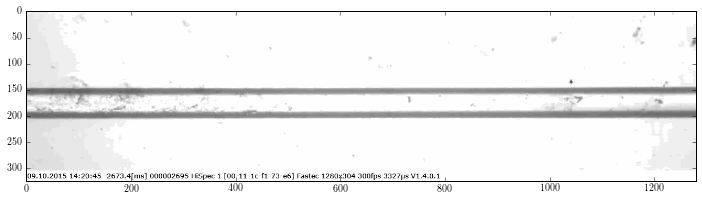

In [3]:
plt.figure(figsize=(12,8))
plt.imshow(imgs[0], cmap=cm.gray)

### Define Region of Interest

In [4]:
borderRegion = [ slice(148,206) , slice(0,-1) ] # [ [x_top, x_bottom], [y_left, y_right]]

In [5]:

def convertImage(im):
    
    im = (im[:,:,0] + im[:,:,1] + im[:,:,2])/3 # average RGB
    # do not use the skimage.io.imread(as_gray=true) because it uses another gray scale transformation
    # here we do simply averaging!

    im = 1.0 - im; # invert image
    
    # crop image
    size = im.shape
    im = im[ borderRegion[0] , borderRegion[1] ]
    
    return im

# take the average over all three channels and store it again
imgsGray = [ convertImage(im) for im in imgs ]

### Define Background

In [6]:
#first Image is background!
imgBack = imgsGray[0]

print("Shape:", imgBack.shape)

Shape: (58, 1279)


## Show 51th Image

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Background")
plt.imshow(imgBack, cmap=cm.gray)

plt.figure(figsize=(12,8))
plt.title("51th image")
plt.imshow(imgsGray[50], cmap=cm.gray)


## Subtract all background from Images

In [8]:
def subtractBackground(im,back):
    return np.clip(im - back, 0.0,1.0)

imgsGrayS = [ subtractBackground(im,imgBack) for im in imgsGray ]

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


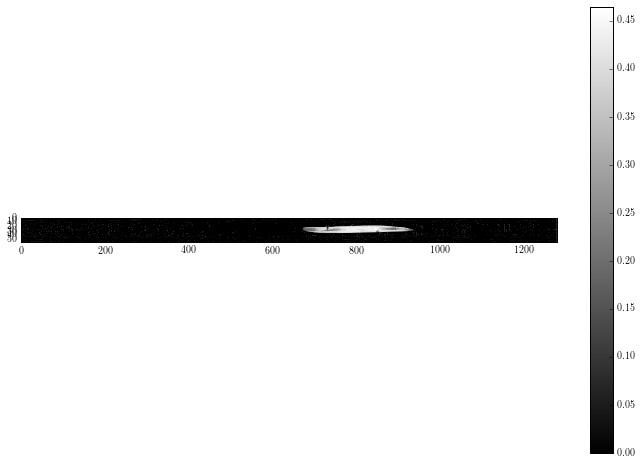

In [9]:
plt.figure(figsize=(12,8))
plt.imshow(imgsGrayS[50], cmap=cm.gray,interpolation='none')
plt.colorbar()

## Apply Simply Thresholding

In [12]:
# turn image (numpy array) into a np.masked_array
def thresholdImg(im):
    th = 0.1
    im = np.where( np.logical_and(0.0<=im , im<=th), 0.0, im)
    im = np.where( th<=im, 1.0, im)
    
    # make boolean mask
    im = skimage.util.img_as_bool(im)
    
    # remove small objects
    skimage.morphology.remove_small_objects(im, min_size=10, connectivity=1, in_place=True)
    
    return im
    
imgsBinary = [ thresholdImg(im) for im in imgsGrayS ]

/opt/python3.4Env/lib/python3.4/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/opt/python3.4Env/lib/python3.4/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to bool
  "%s to %s" % (dtypeobj_in, dtypeobj))


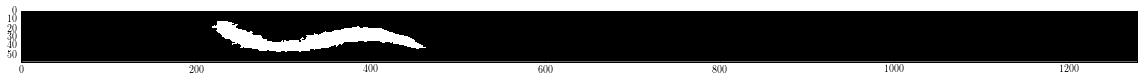

In [13]:
plt.figure()
plt.imshow(imgsBinary[24], cmap=cm.gray,interpolation='none')

## Save all images to disk

In [ ]:
for i,im in enumerate(imgsBinary):
    skimage.io.imsave("worm-f-%03i.tif" % i ,
                      skimage.util.img_as_ubyte(im)
                     )

## Extract AABB (axis alinged box) of Worm

In [17]:
def extractAABB(i,im):
    blobs,nblobs=skimage.measure.label(im, connectivity=2,   return_num=True)
    
    
    if nblobs == 0:
        # no labled regions found!
        print("labeled image frame %i" % i, "found 0 regions")
        return None
    
    regprops=skimage.measure.regionprops(blobs)
    
    blobs = list(zip(blobs,regprops)) # put blobs and probs into a list [ [blob,probs], [blob,probs] ]

    # sort regions according to their area size 
    blobs = sorted(blobs,key= lambda b: b[1].area)
    
    # take the last blob becaus it has greatest area! (its the worm!)
    
    print("labeled image frame %i" % i, "found %i regions" % nblobs, "largest area (worm): %f" % blobs[-1][1].area)
    
    return blobs[-1][1].bbox

boxes = [ extractAABB(i,im) for i,im in enumerate(imgsBinary) ]

labeled image frame 0 found 0 regions
labeled image frame 1 found 0 regions
labeled image frame 2 found 0 regions
labeled image frame 3 found 0 regions
labeled image frame 4 found 0 regions
labeled image frame 5 found 1 regions largest area (worm): 147.000000
labeled image frame 6 found 3 regions largest area (worm): 403.000000
labeled image frame 7 found 1 regions largest area (worm): 783.000000
labeled image frame 8 found 2 regions largest area (worm): 1069.000000
labeled image frame 9 found 1 regions largest area (worm): 1347.000000
labeled image frame 10 found 1 regions largest area (worm): 1686.000000
labeled image frame 11 found 1 regions largest area (worm): 2004.000000
labeled image frame 12 found 1 regions largest area (worm): 2262.000000
labeled image frame 13 found 1 regions largest area (worm): 2664.000000
labeled image frame 14 found 1 regions largest area (worm): 2932.000000
labeled image frame 15 found 1 regions largest area (worm): 3216.000000
labeled image frame 16 fou

## Overlap Test AABB with 

In [18]:
def rangeOverlap(a_min, a_max, b_min, b_max):
    '''Check if Ranges overlap and if [b_min,b_max] is even inside [a_min,a_max]
        return (overlap,inside) -> (True,False) means overlaps but not inside [a_min,a_max]
    '''
    if (a_min > b_max) or (a_max < b_min):
        return (False,False) # no overlap, and also not inside!
    
    # we have overlap (True,??)
    
    if (b_min >= a_min) and (b_max <= a_max):
        return (True,True) # we are even inside!
    
    return (True,False)

def overlap(r1, r2):
    '''Overlapping rectangles overlap both horizontally & vertically and also return if
       r2 is fully inside r1!
    '''
    
    y = rangeOverlap(r1.left, r1.right, r2.left, r2.right)
    x = rangeOverlap(r1.bottom, r1.top, r2.bottom, r2.top)
    
    
    return  ( y[0] and x[0]   # overlap only if x,y ranges overlap
             , y[1] and x[1]) # inside only if r2 is inside in x and y direction!


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
class Rect:
    def __init__(self, p1, p2):
        '''Store the top, bottom, left and right values for points 
               p1 and p2 are the (corners) in either order
        '''
        self.left   = min(p1.x, p2.x)
        self.right  = max(p1.x, p2.x)
        self.bottom = min(p1.y, p2.y)
        self.top    = max(p1.y, p2.y)

# Region of Interest where the State is 1 if the worm is completely inside
# [ [x_min, x_max ] , [y_min, y_max ] ]
regionOfInterest = [ [15,40], [0,imgBack.shape[1]-1 ] ]
                
roiRect = Rect( 
                Point(regionOfInterest[0][0], regionOfInterest[1][0]), # min point
                Point(regionOfInterest[0][1], regionOfInterest[1][1])  # max point
              )


wormStates = []
for i,box in enumerate(boxes):
    
    print("overlap test for frame %i" % i)
    wormState = -1
    
    if box is not None:
        # box is (min_row, min_col, max_row, max_col) 
        # and defines the AABB around the worm

        r = Rect( 
                Point(box[0],box[1]-1), # min point (minus one because of http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)
                Point(box[2],box[3]-1)  # max point
            )
        overlaps, isInside = overlap(roiRect, r)

        if overlaps:
            wormState = 1
            if isInside:
                wormState = 0

    wormStates += [wormState] # add to list
    
    print("Worm State for frame %i is %i" % (i,wormState) )


overlap test for frame 0
Worm State for frame 0 is -1
overlap test for frame 1
Worm State for frame 1 is -1
overlap test for frame 2
Worm State for frame 2 is -1
overlap test for frame 3
Worm State for frame 3 is -1
overlap test for frame 4
Worm State for frame 4 is -1
overlap test for frame 5
Worm State for frame 5 is 1
overlap test for frame 6
Worm State for frame 6 is 1
overlap test for frame 7
Worm State for frame 7 is 1
overlap test for frame 8
Worm State for frame 8 is 1
overlap test for frame 9
Worm State for frame 9 is 1
overlap test for frame 10
Worm State for frame 10 is 1
overlap test for frame 11
Worm State for frame 11 is 1
overlap test for frame 12
Worm State for frame 12 is 1
overlap test for frame 13
Worm State for frame 13 is 1
overlap test for frame 14
Worm State for frame 14 is 1
overlap test for frame 15
Worm State for frame 15 is 1
overlap test for frame 16
Worm State for frame 16 is 1
overlap test for frame 17
Worm State for frame 17 is 1
overlap test for frame 18

(-1, 1)

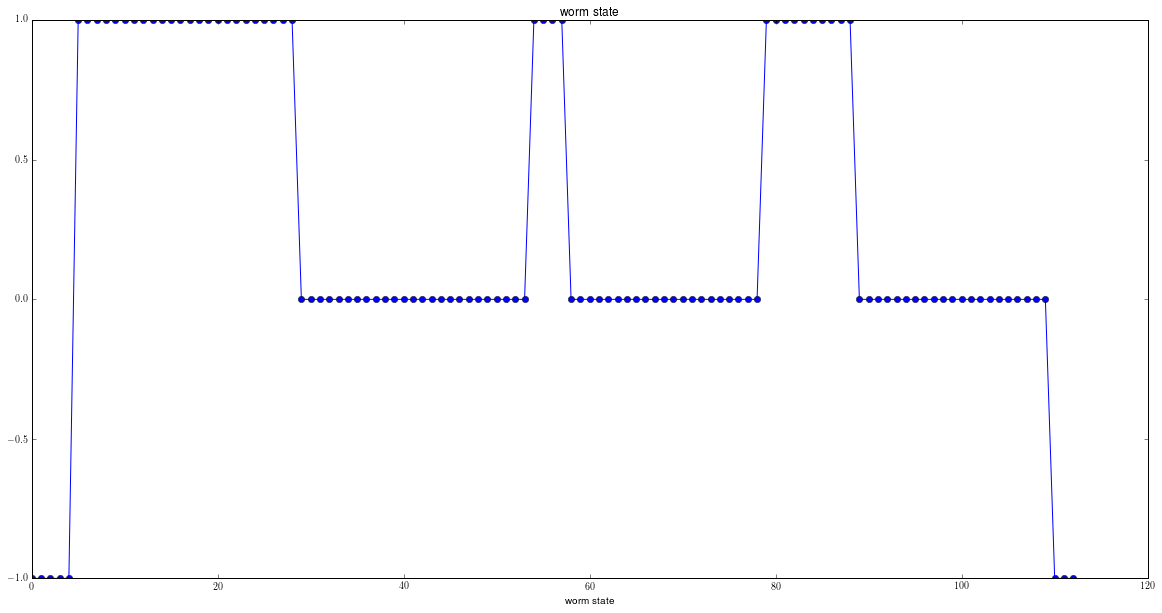

In [19]:
# Plot the wormState over all Frames
plt.plot(wormStates, 'o-')
plt.title("worm state")
plt.xlabel("frame")
plt.xlabel("worm state")
plt.ylim([-1,1])

## Plot Worm State in Image:

ERROR! Session/line number was not unique in database. History logging moved to new session 26


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/lib/python3/dist-packages/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


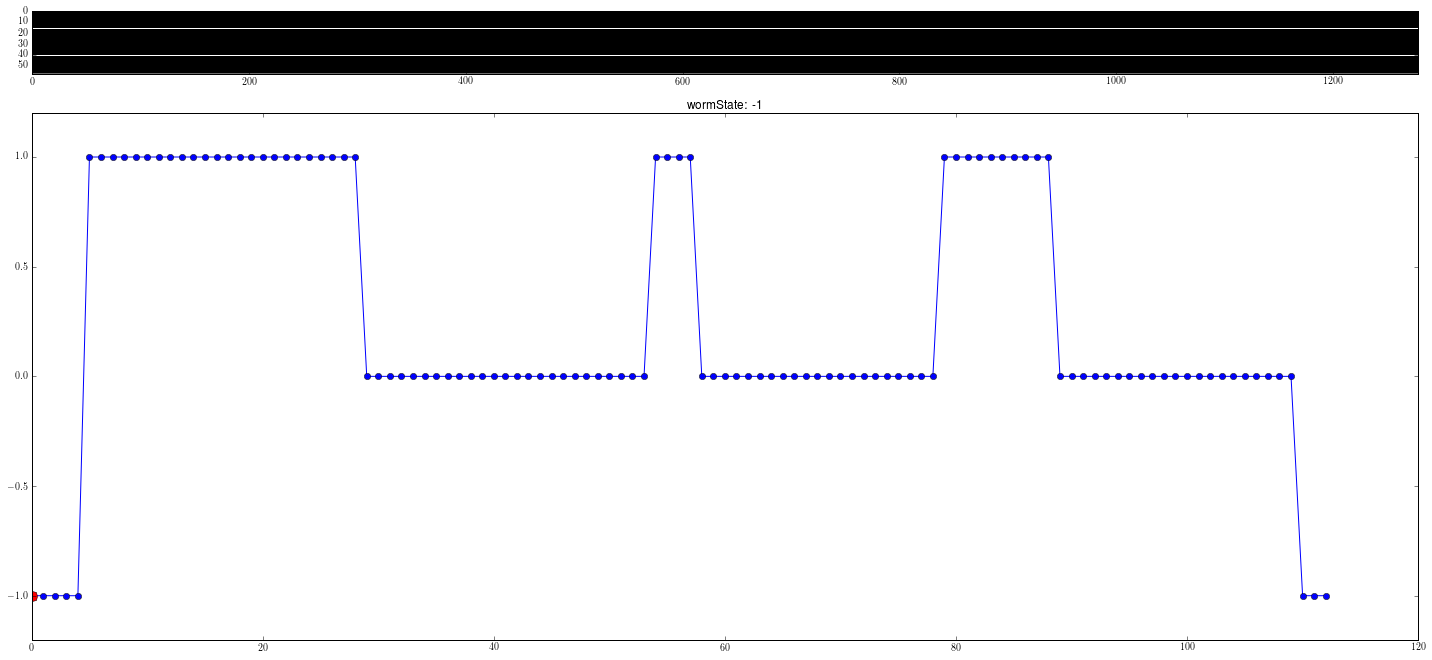

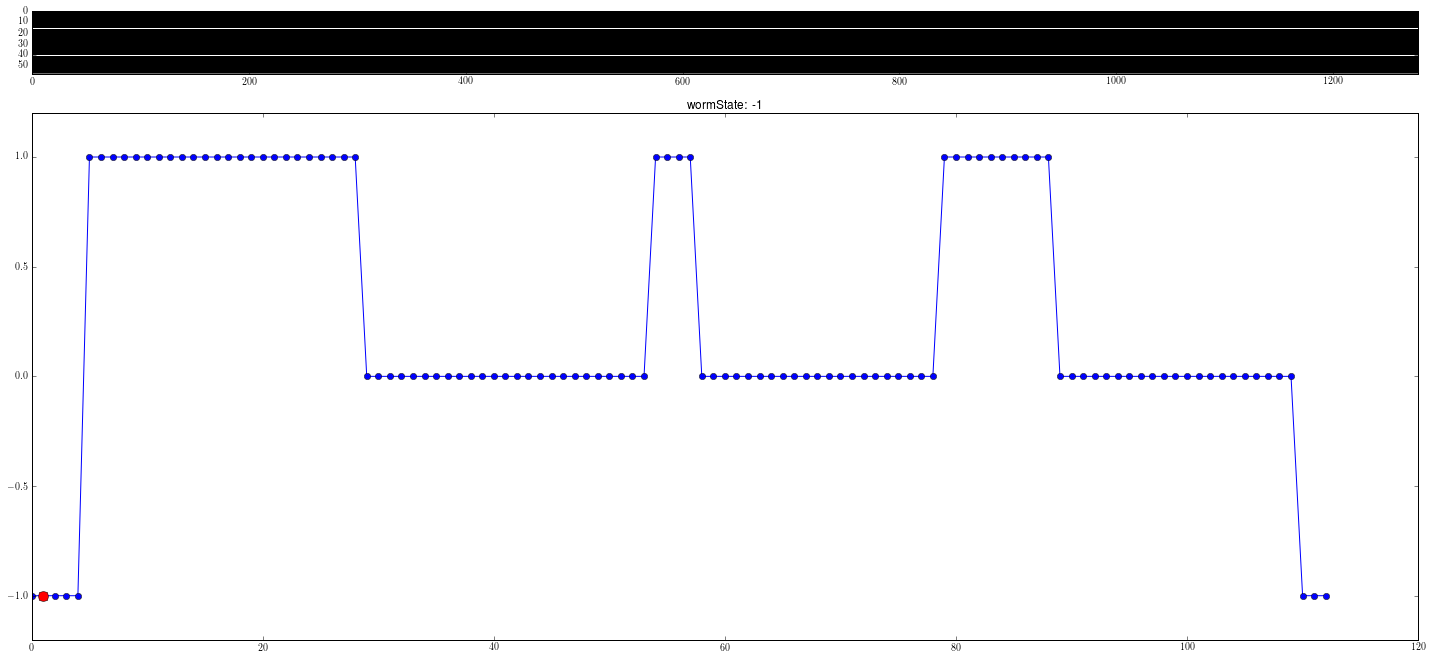

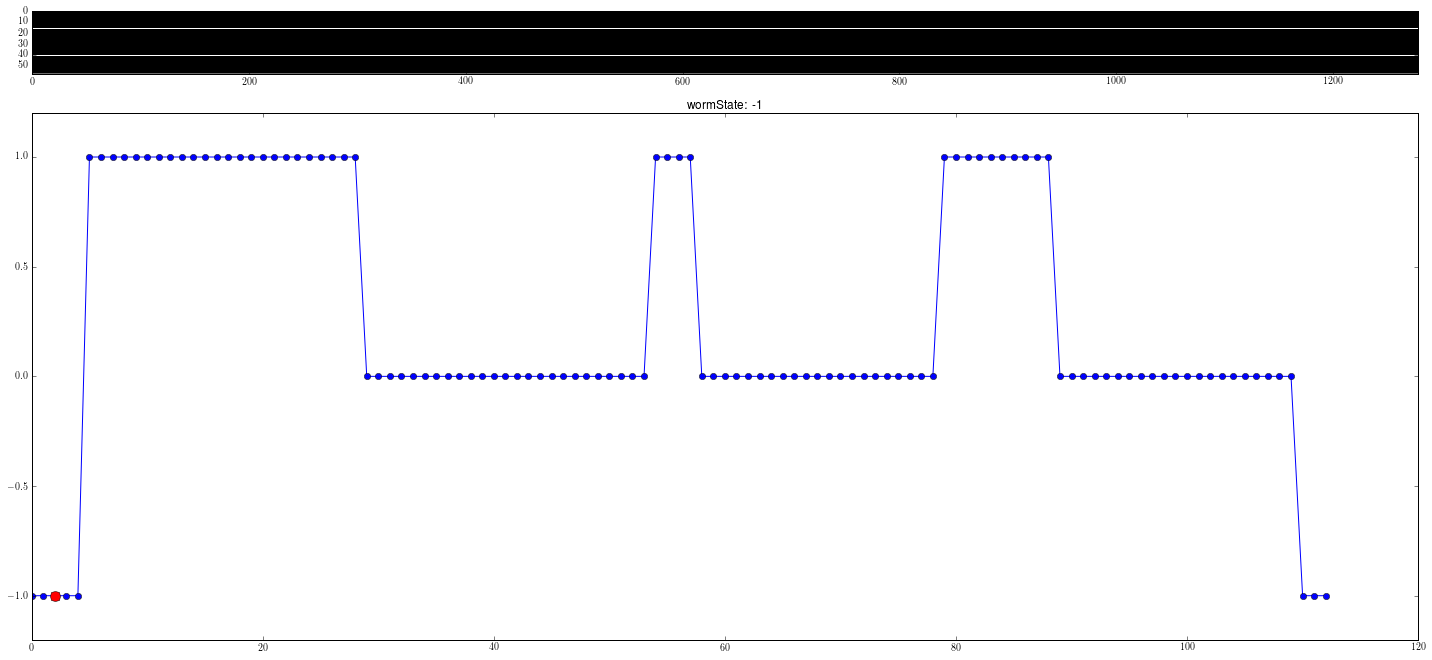

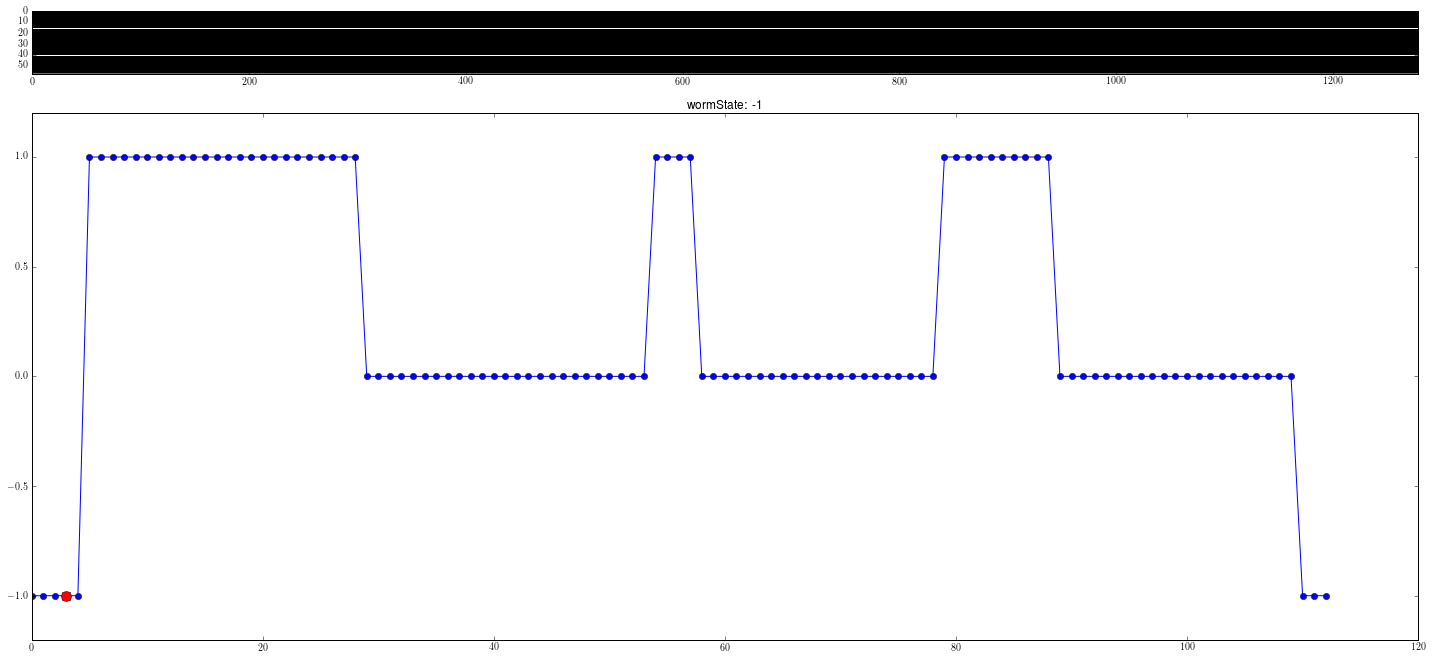

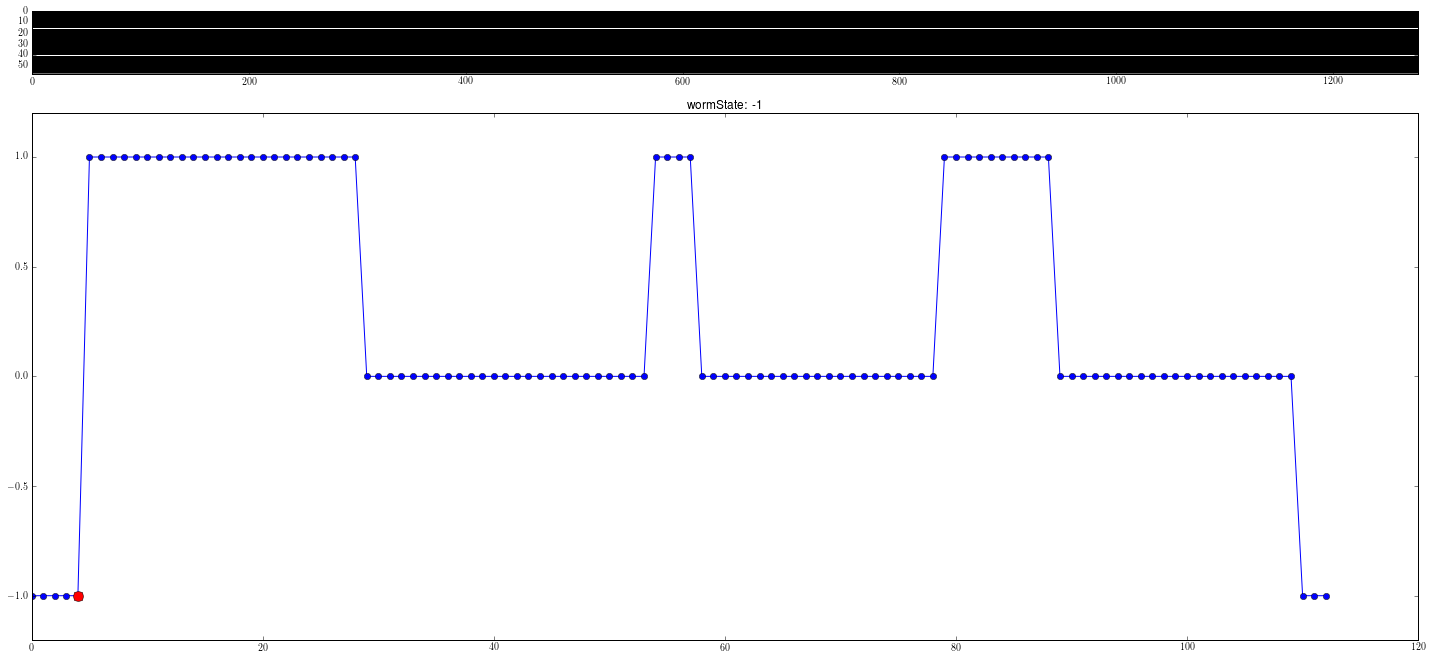

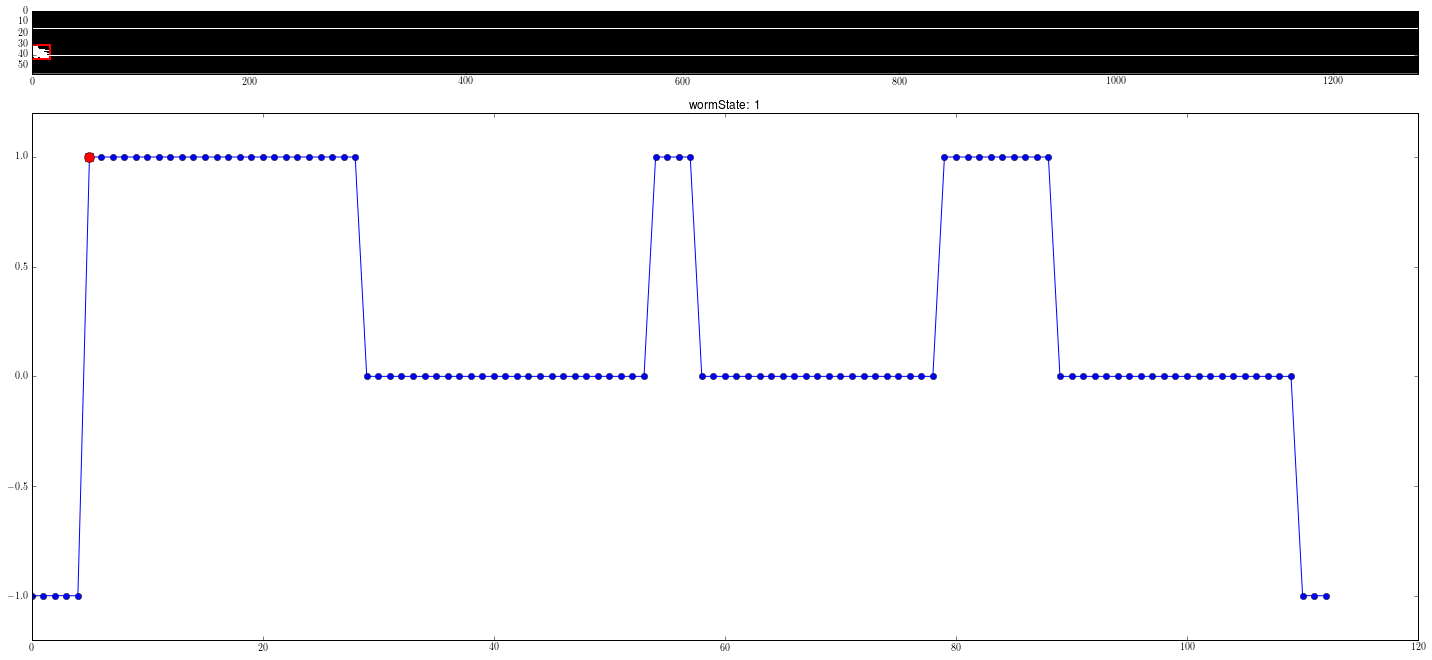

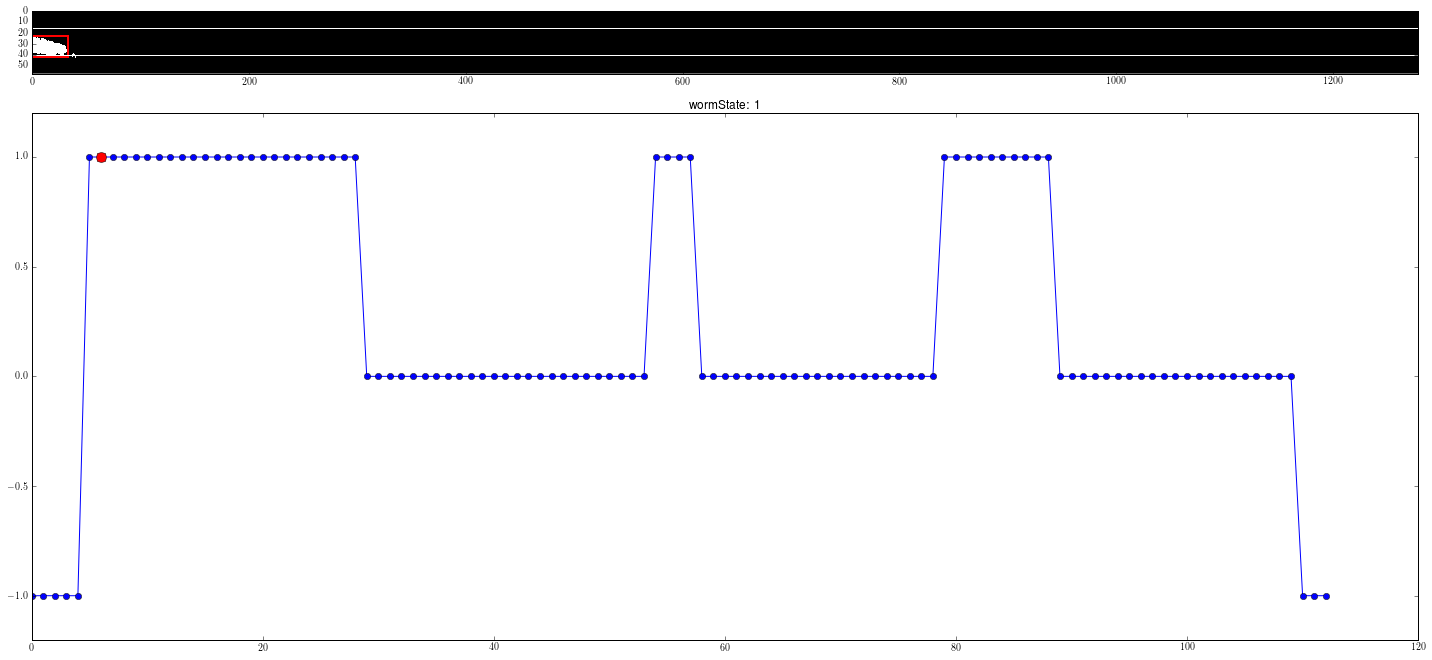

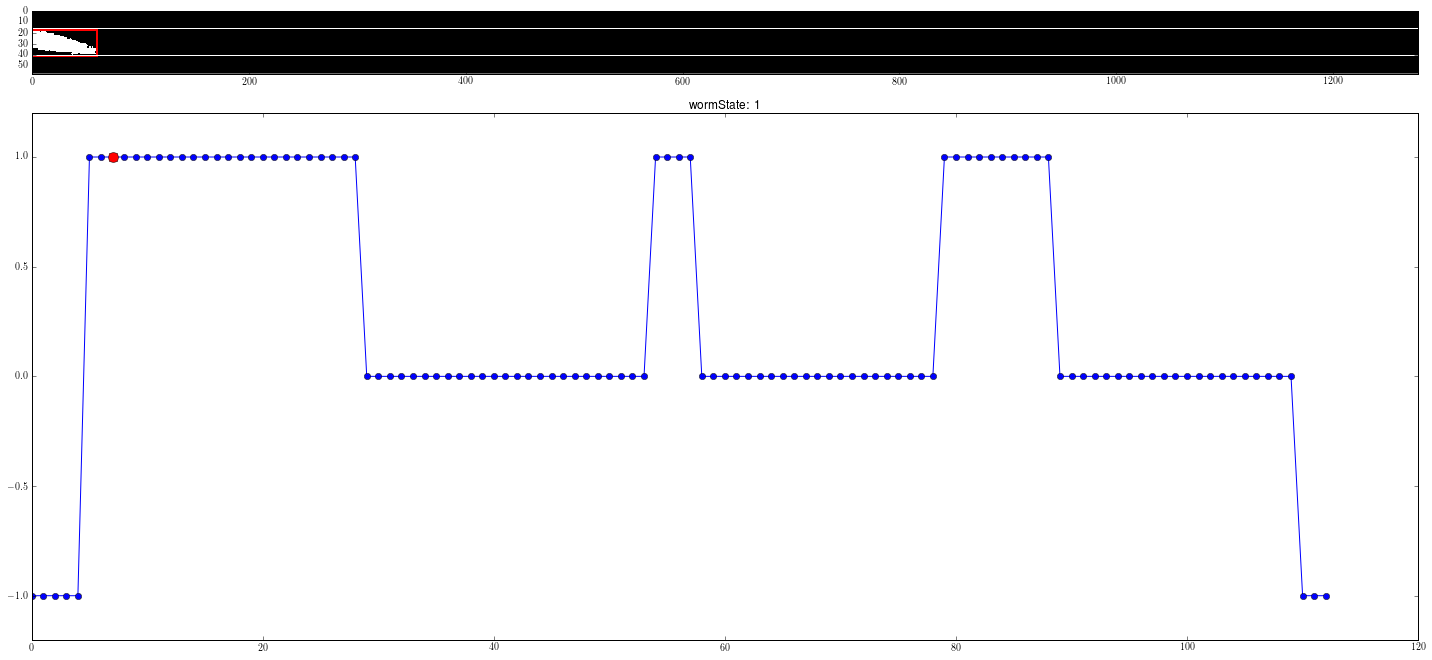

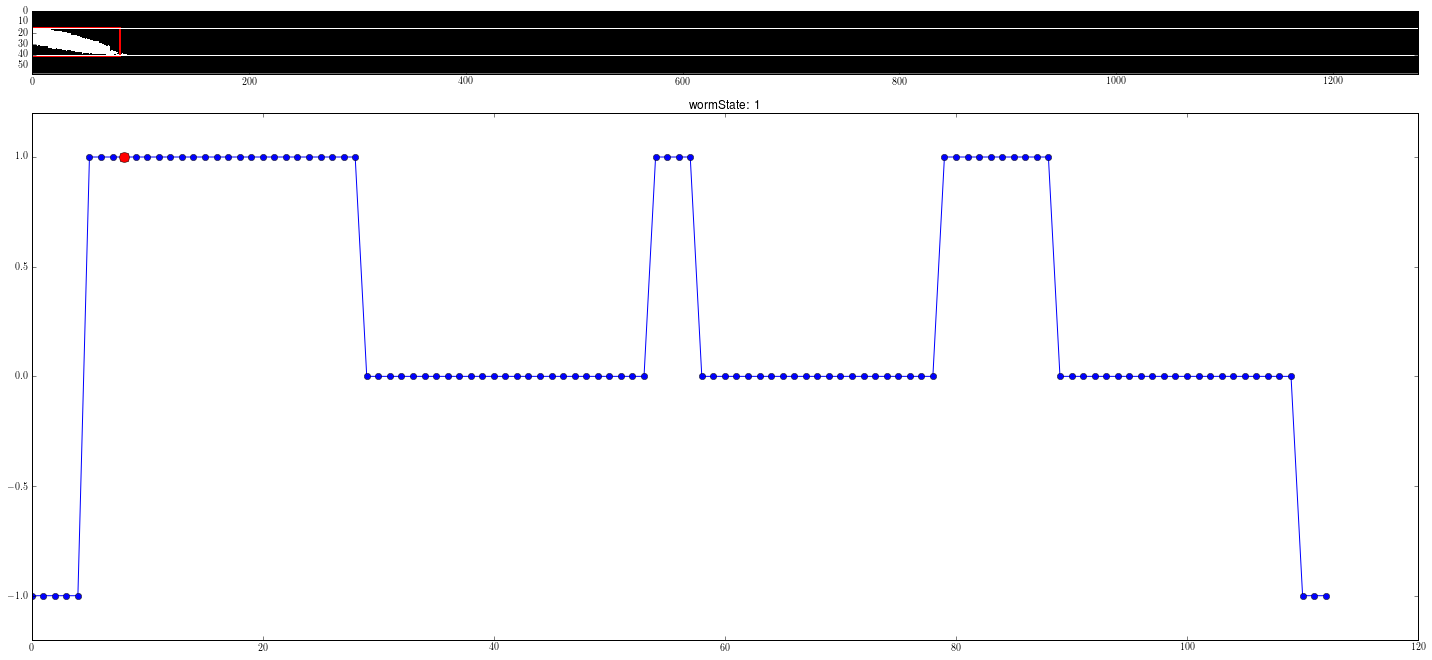

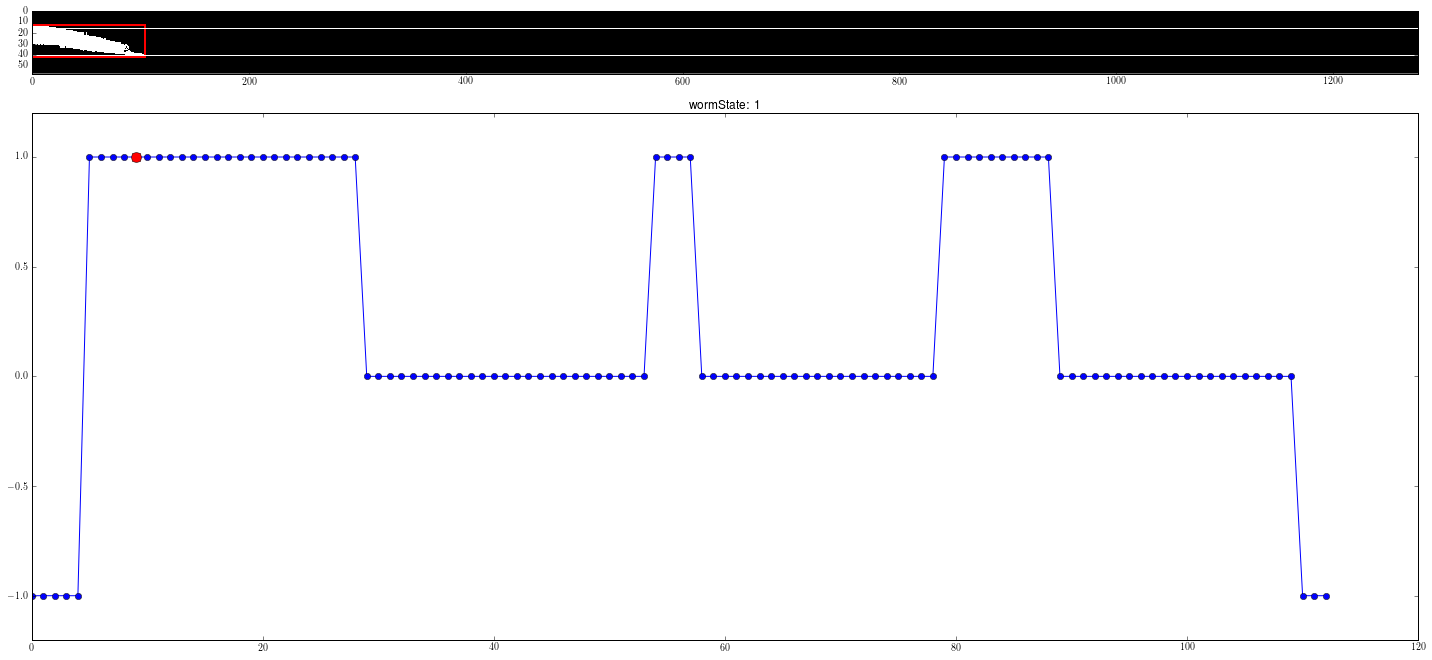

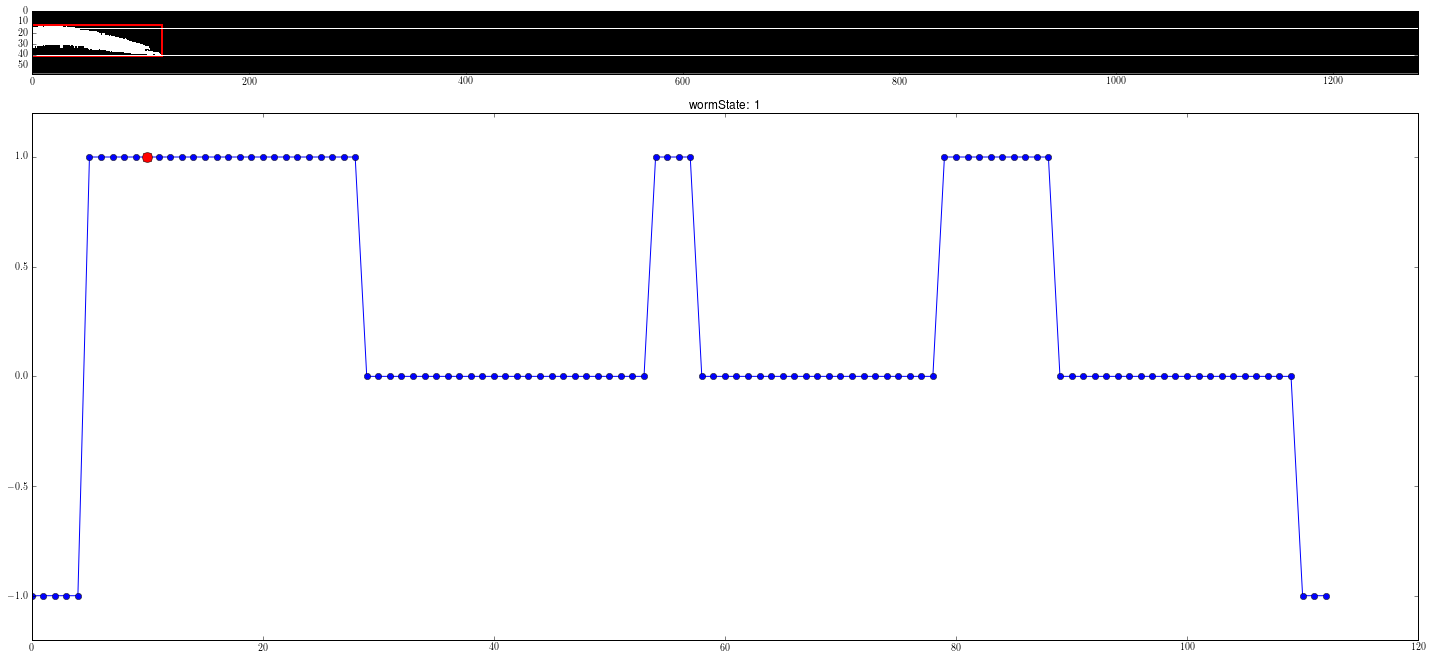

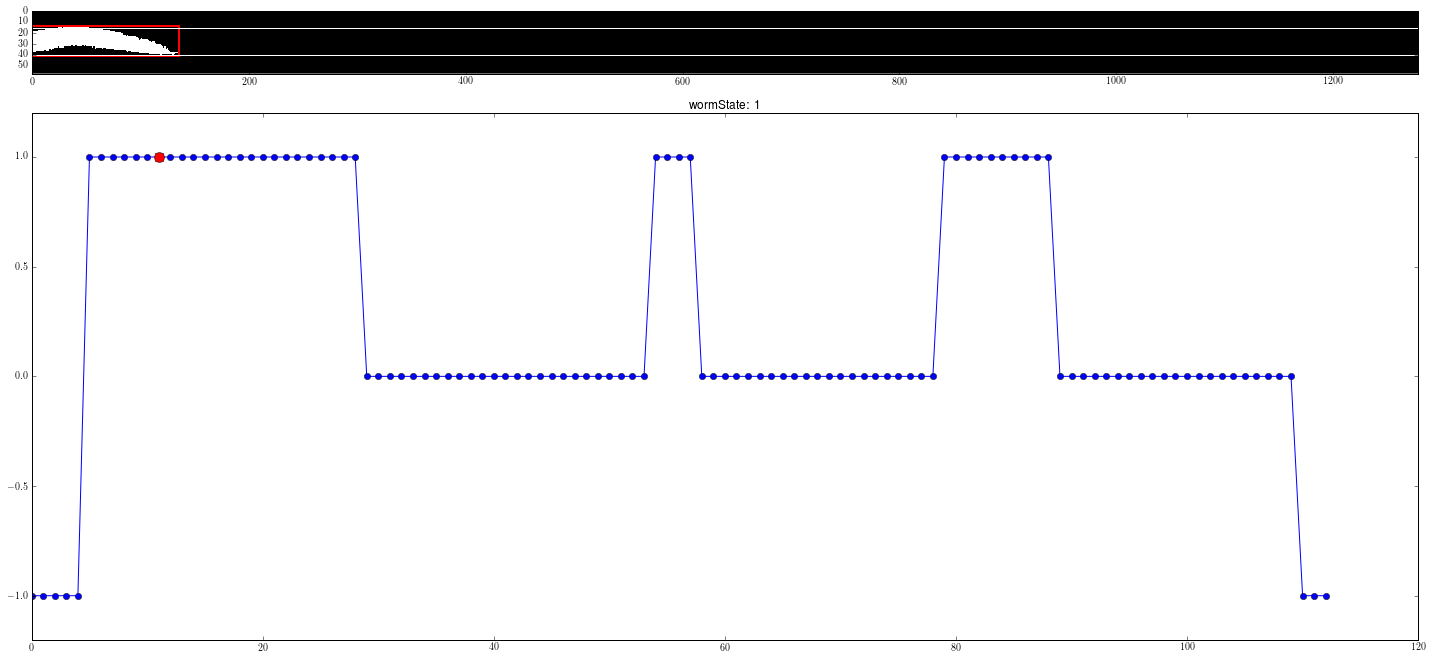

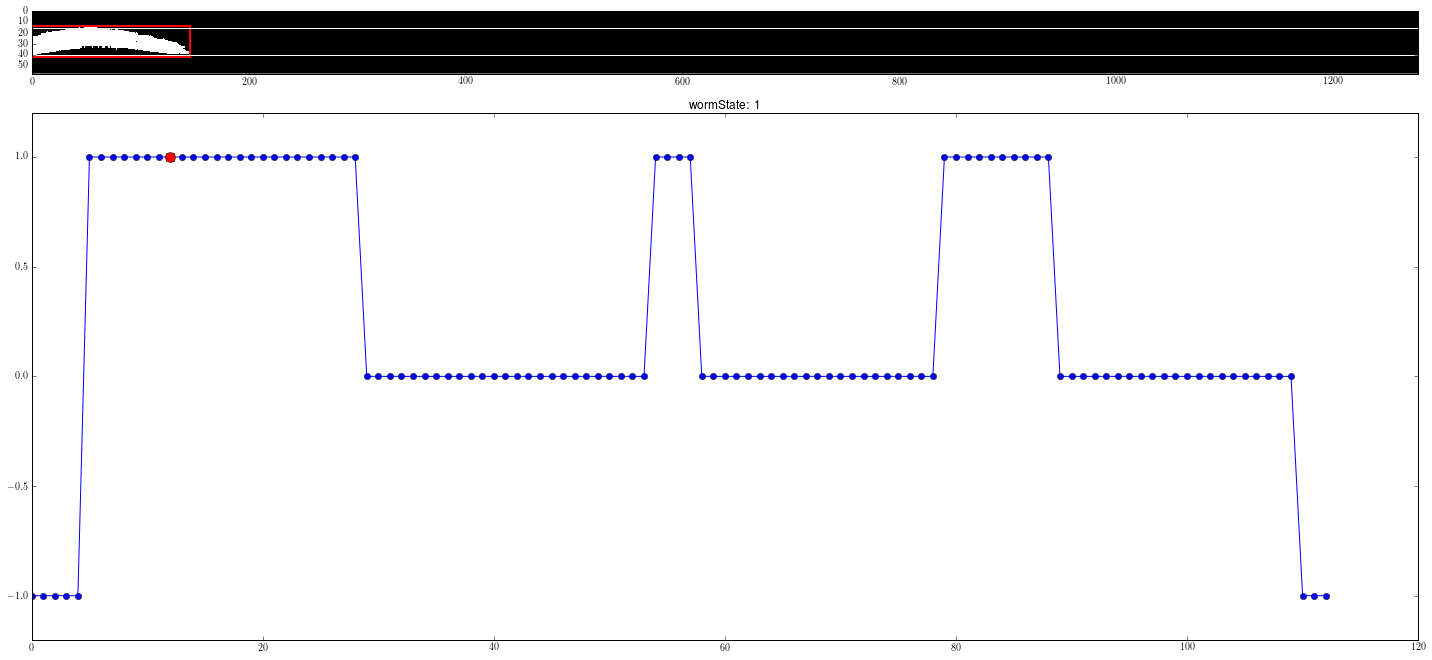

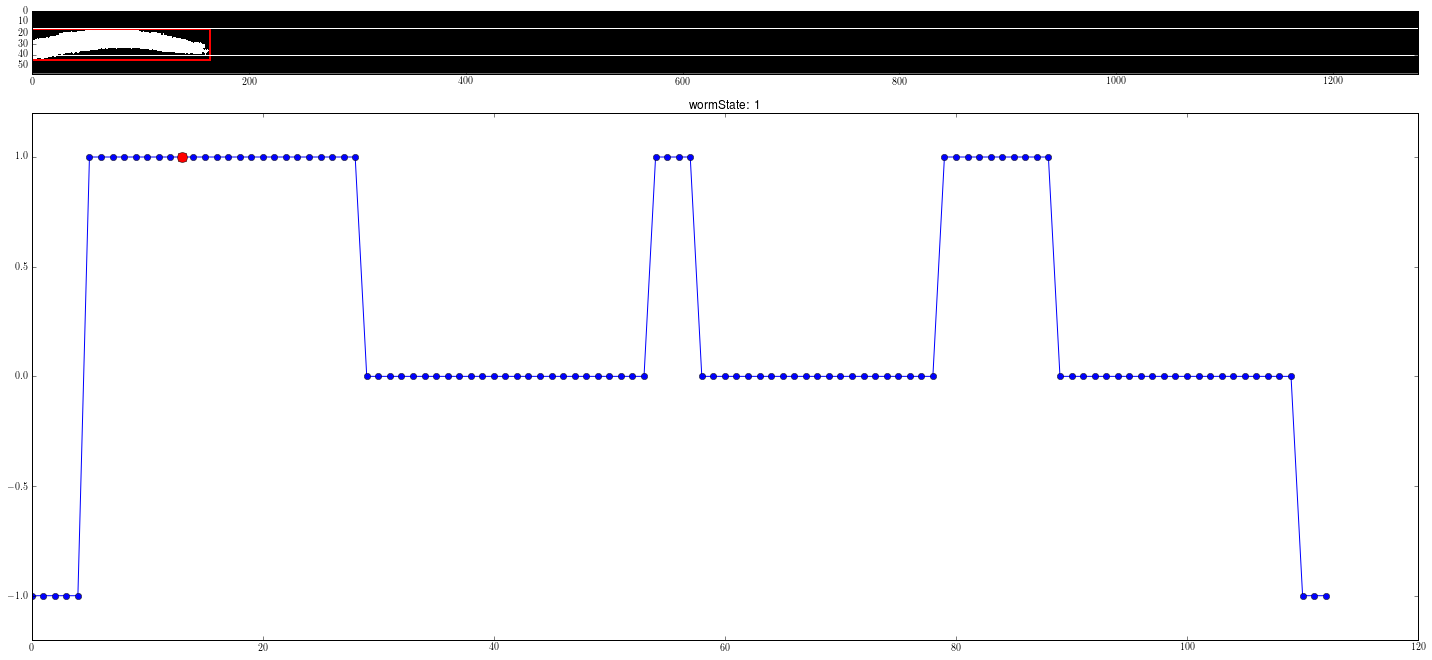

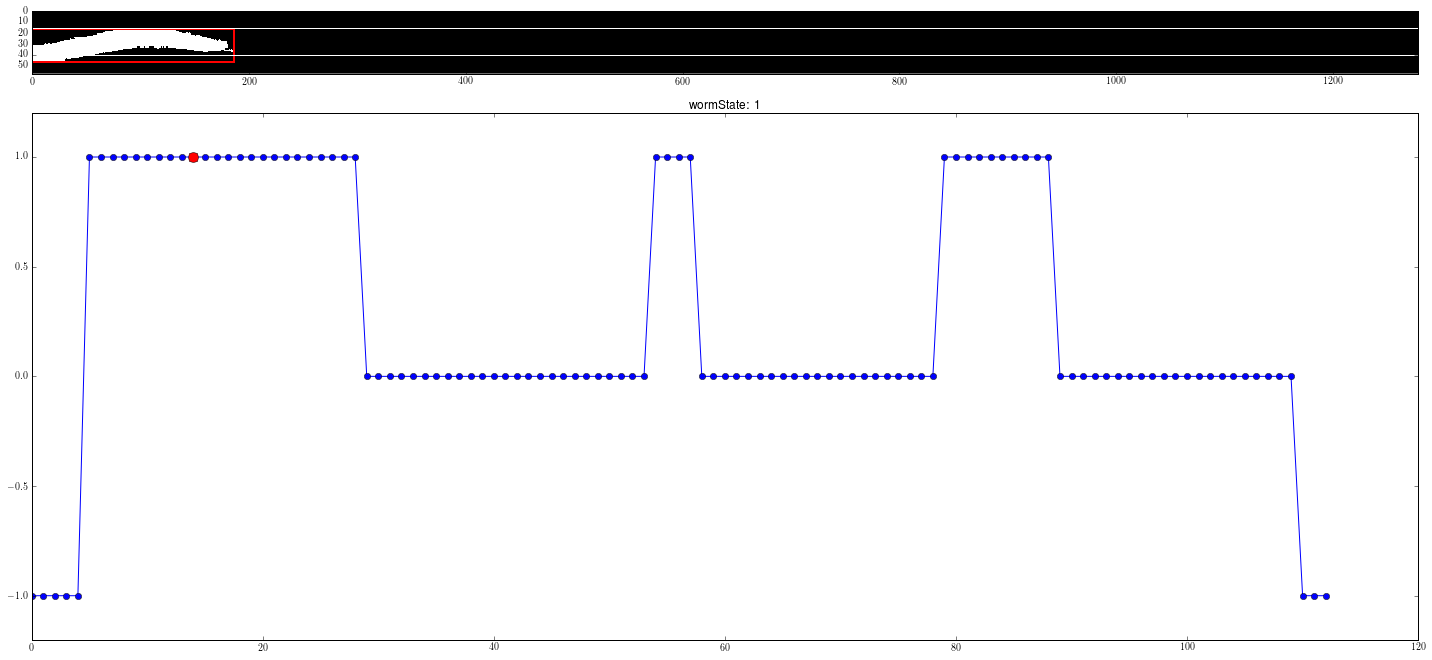

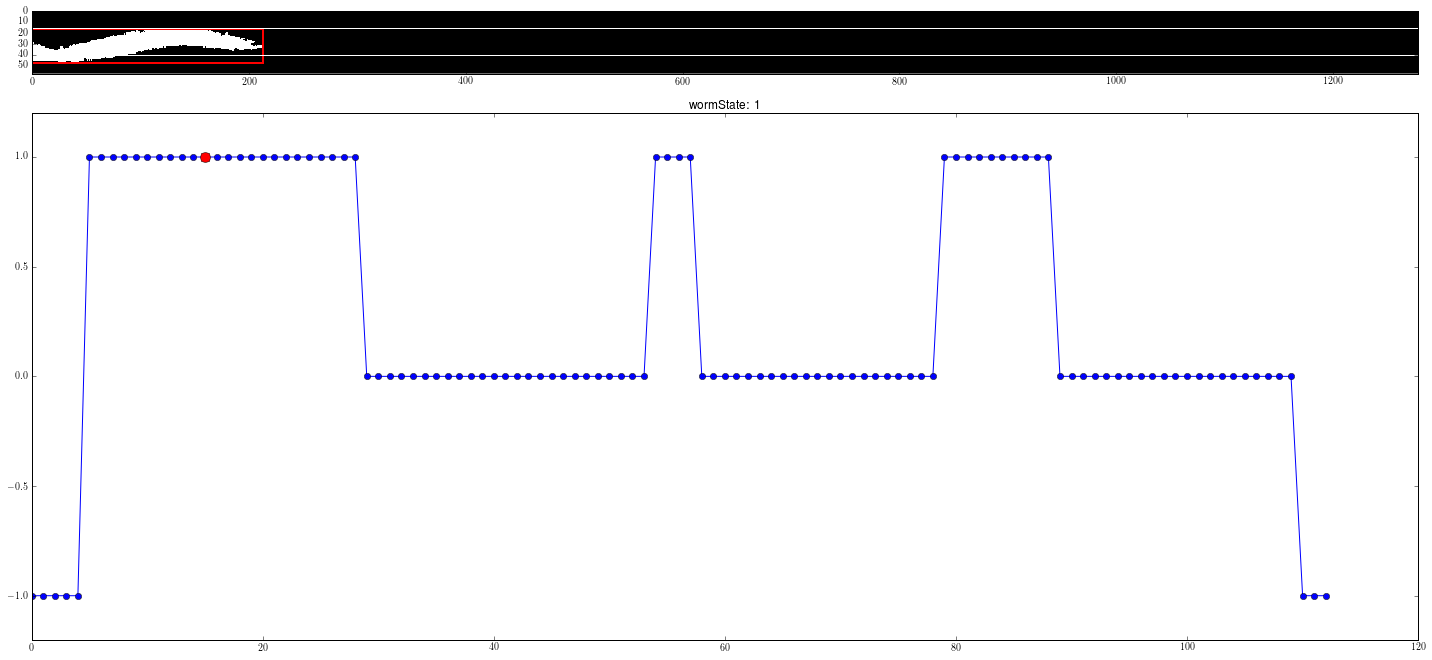

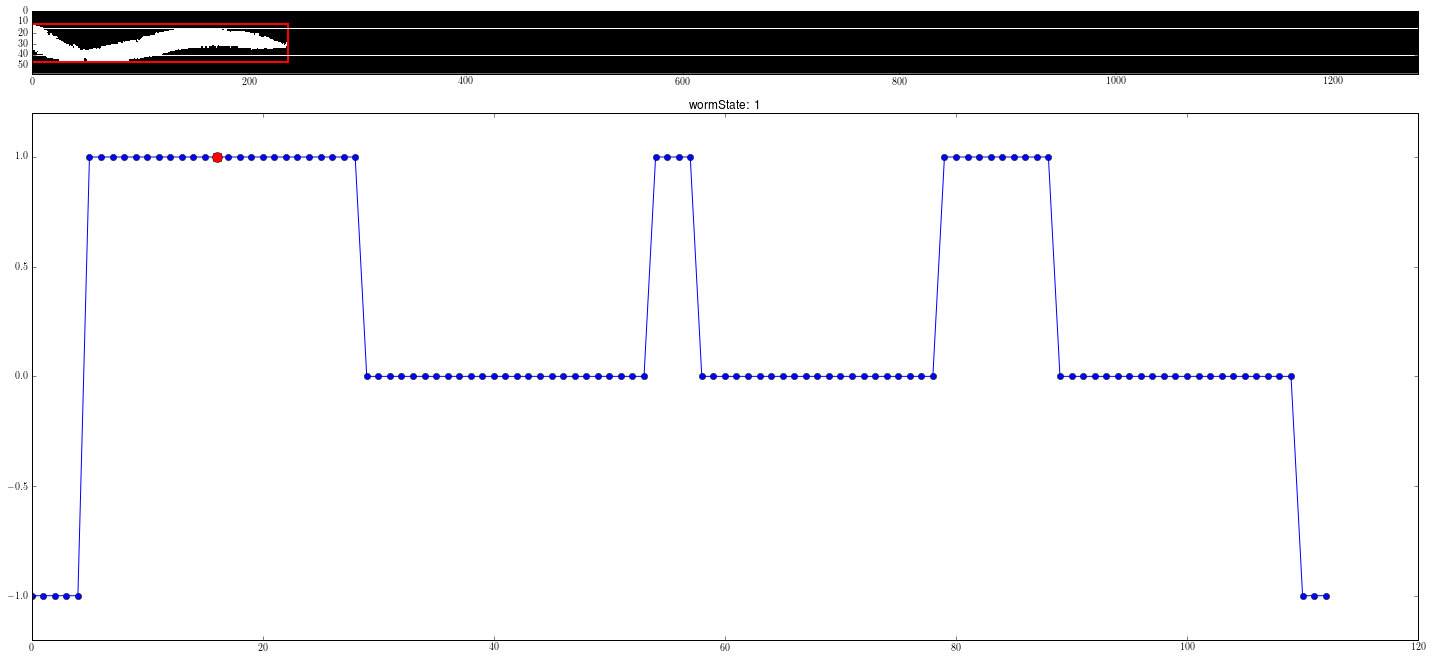

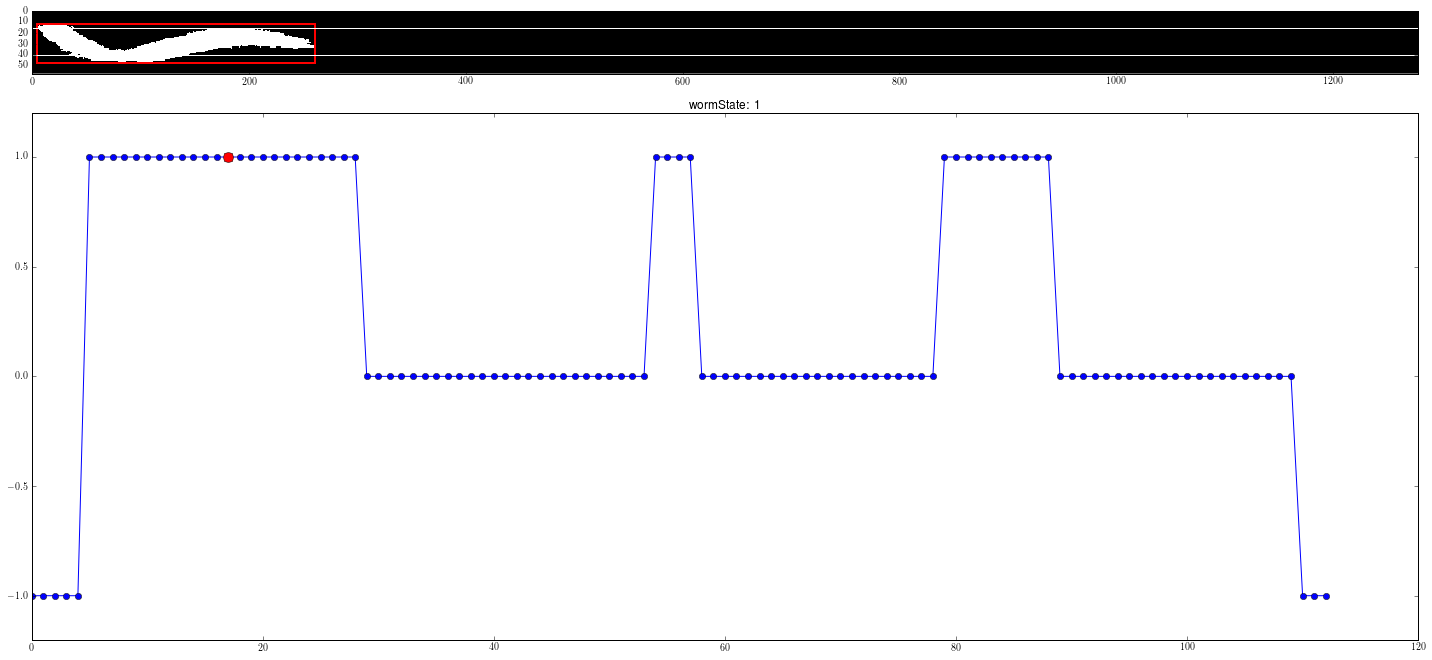

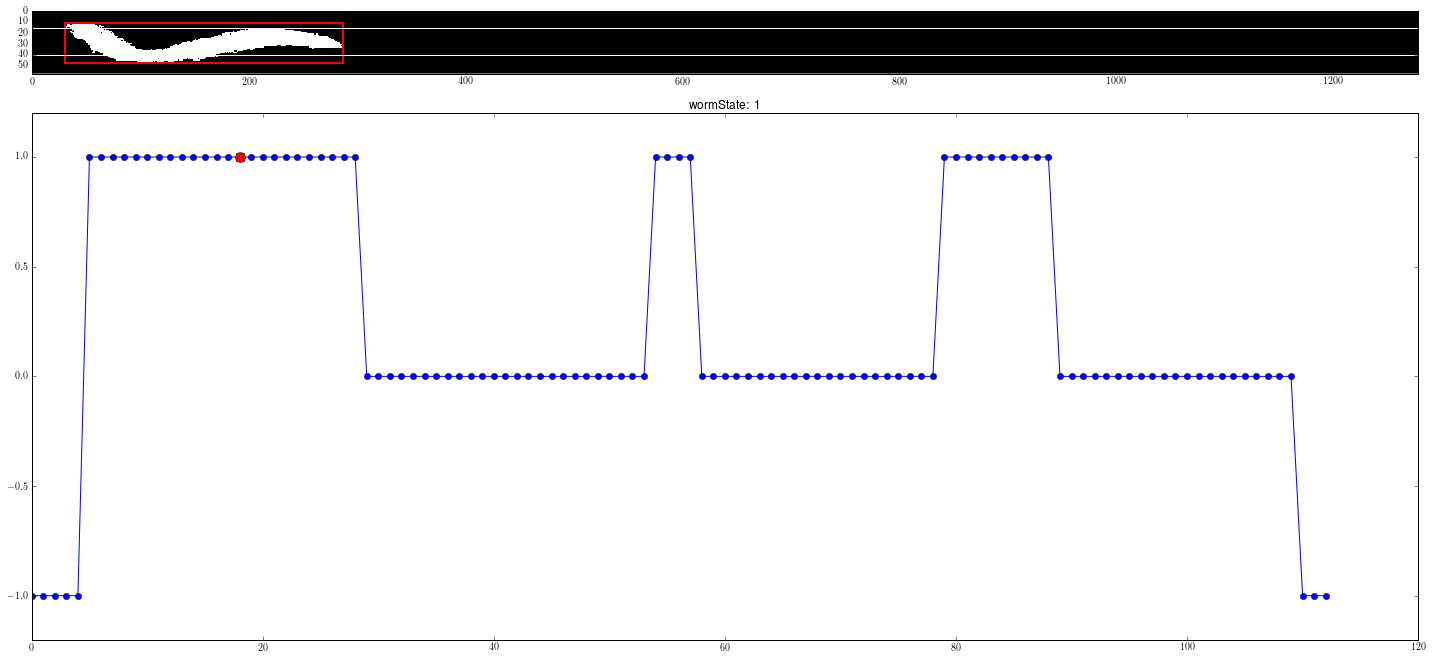

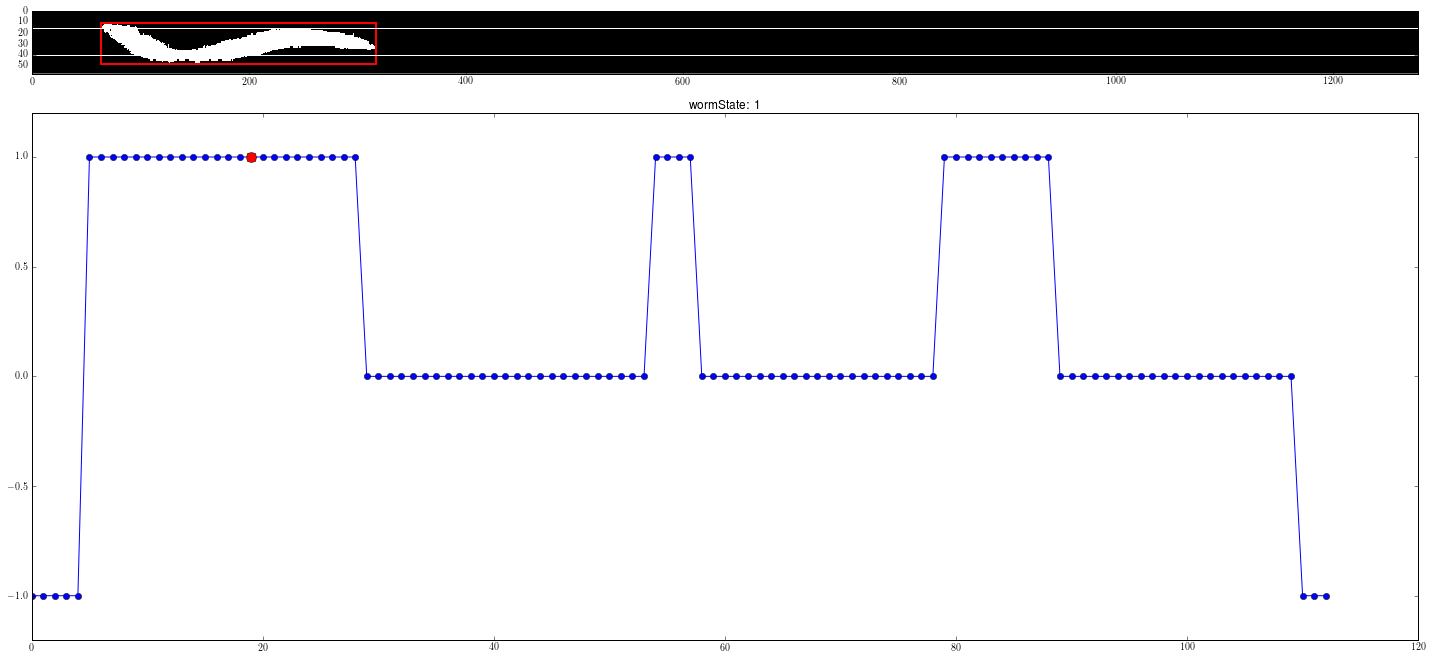

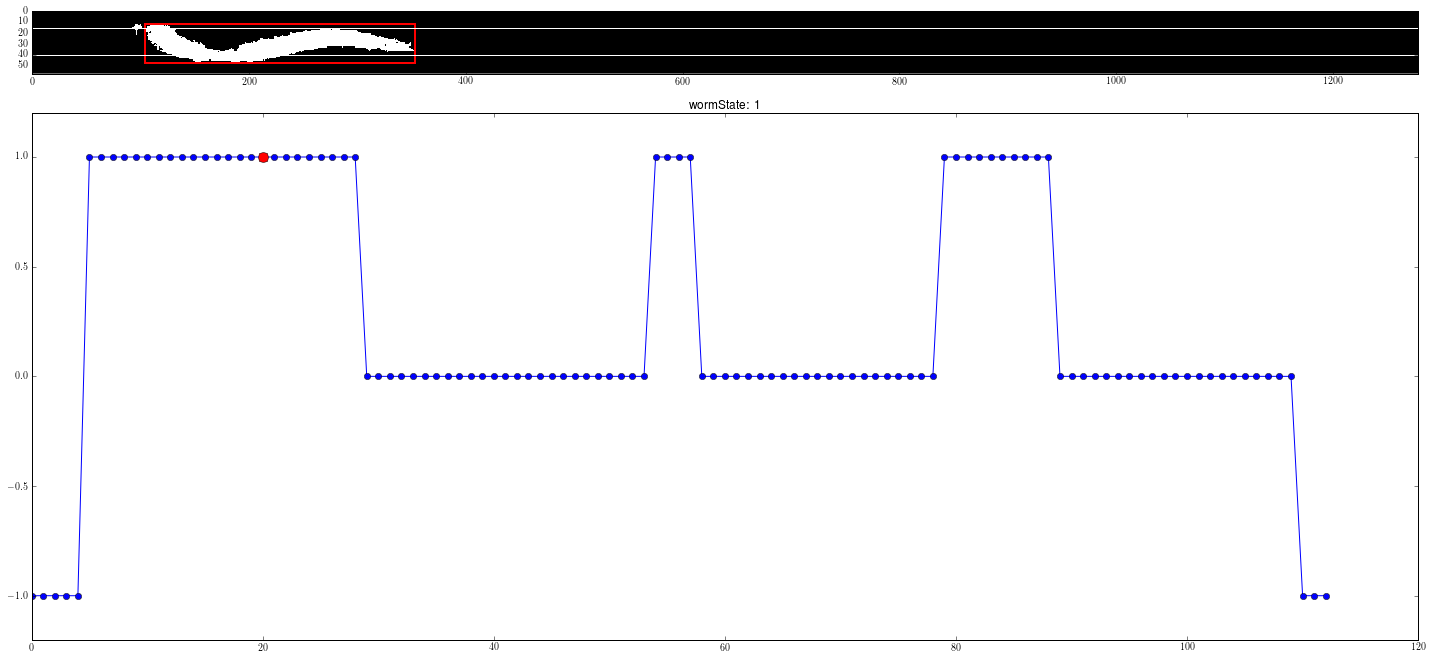

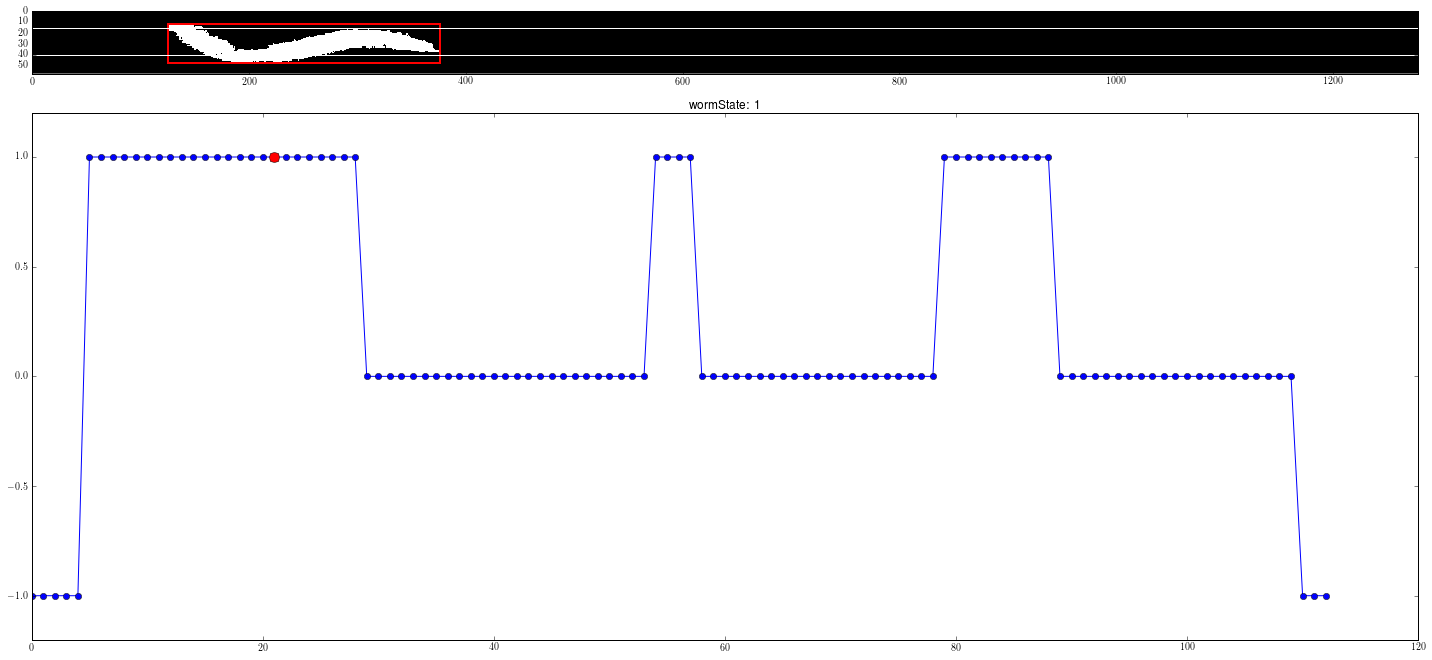

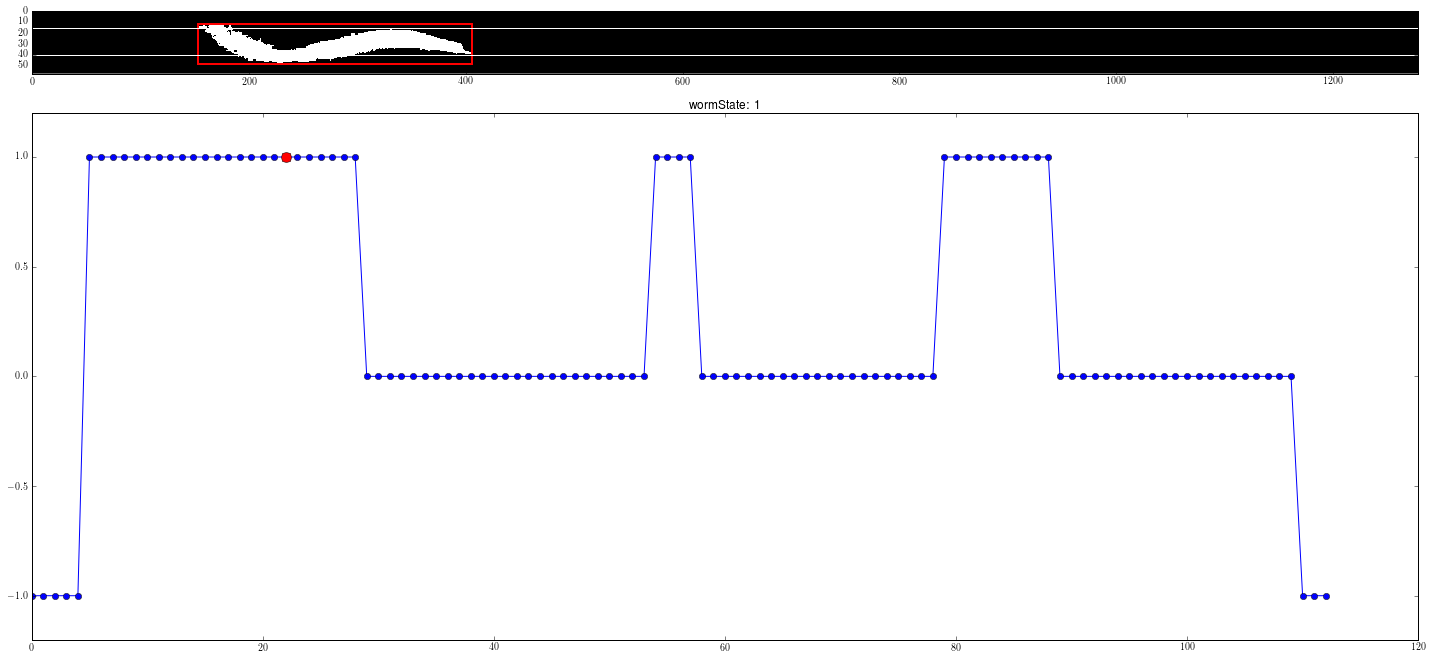

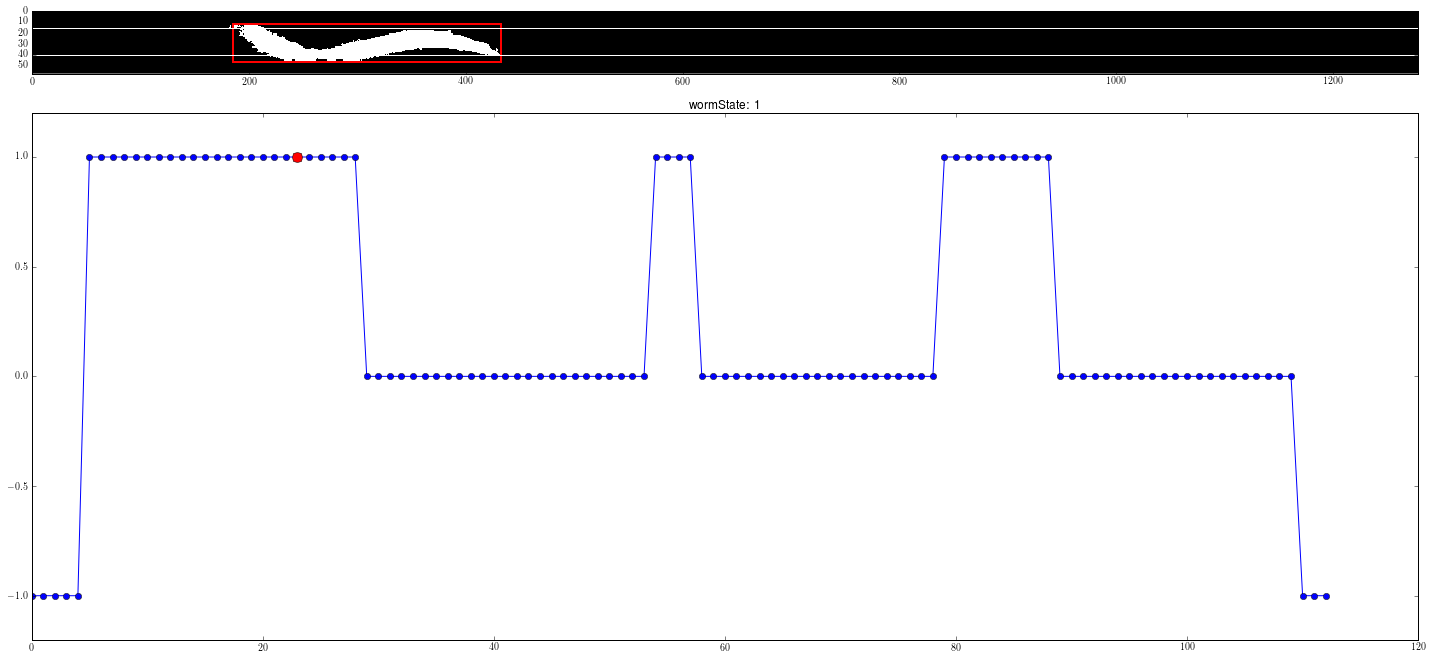

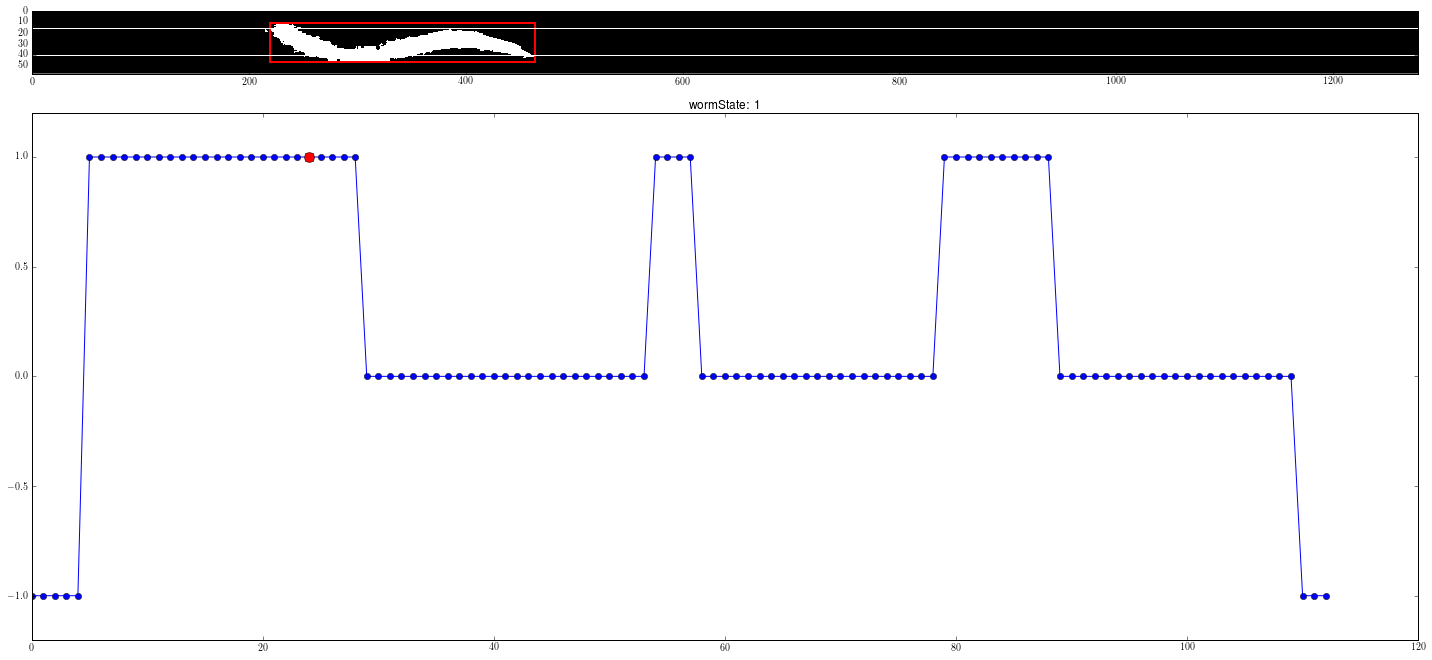

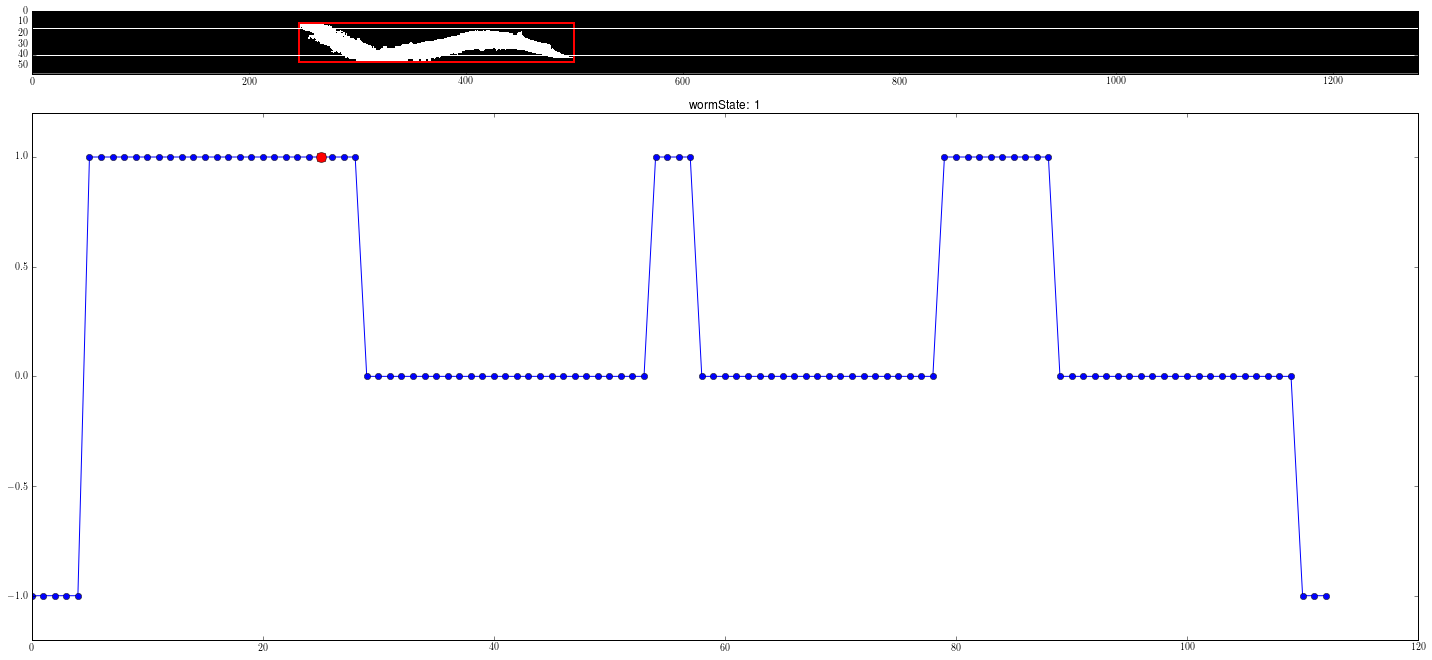

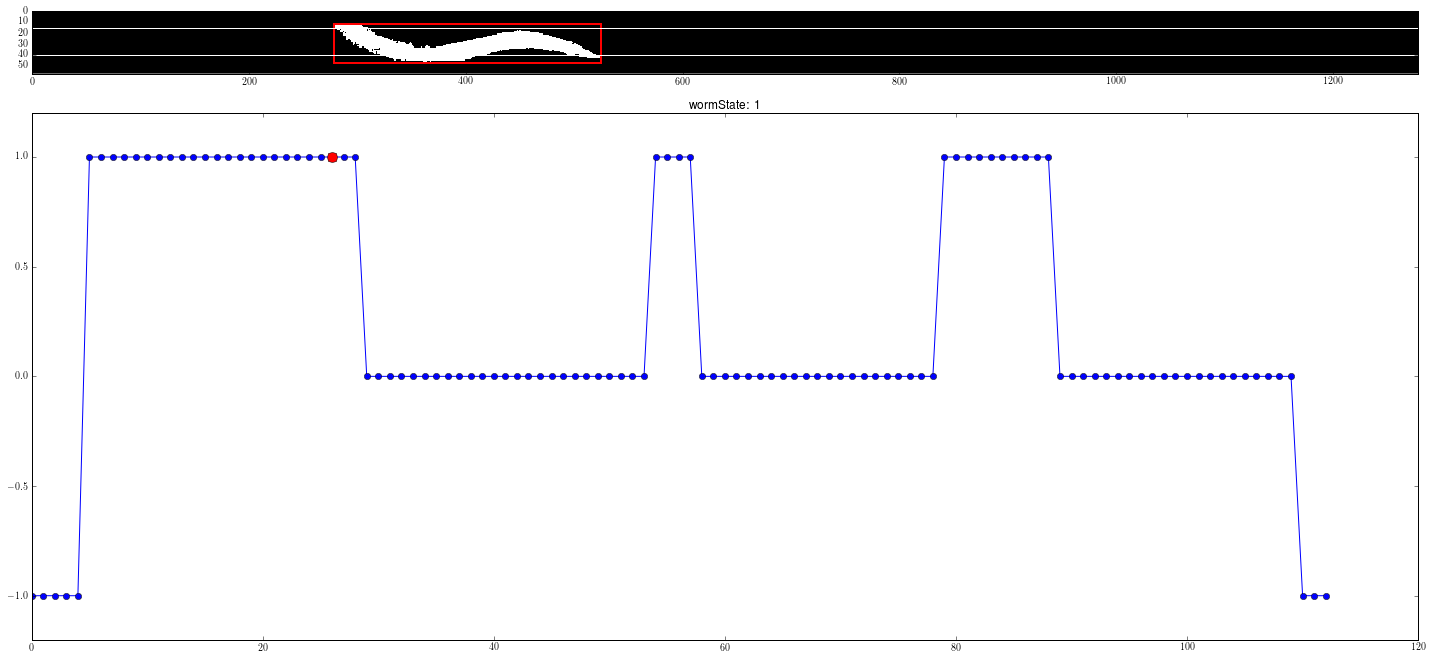

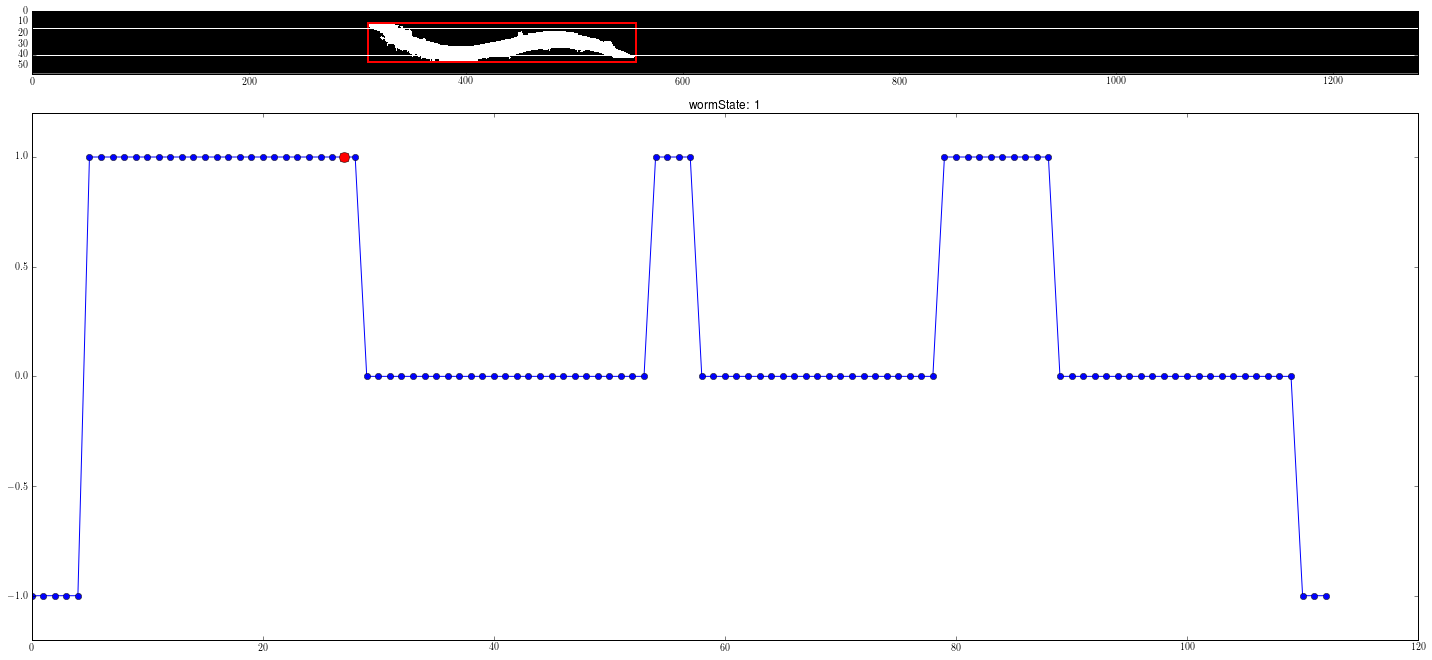

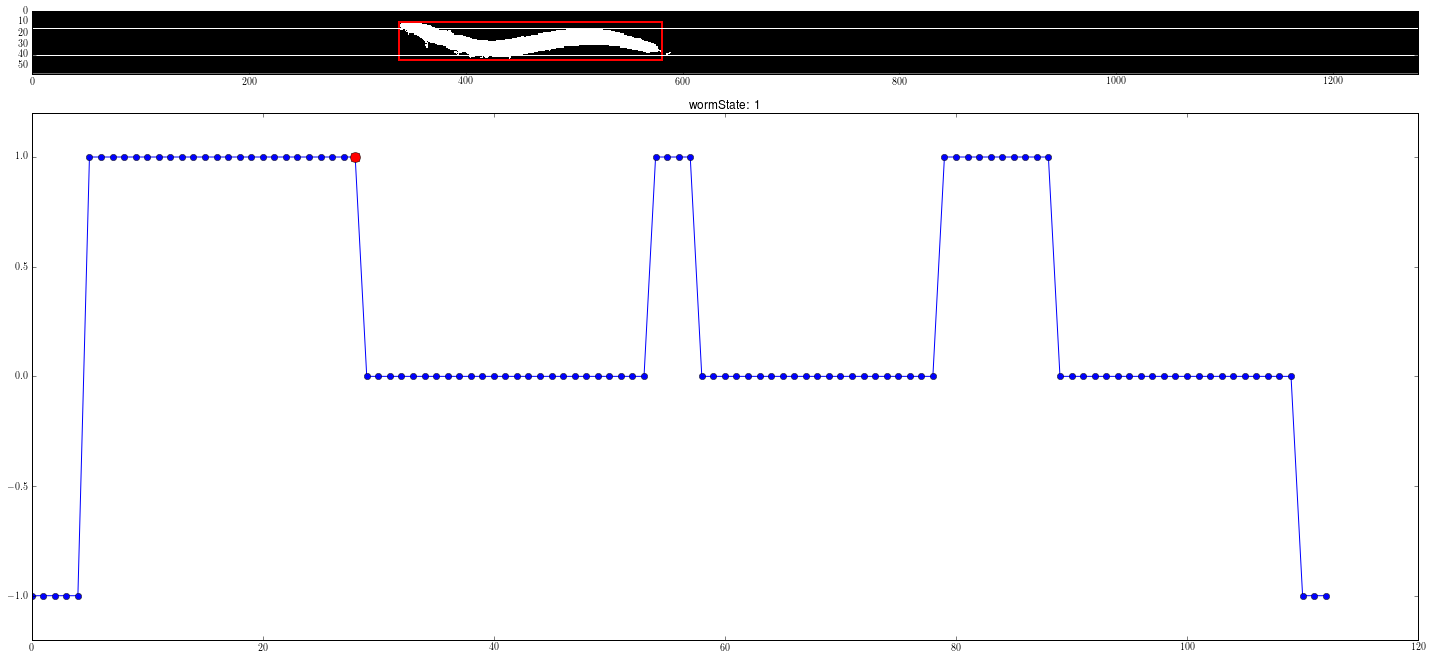

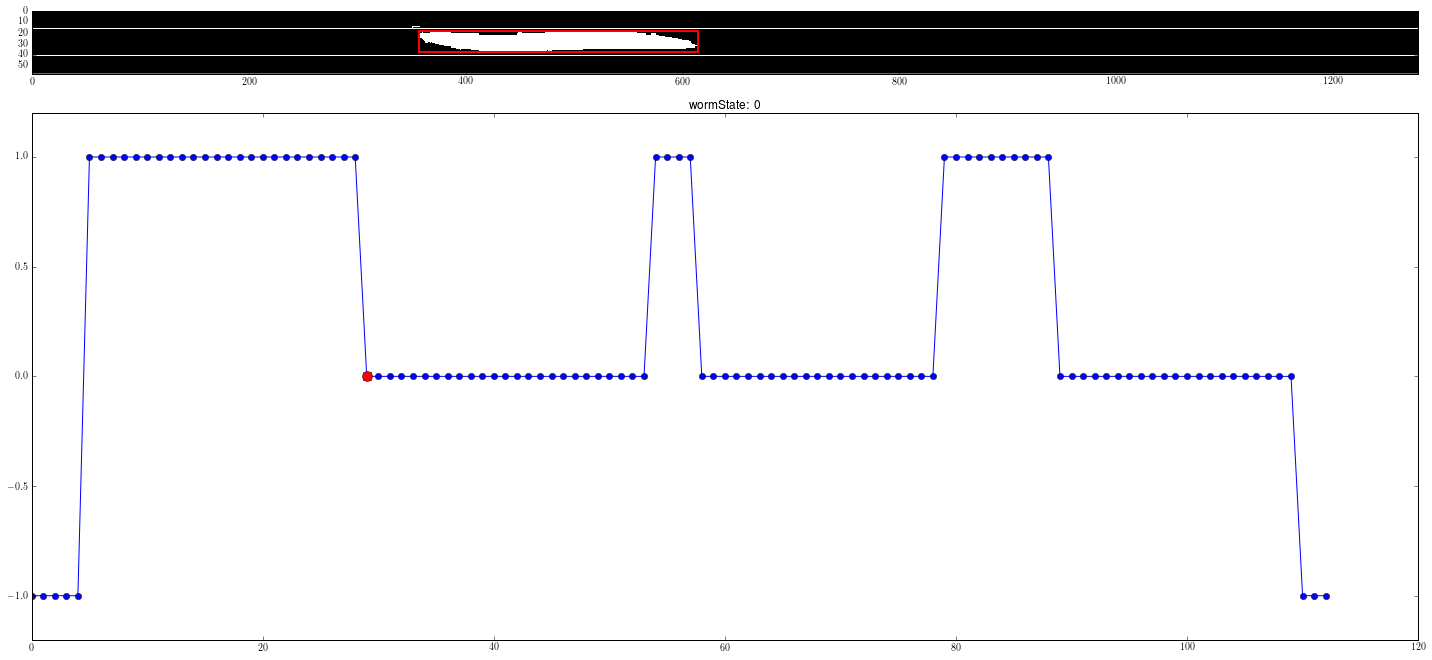

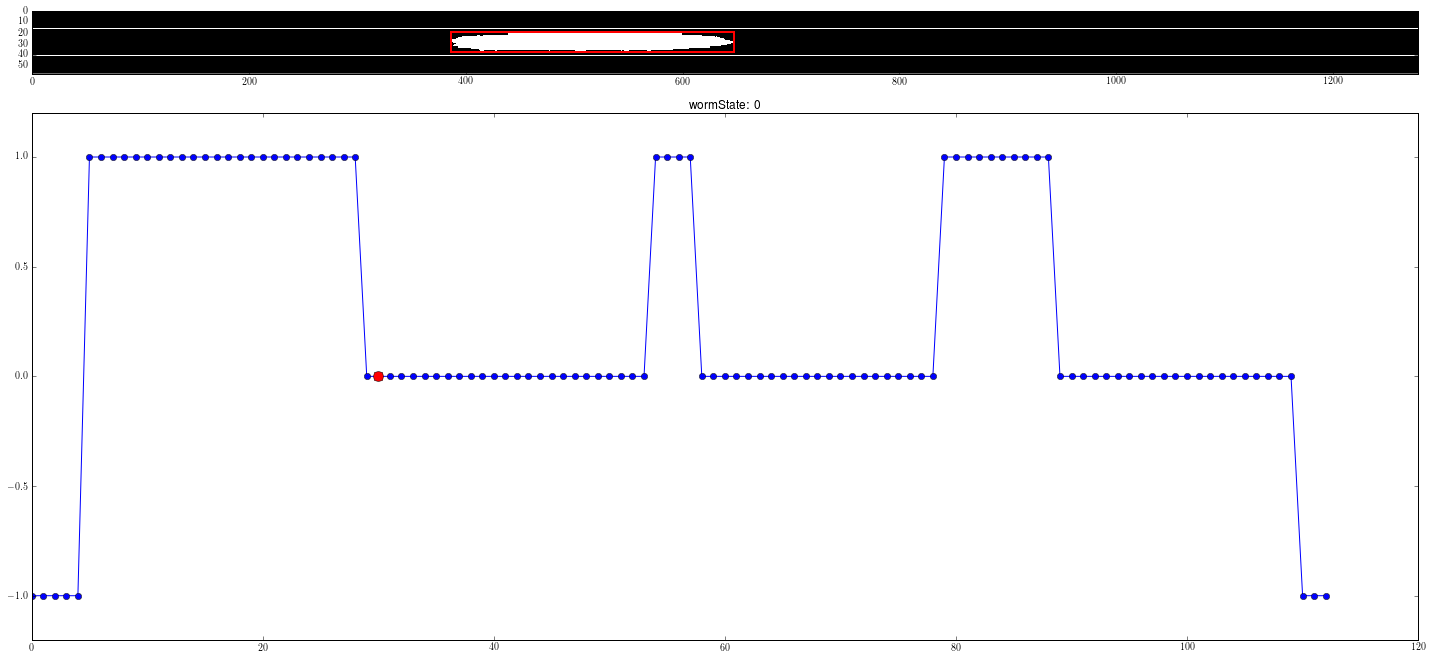

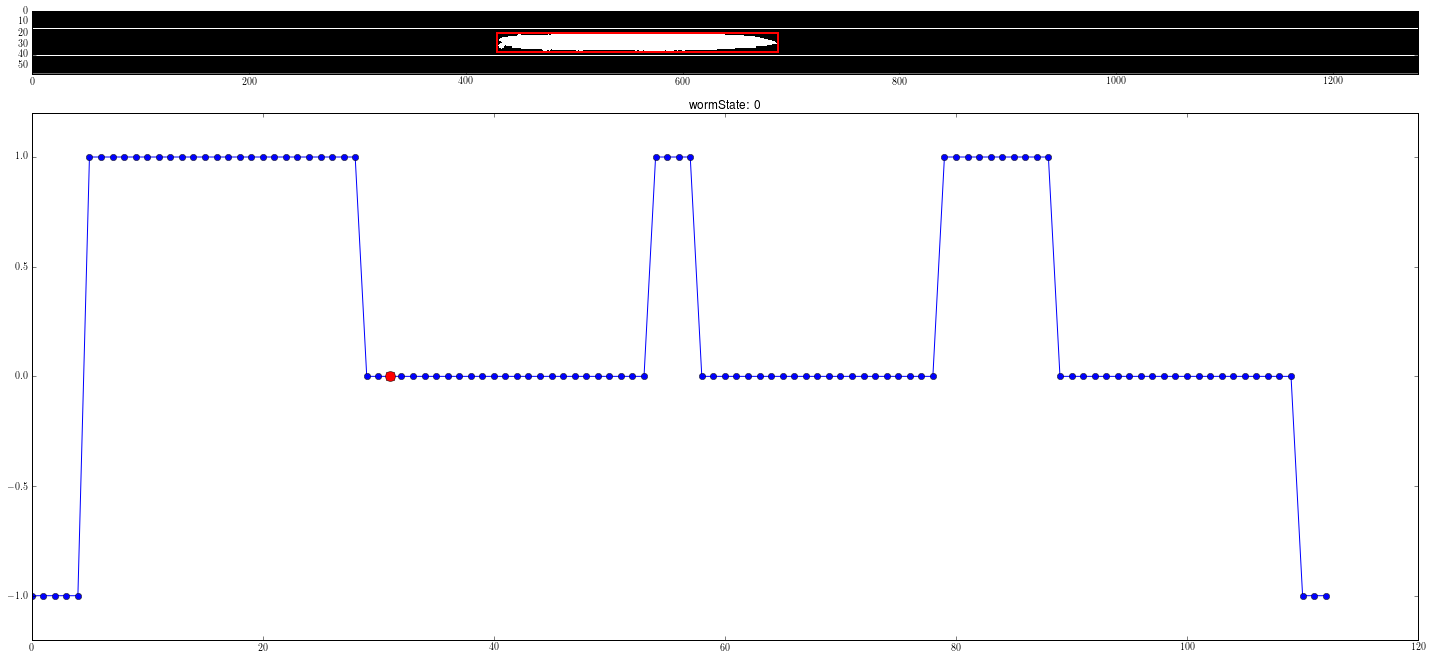

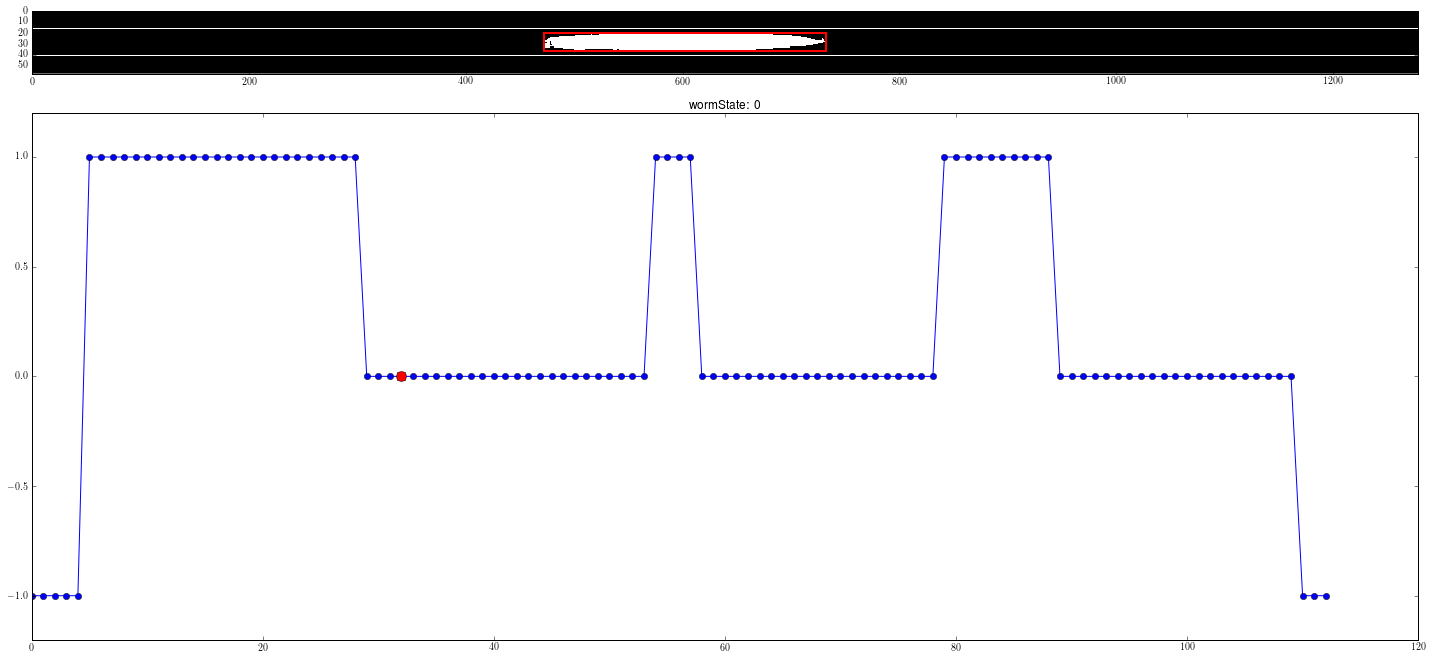

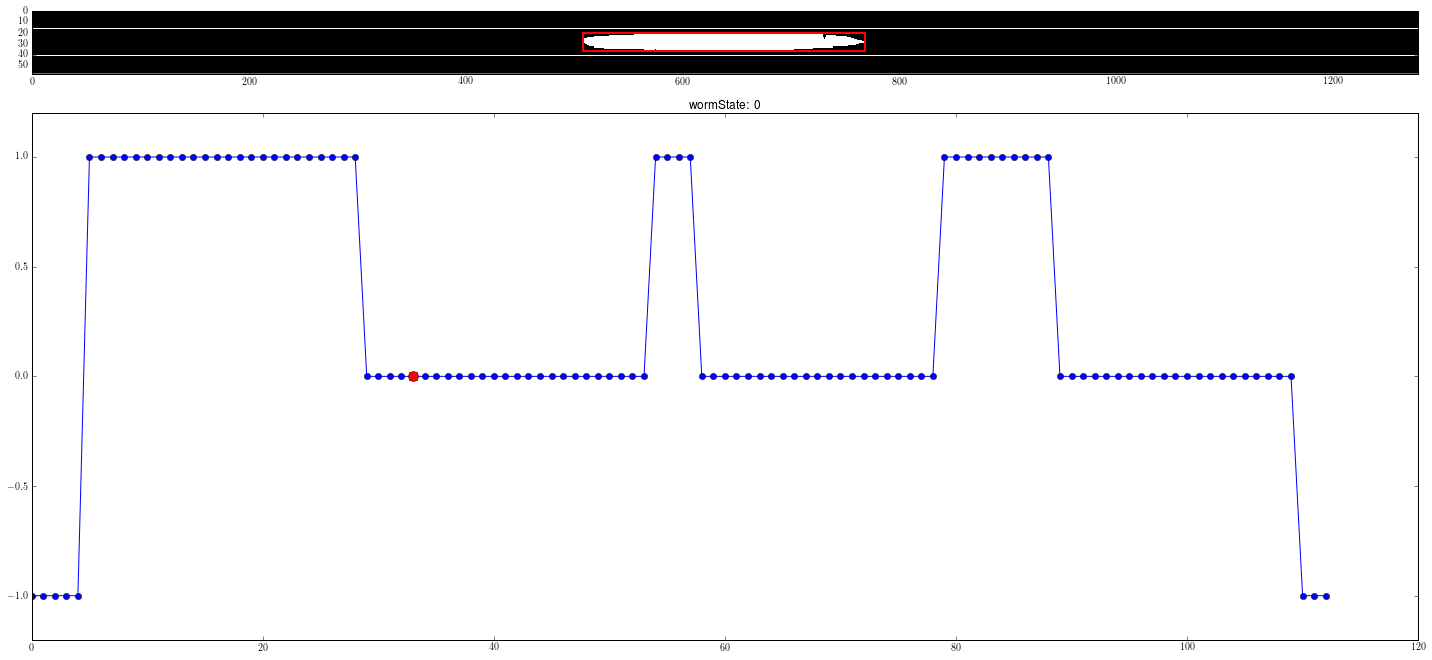

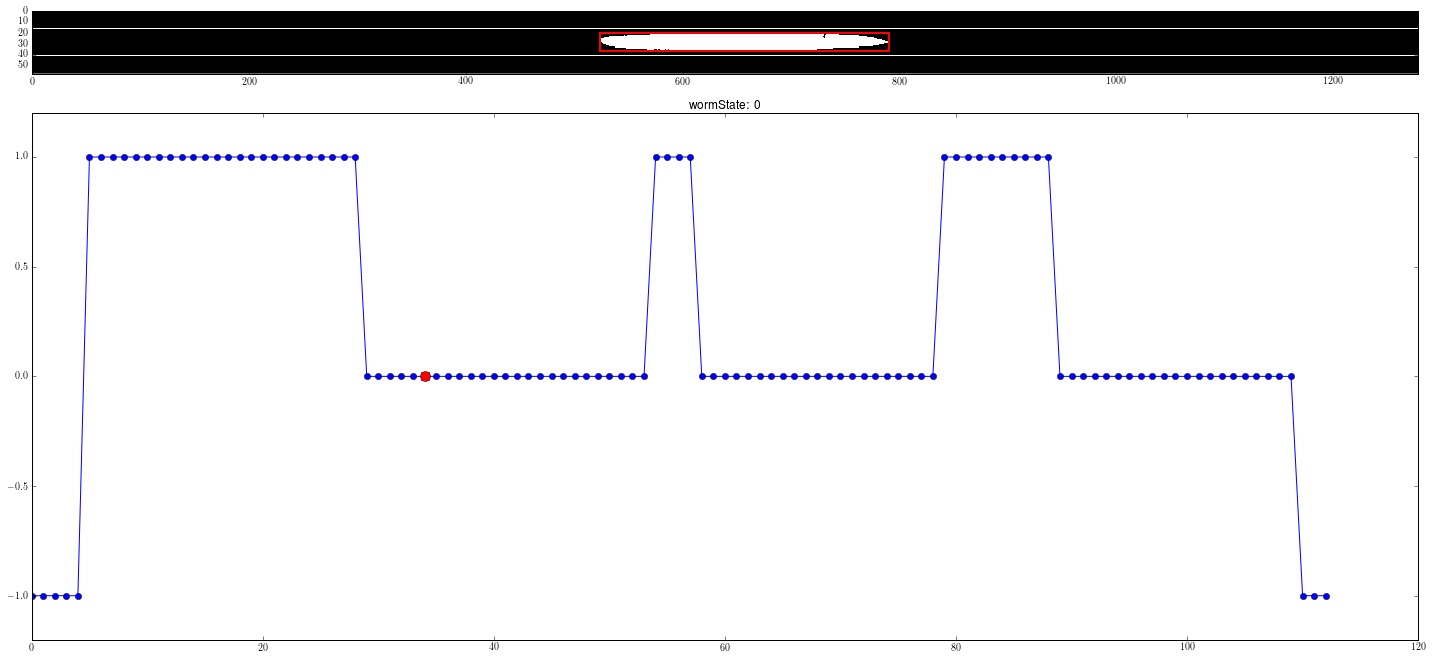

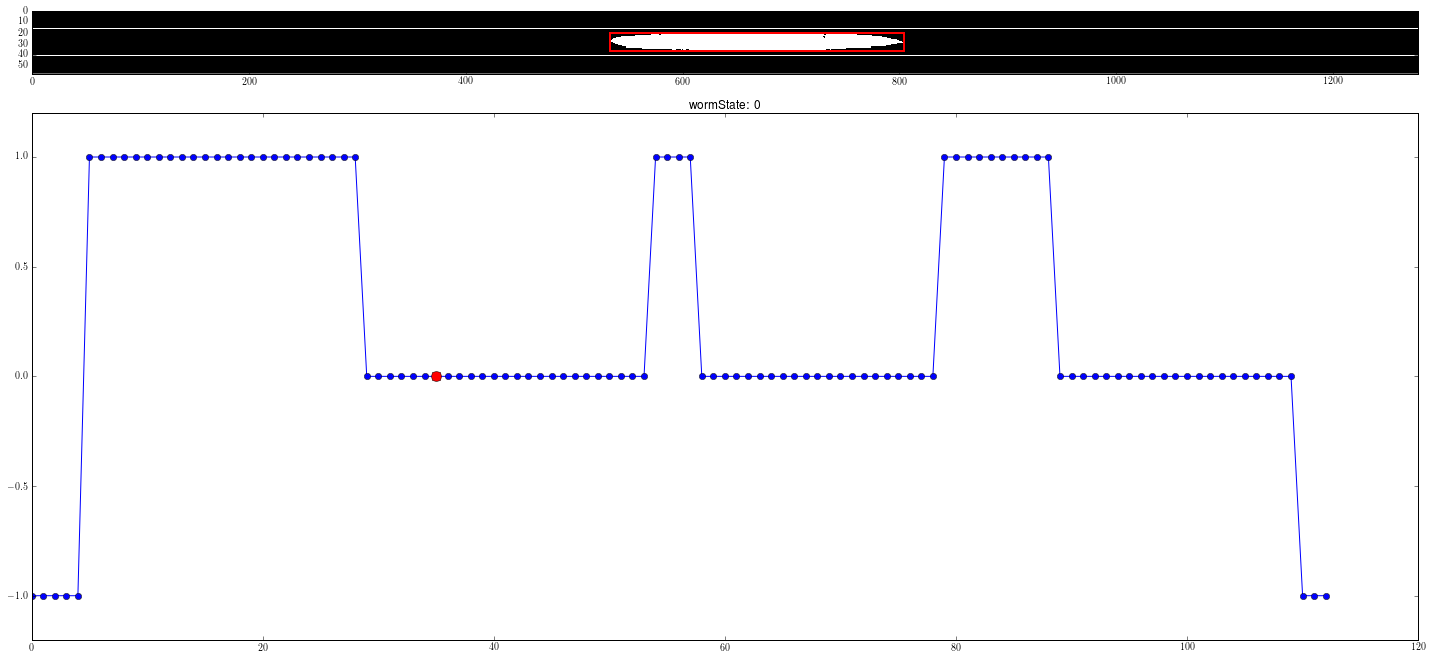

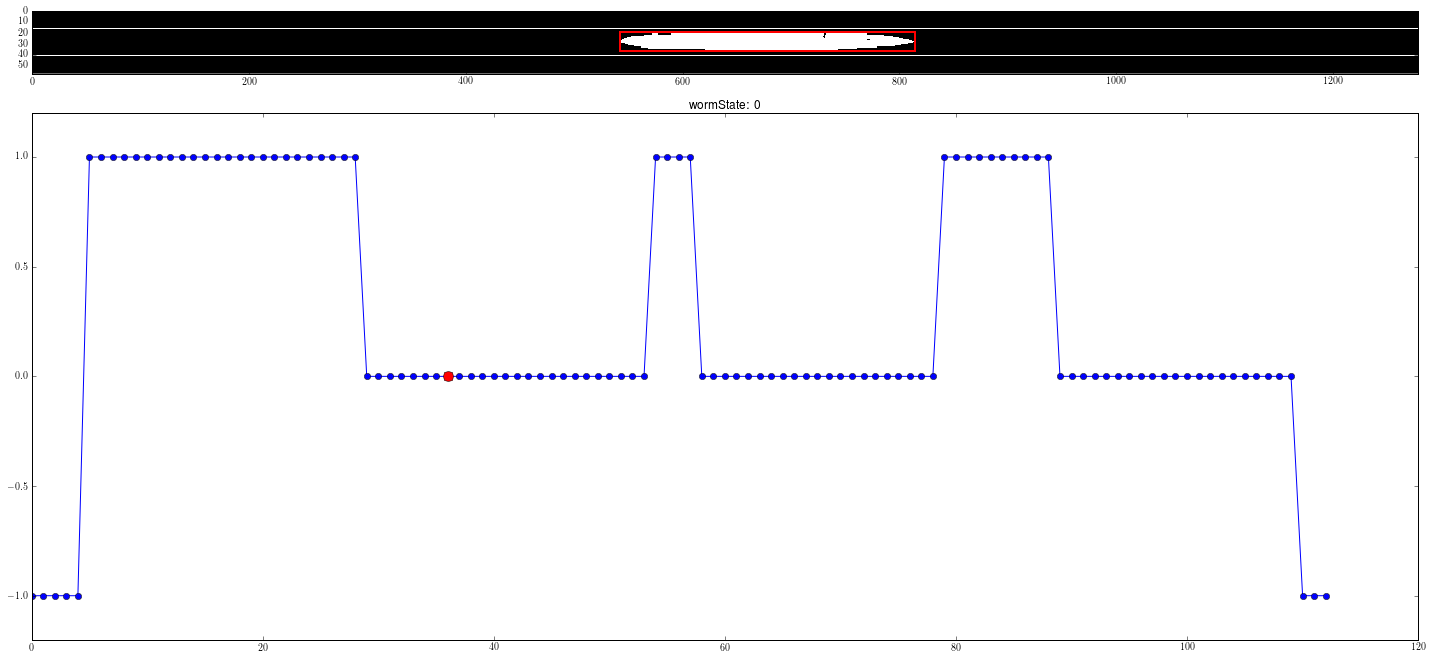

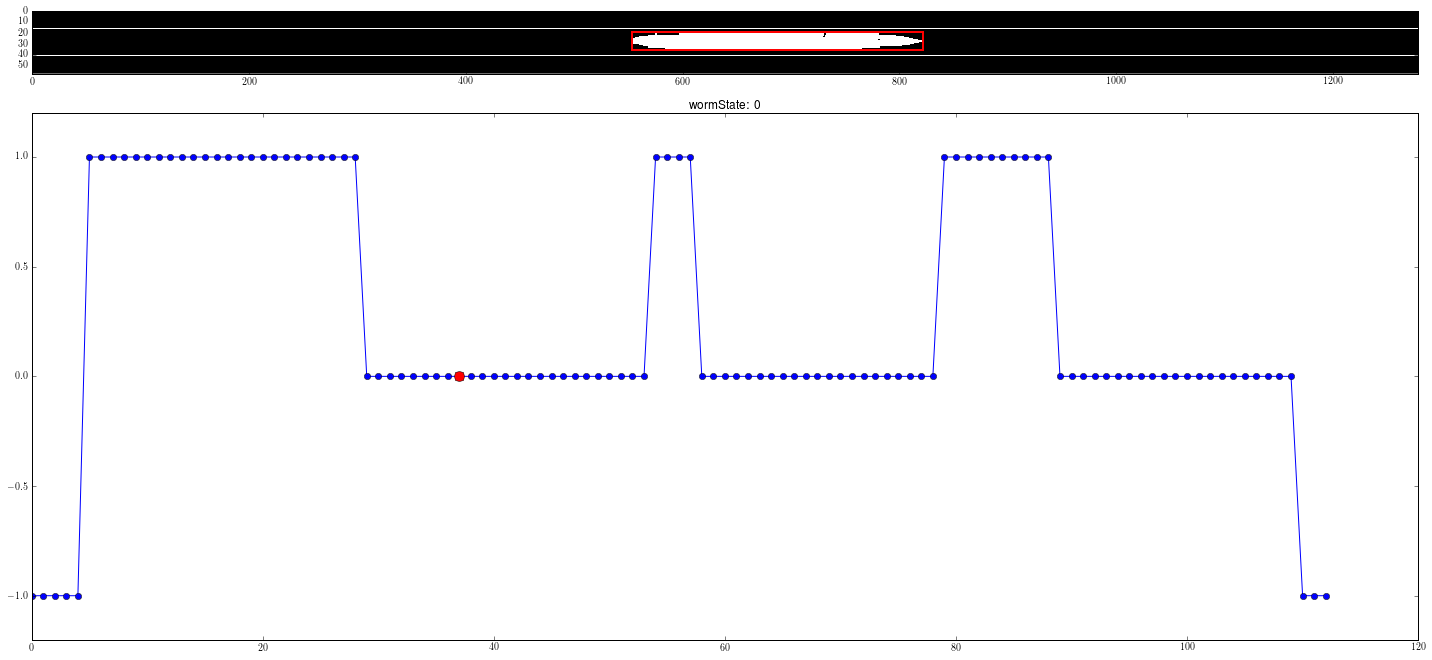

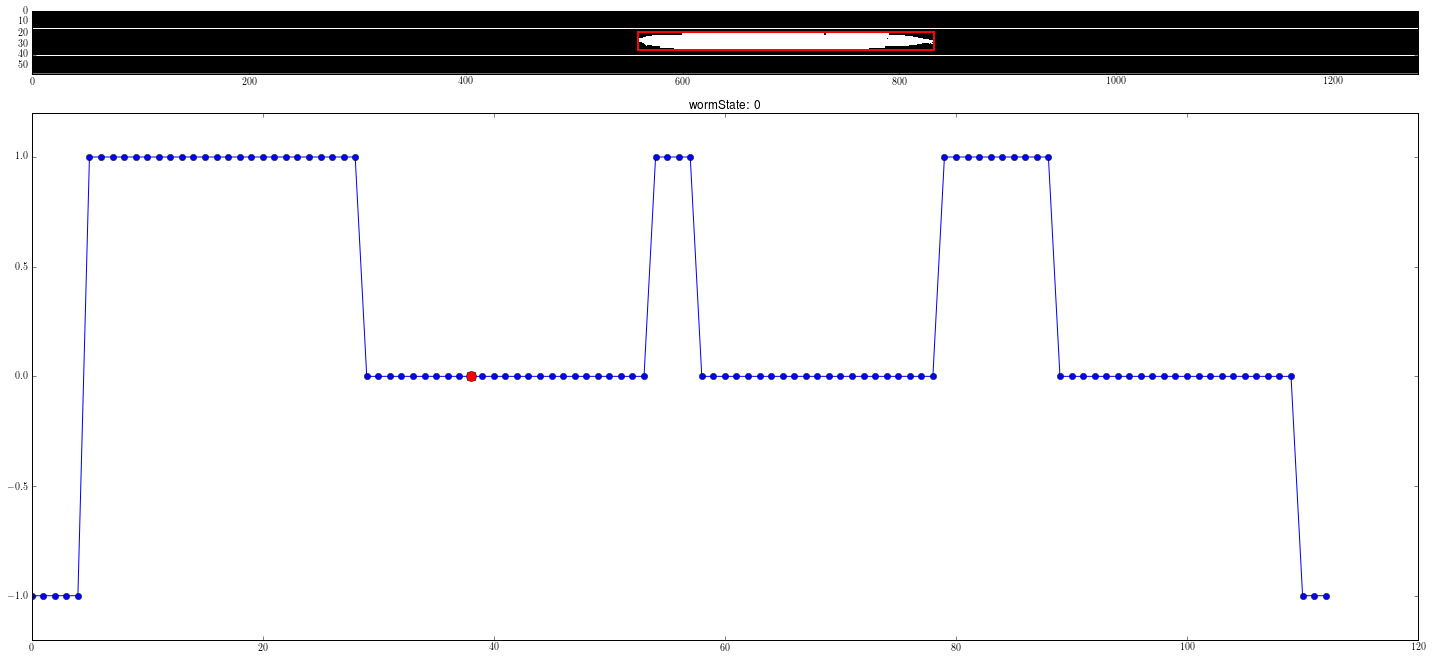

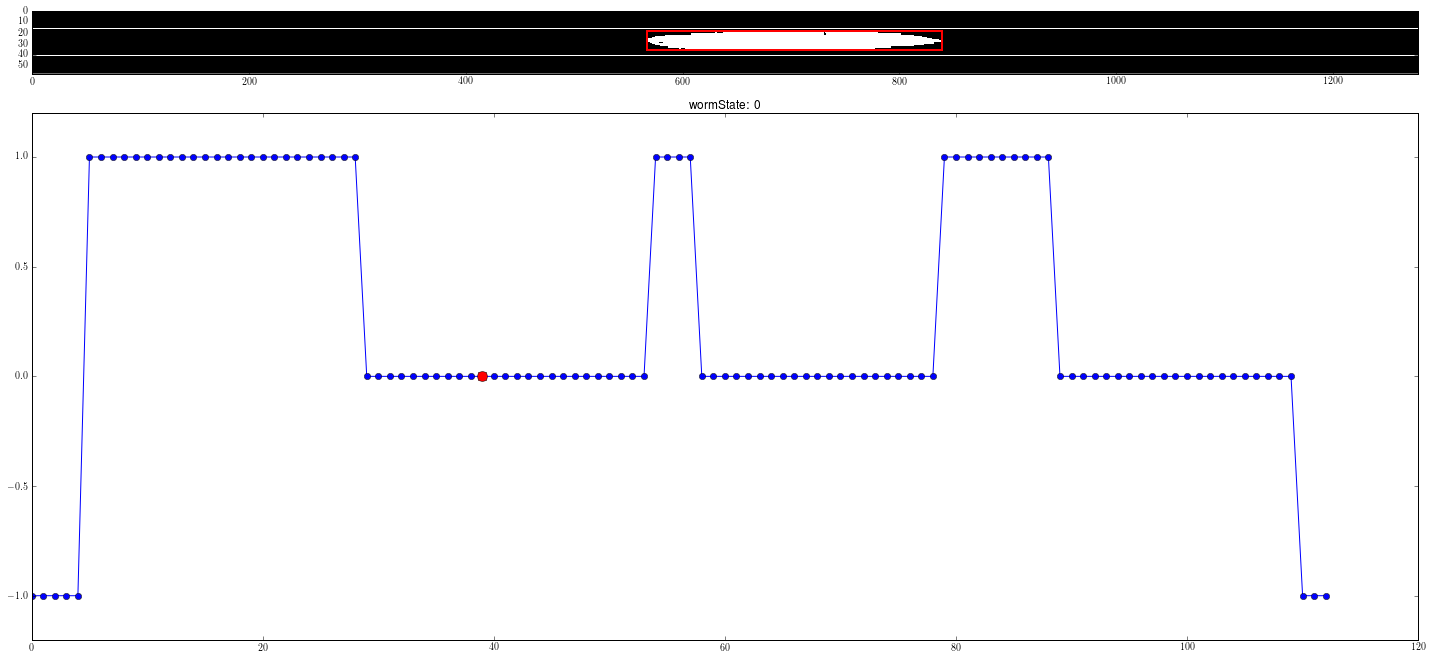

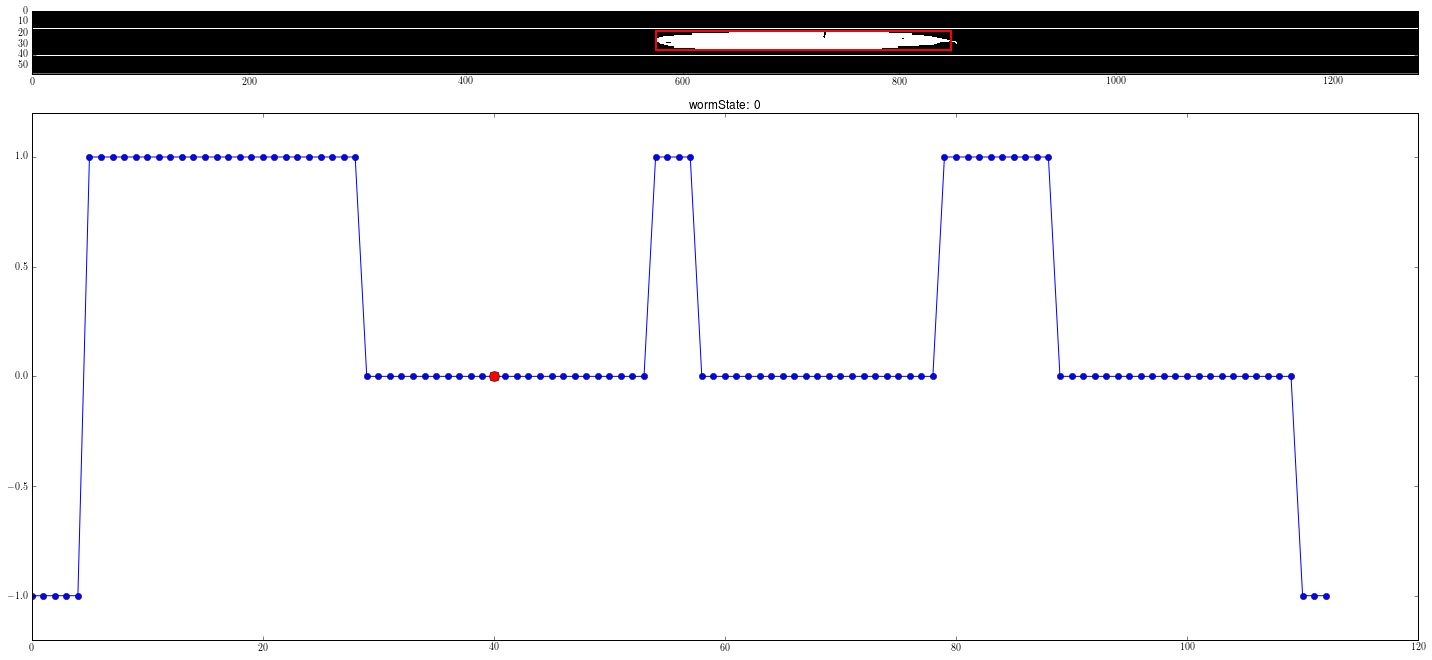

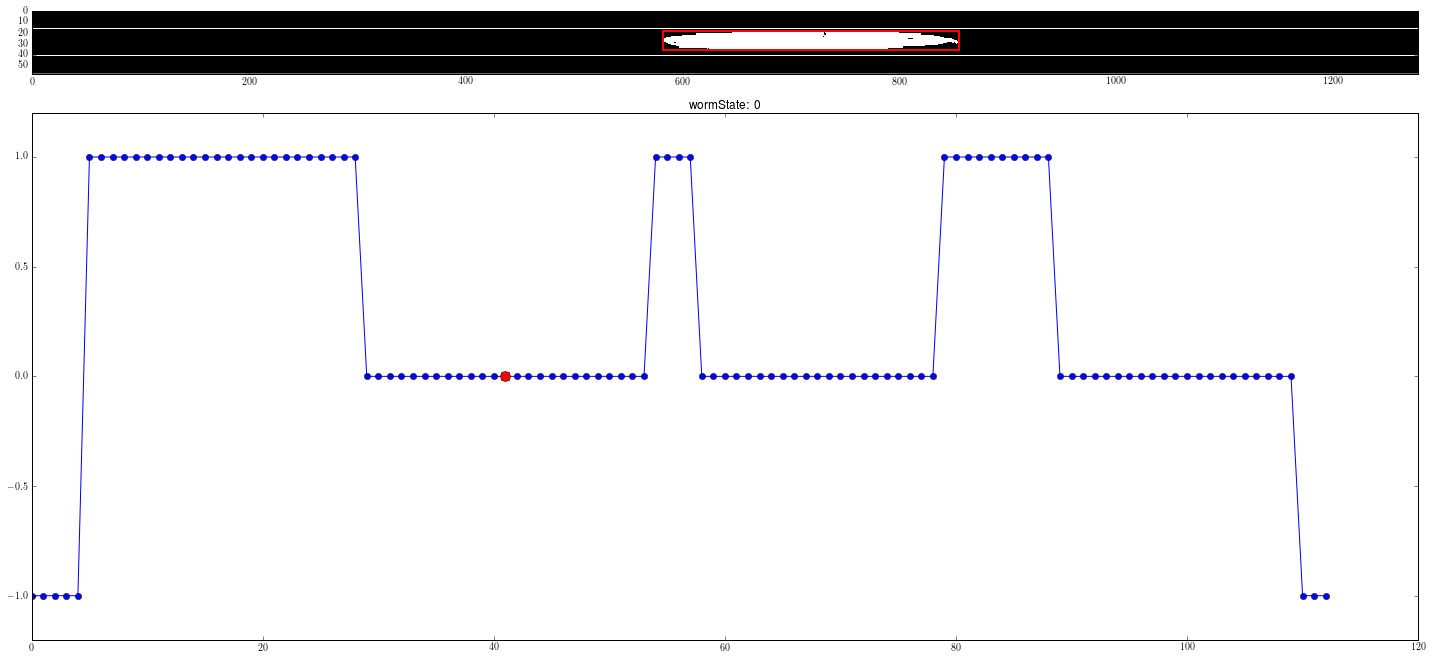

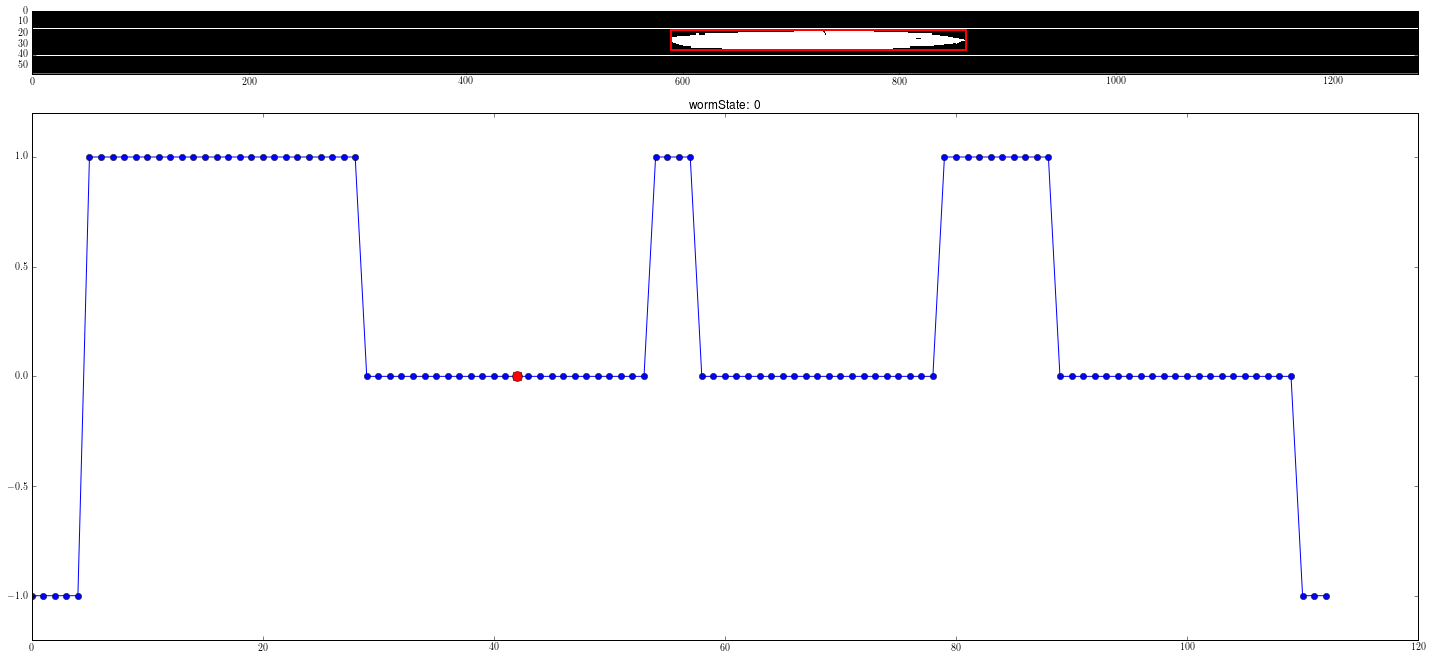

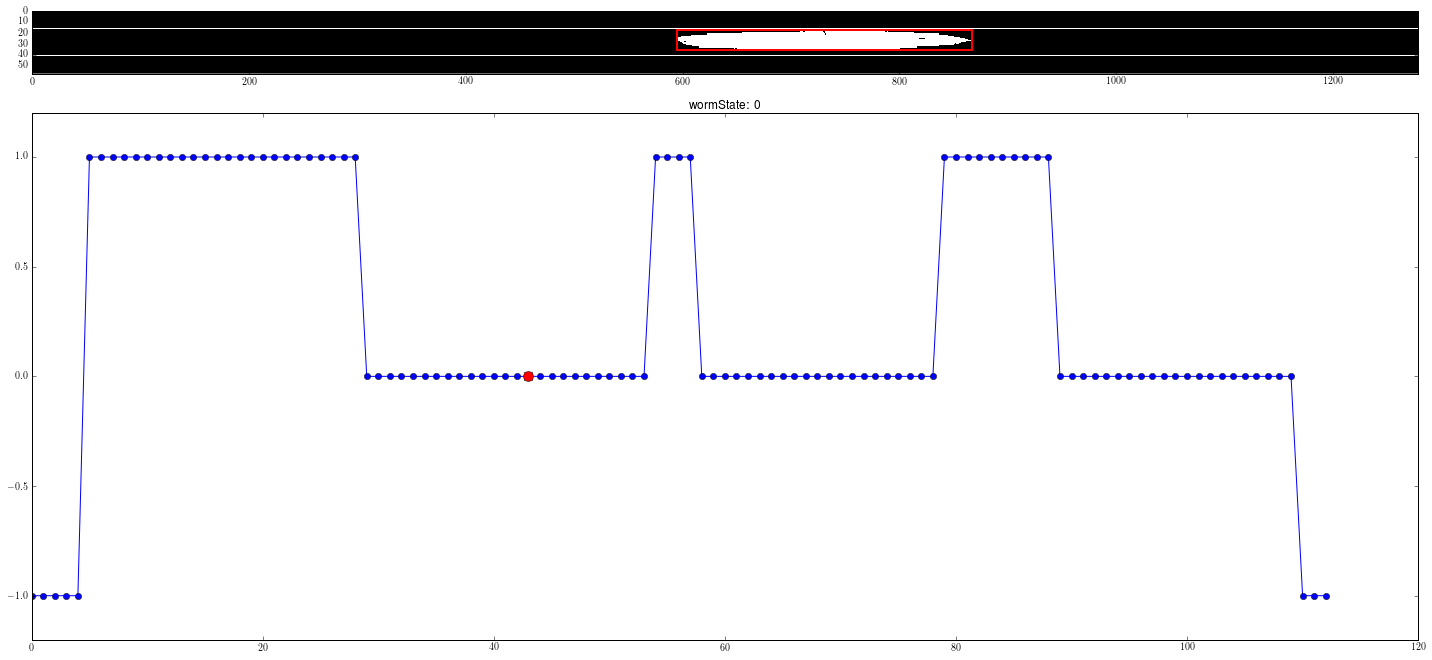

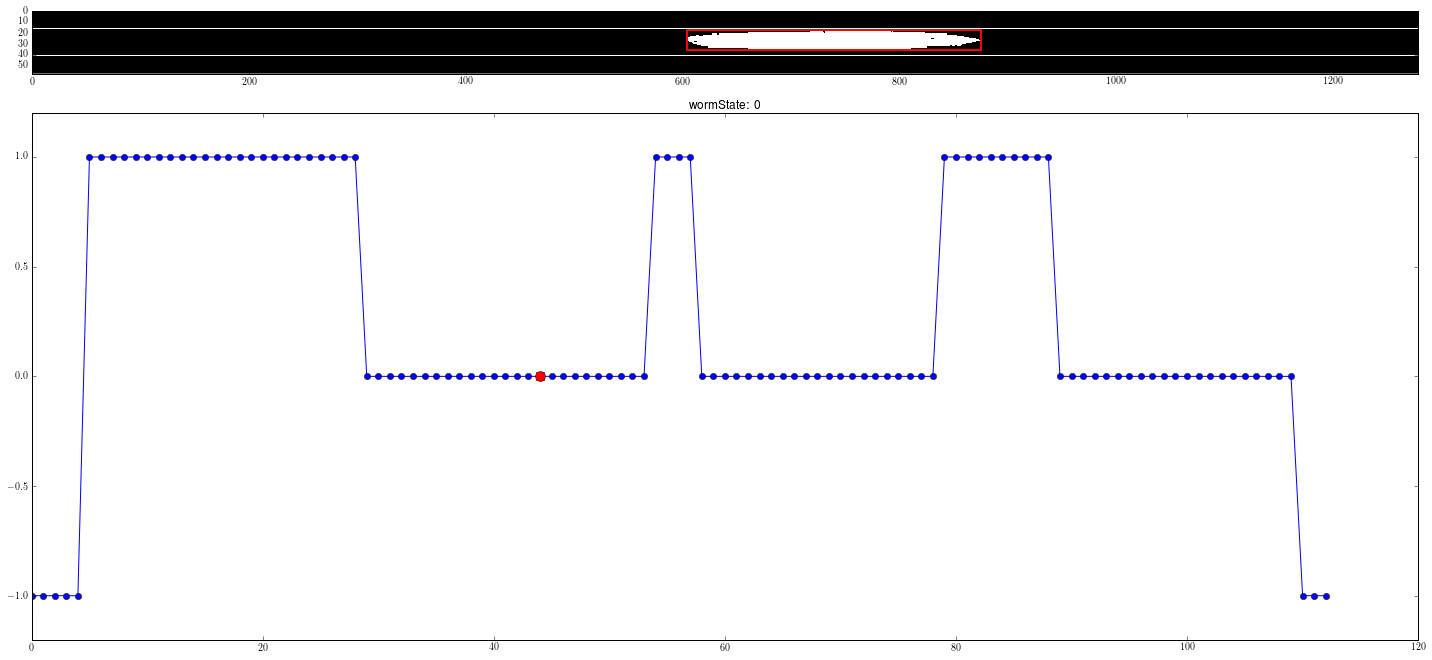

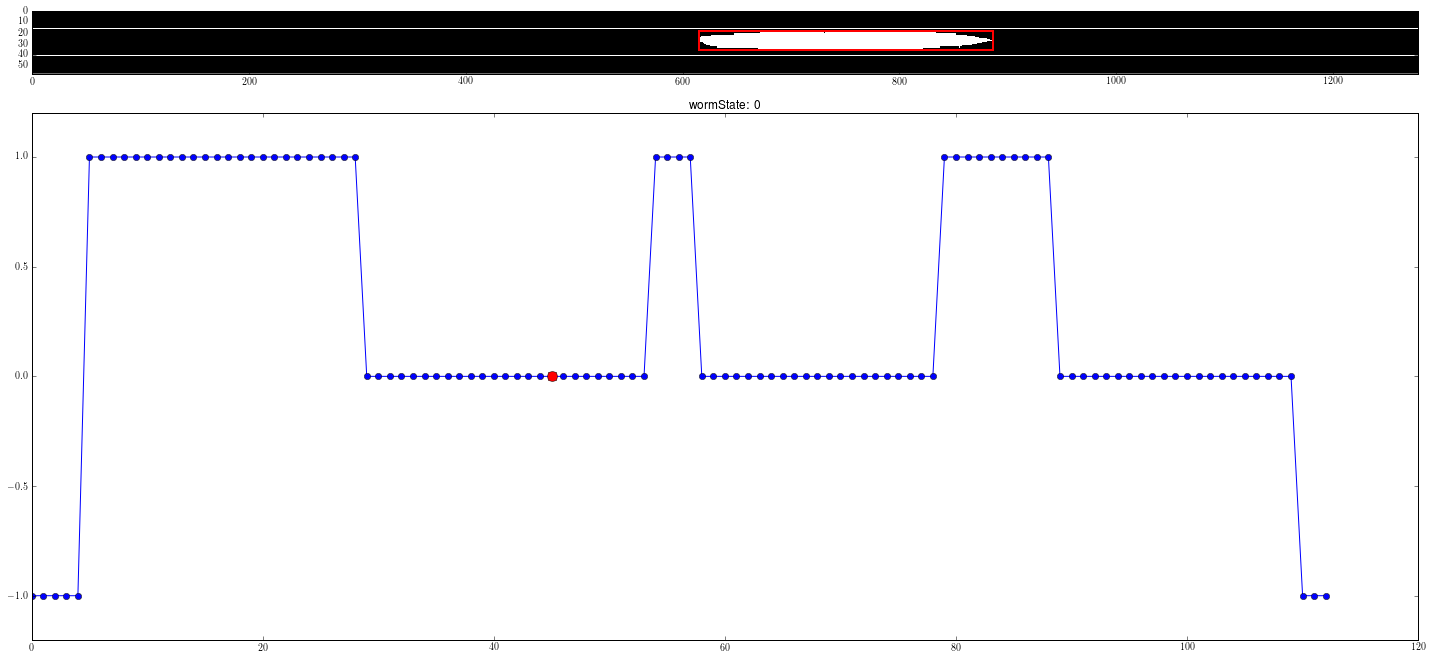

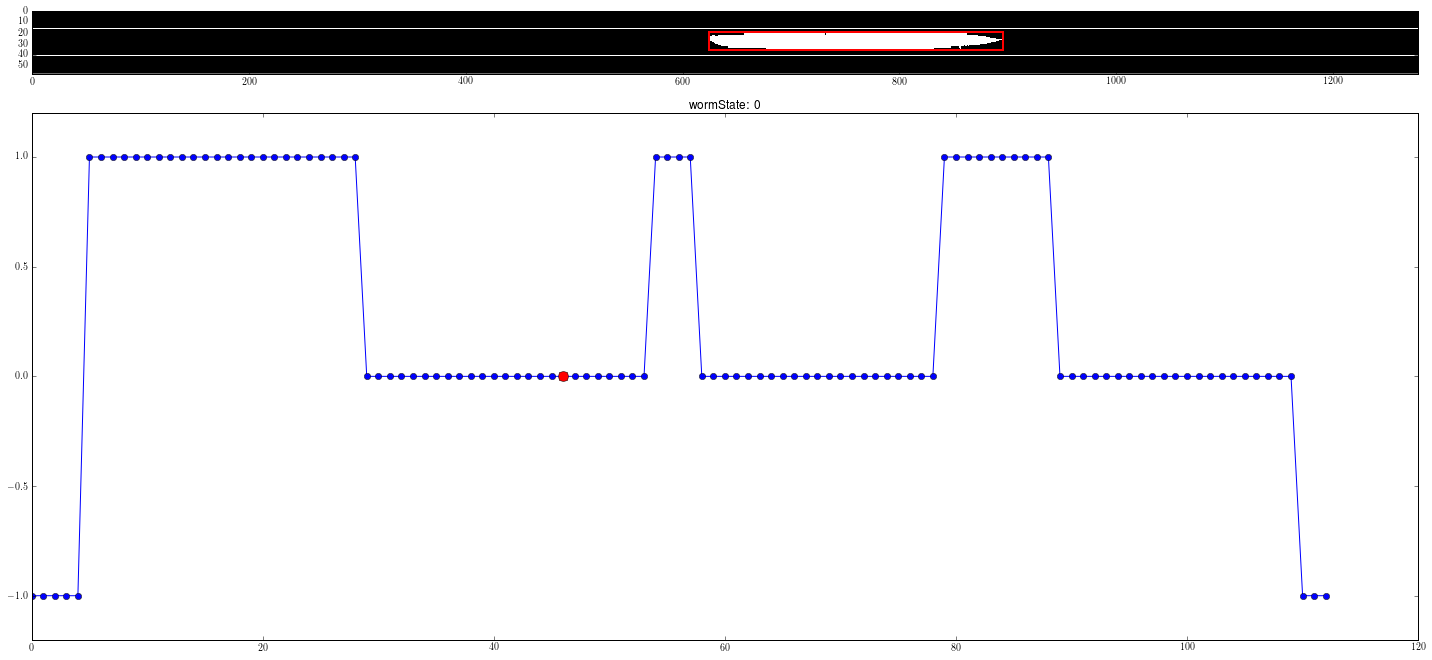

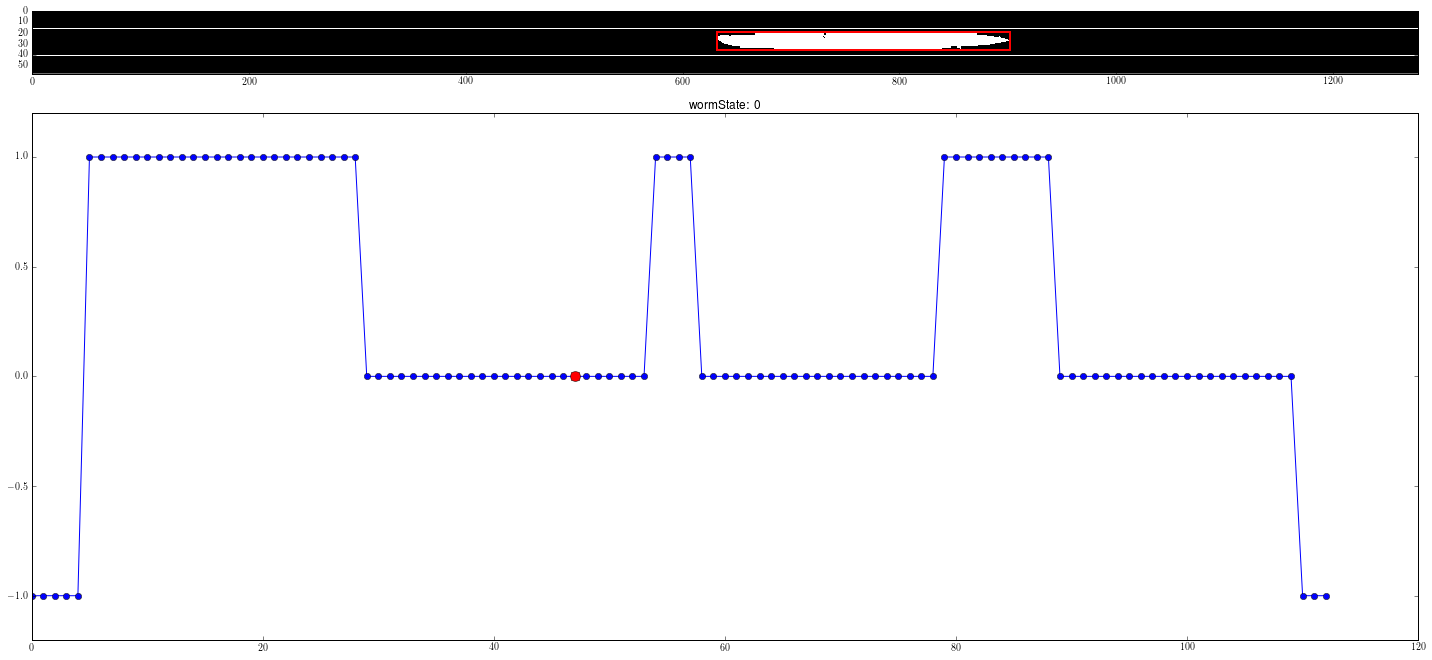

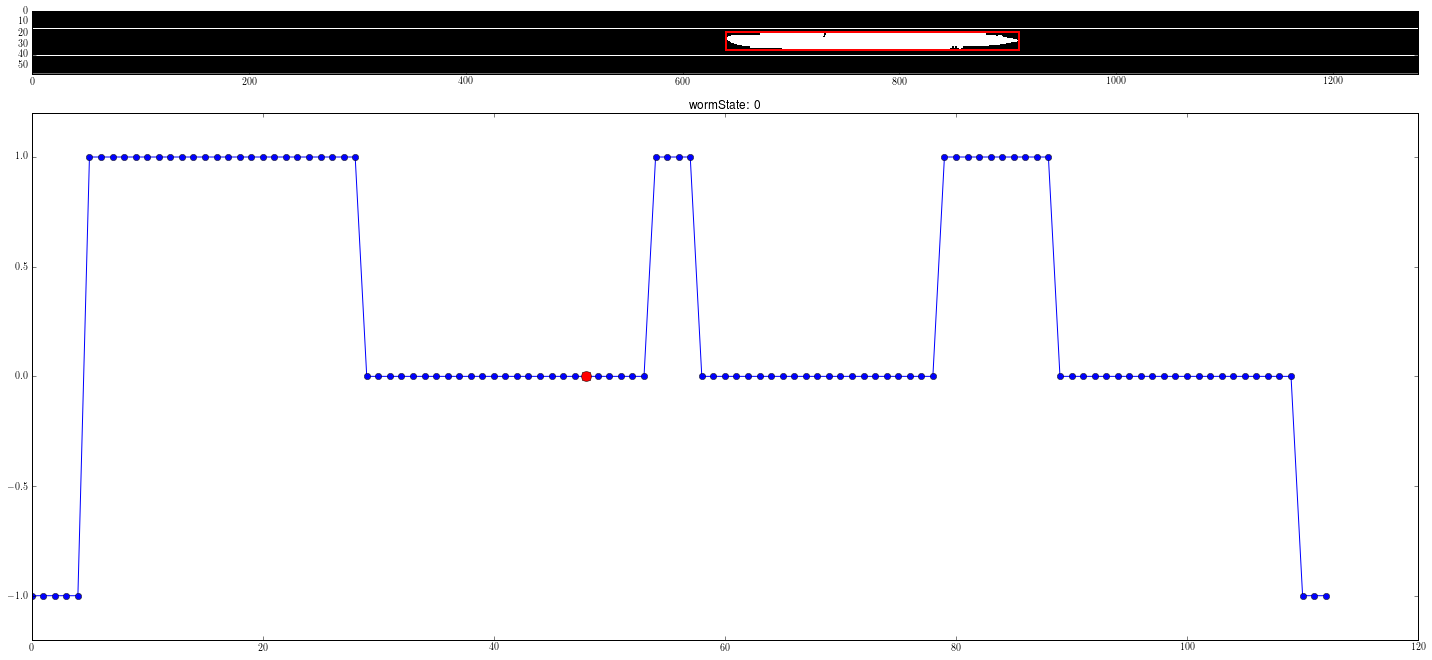

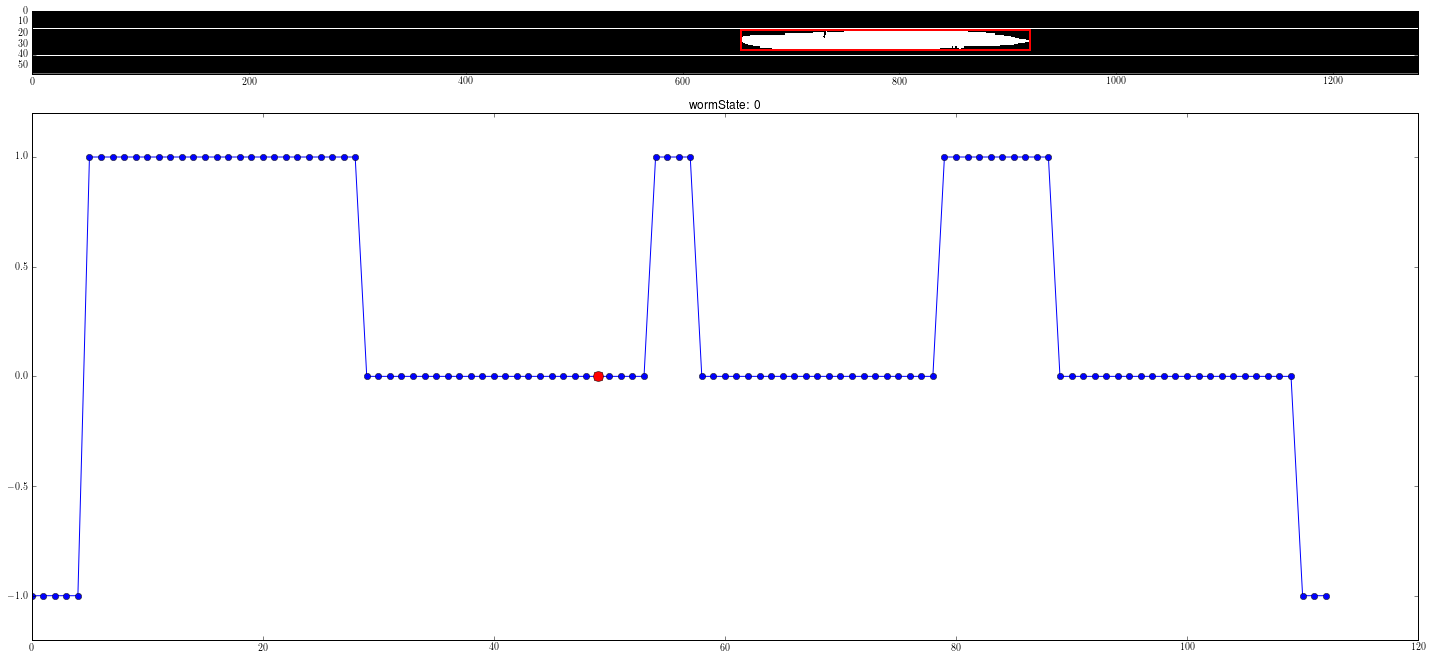

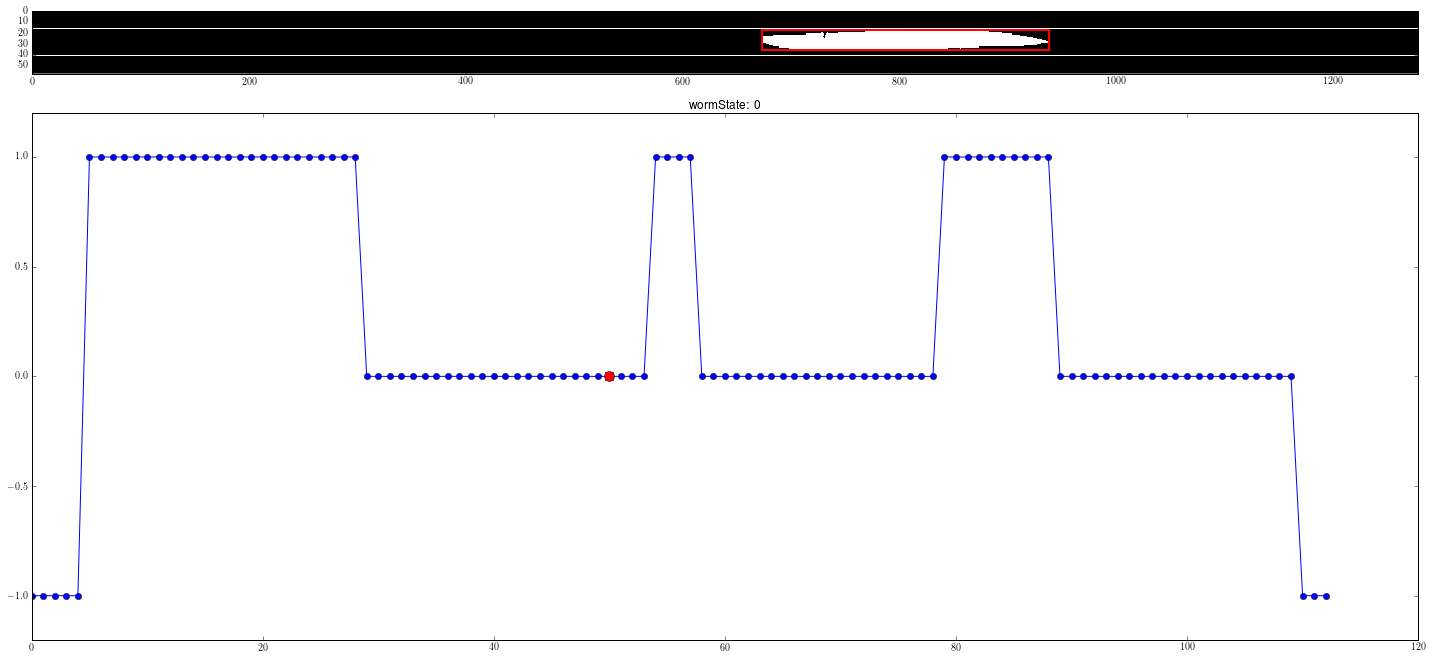

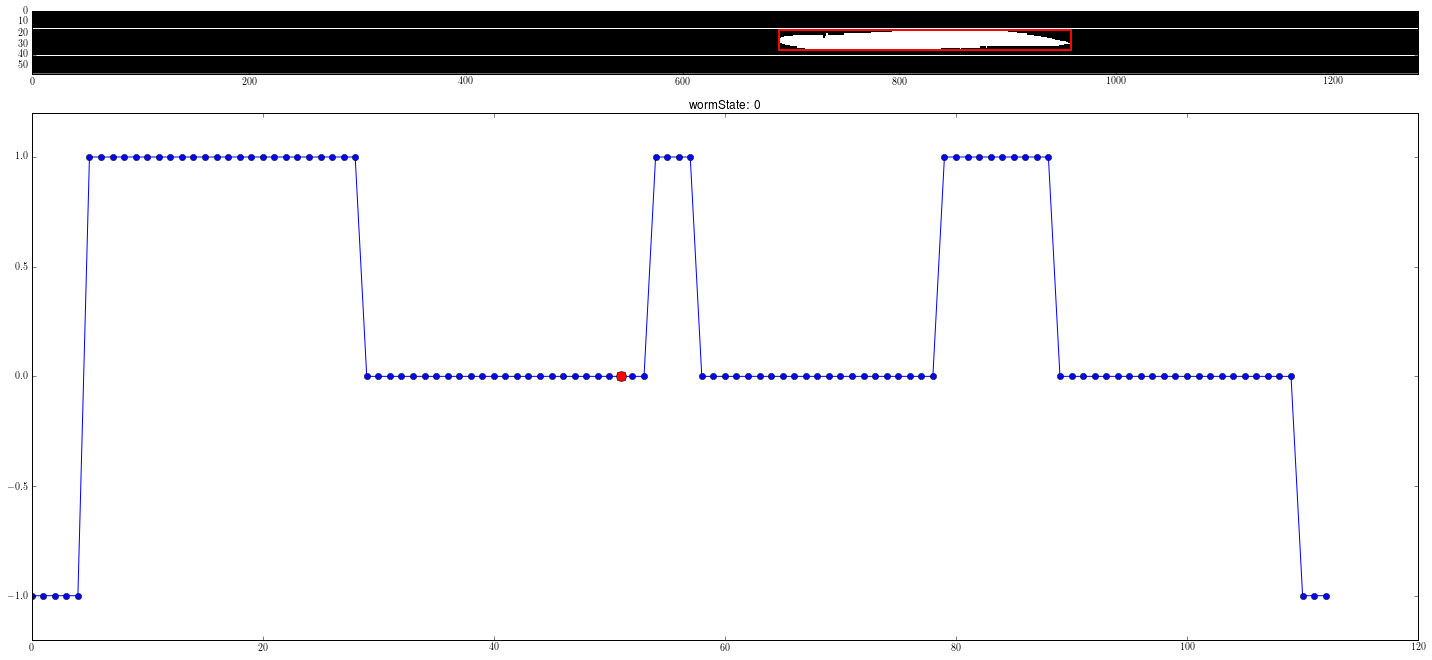

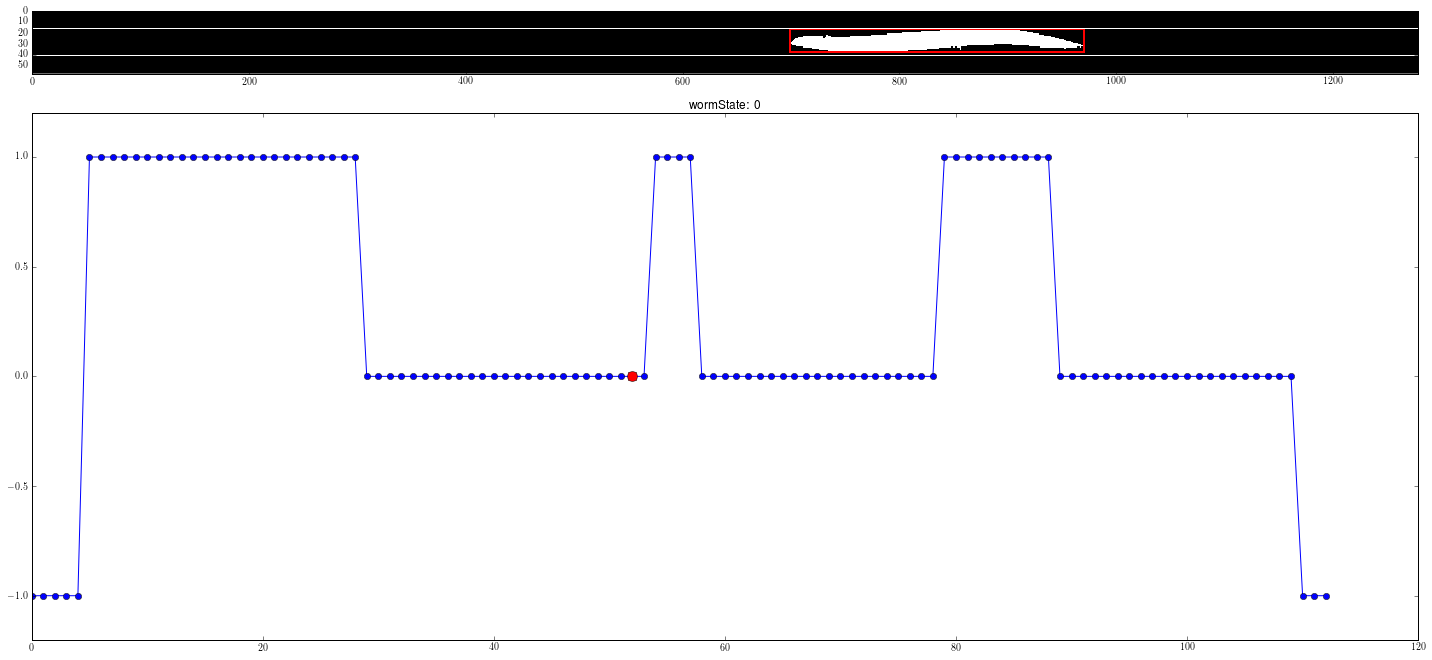

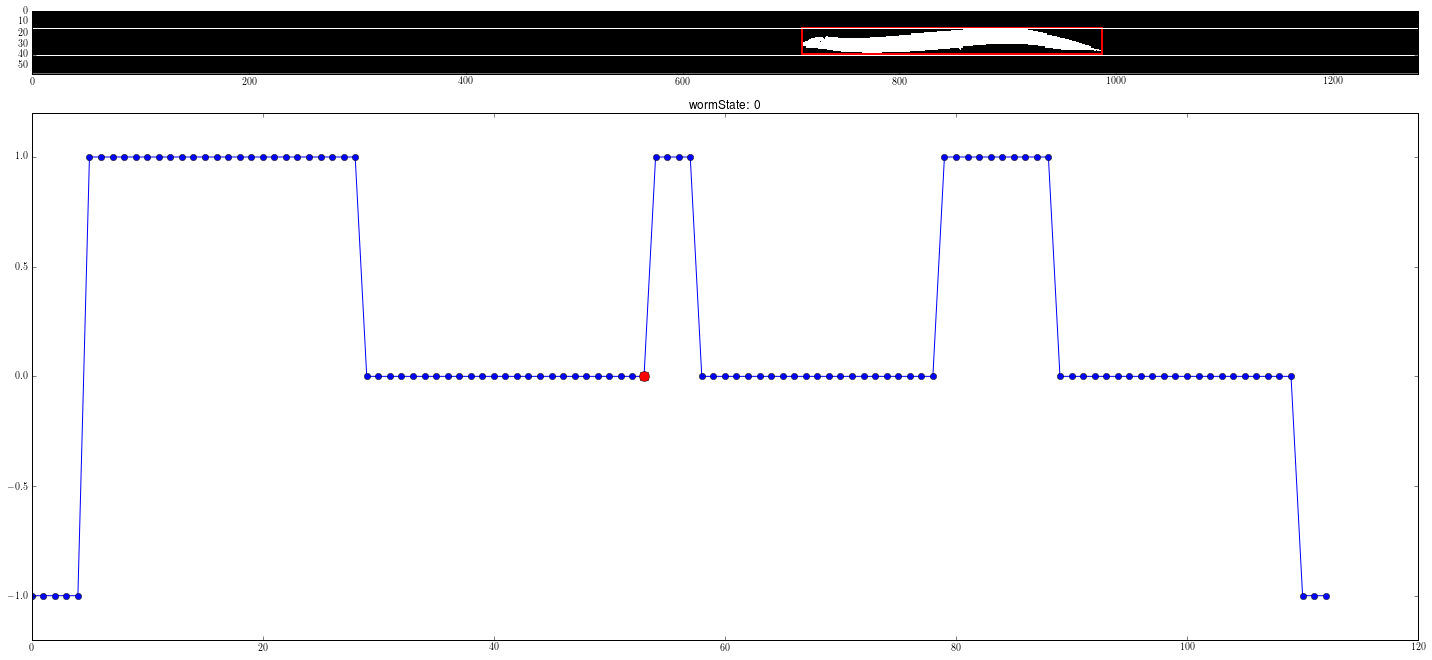

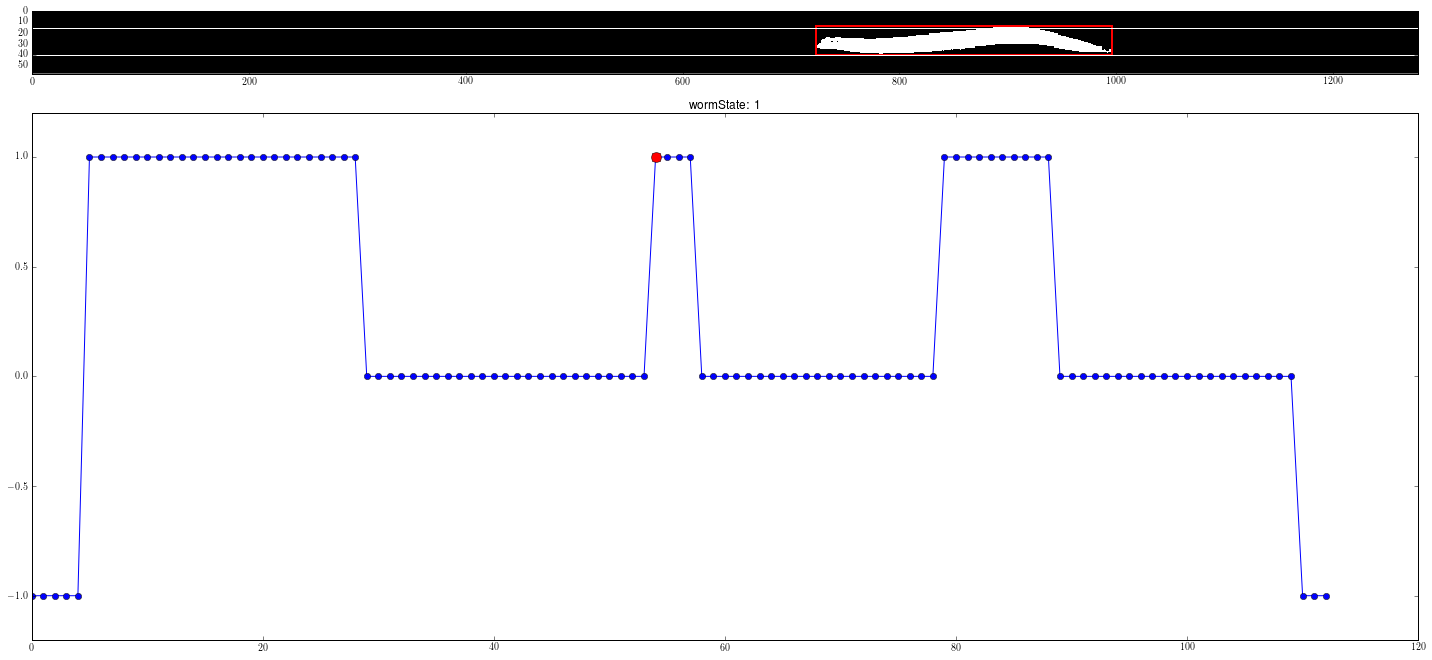

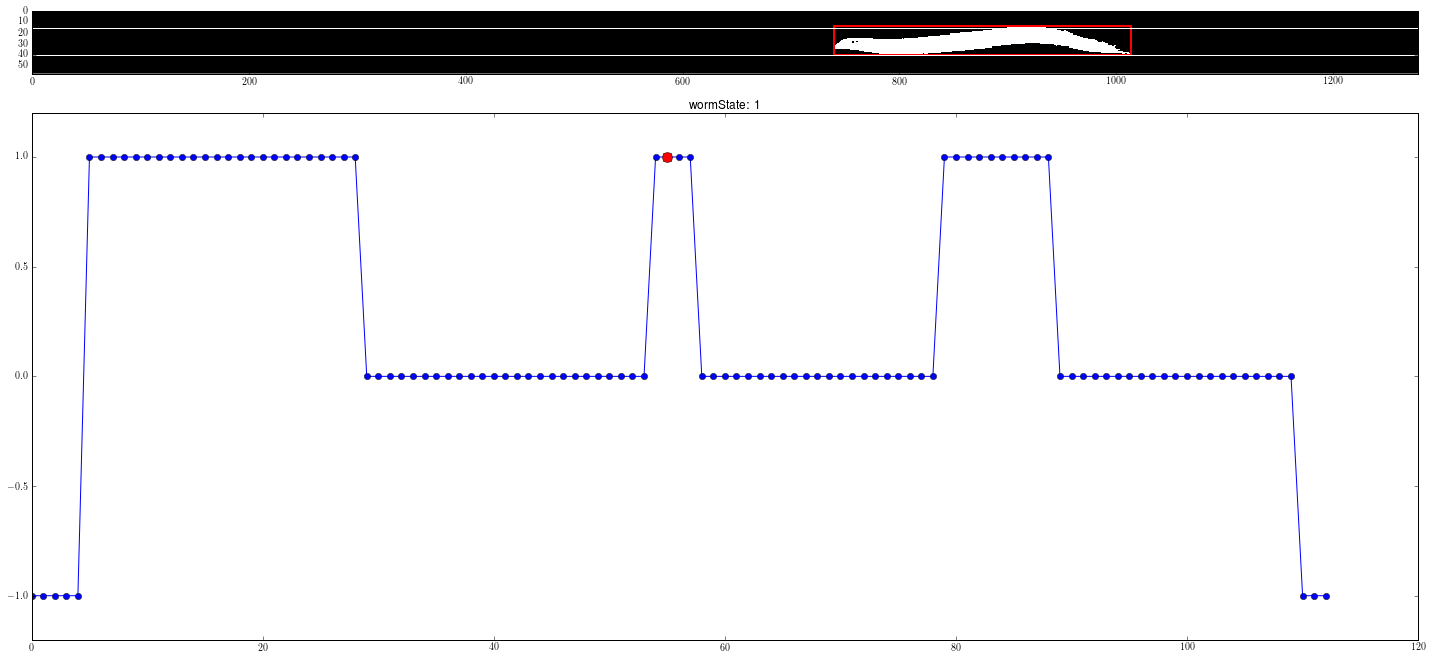

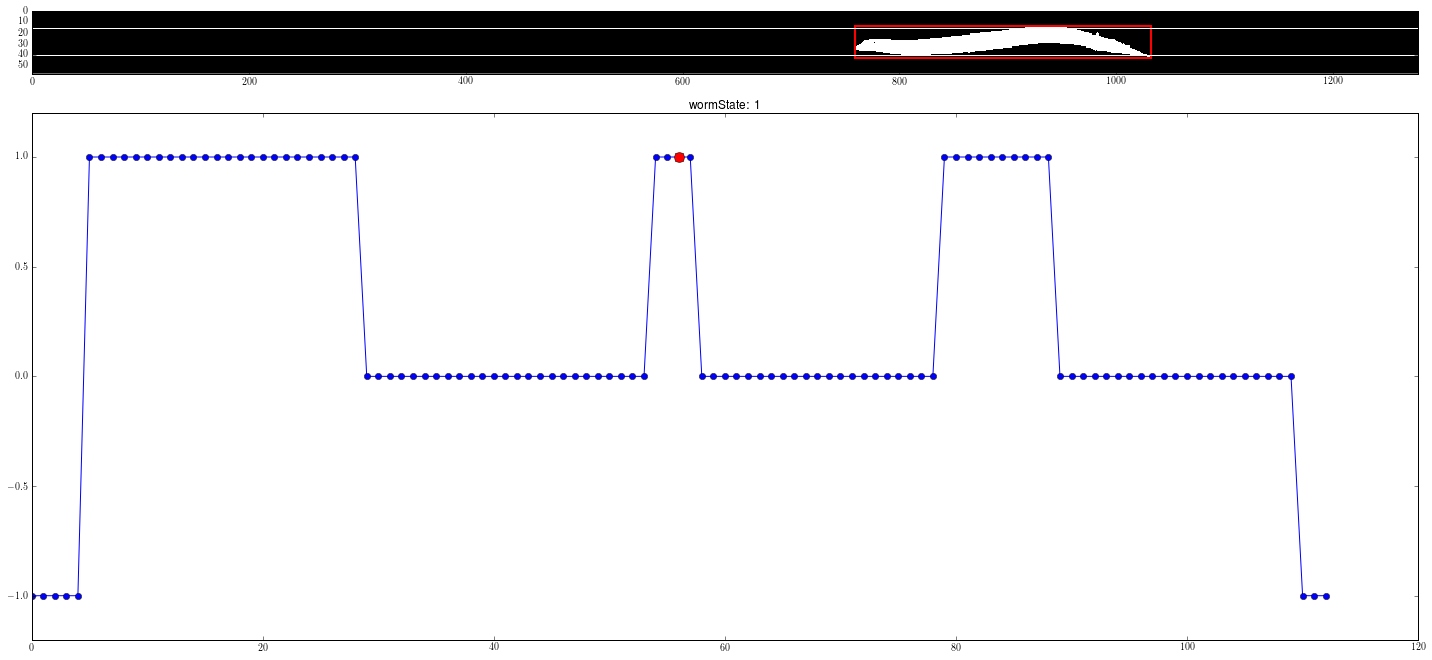

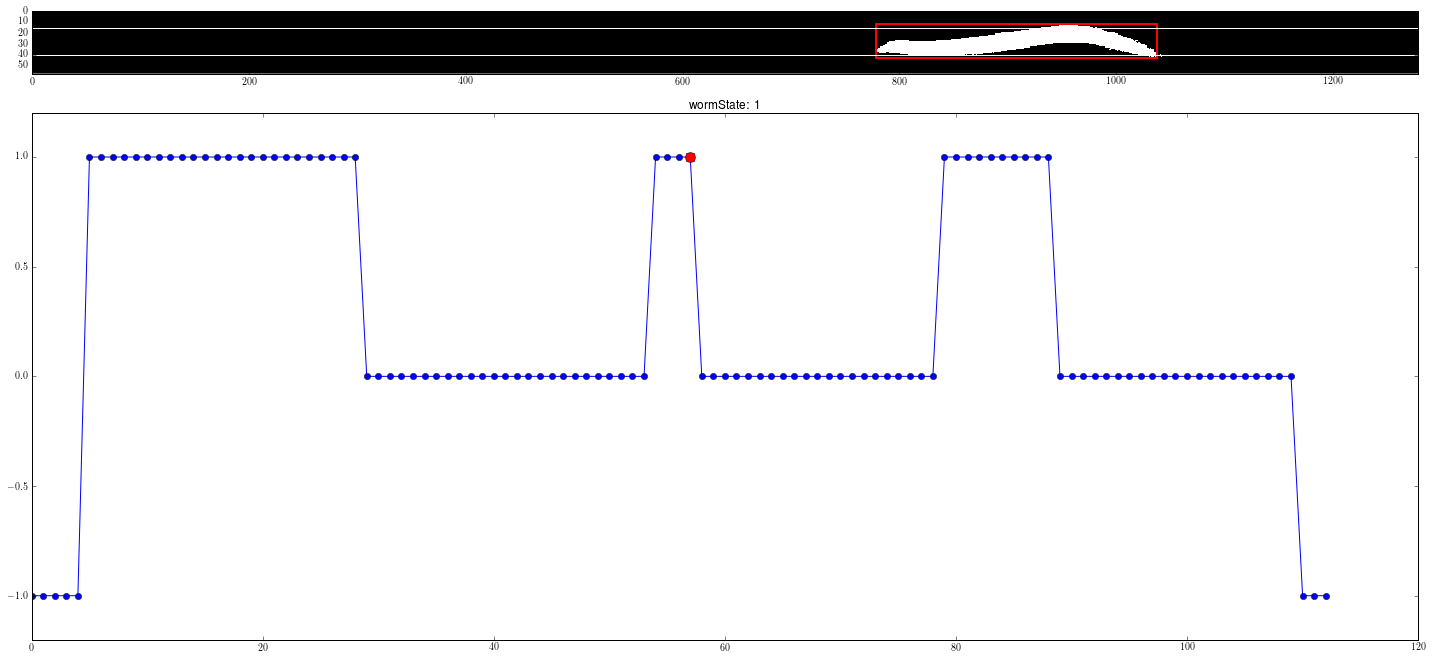

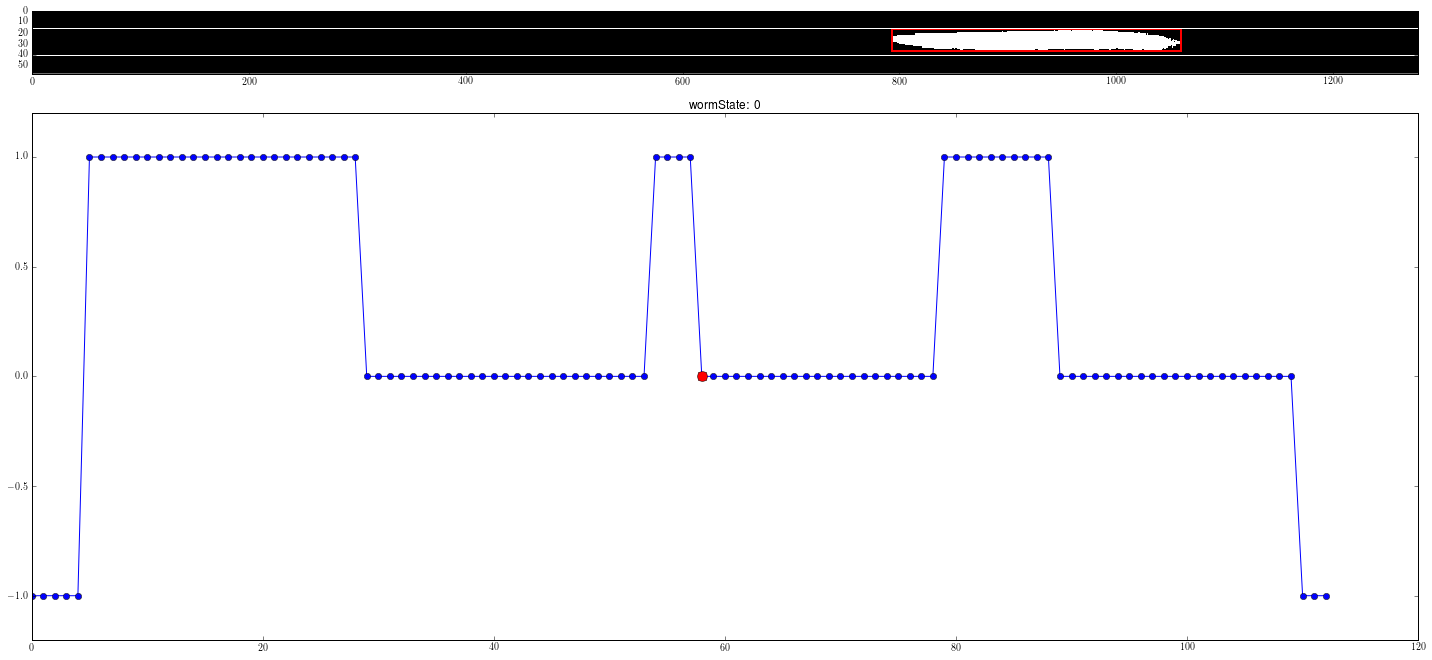

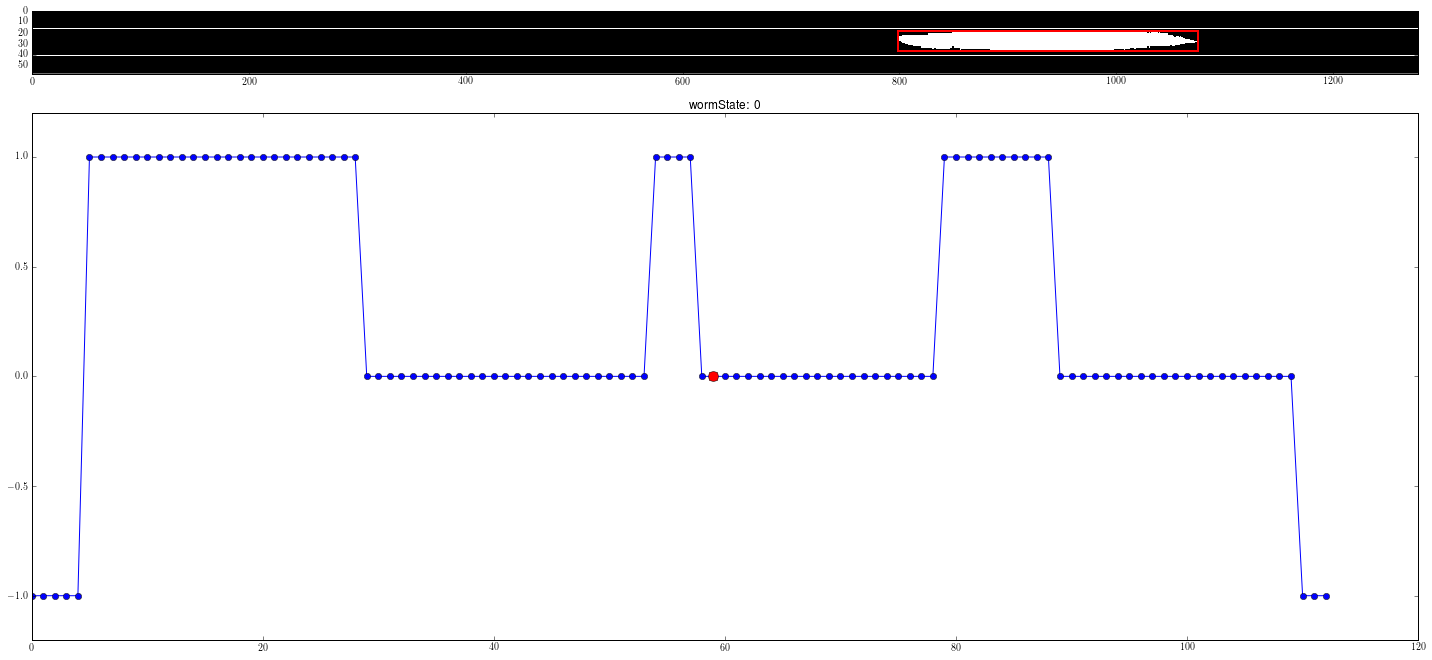

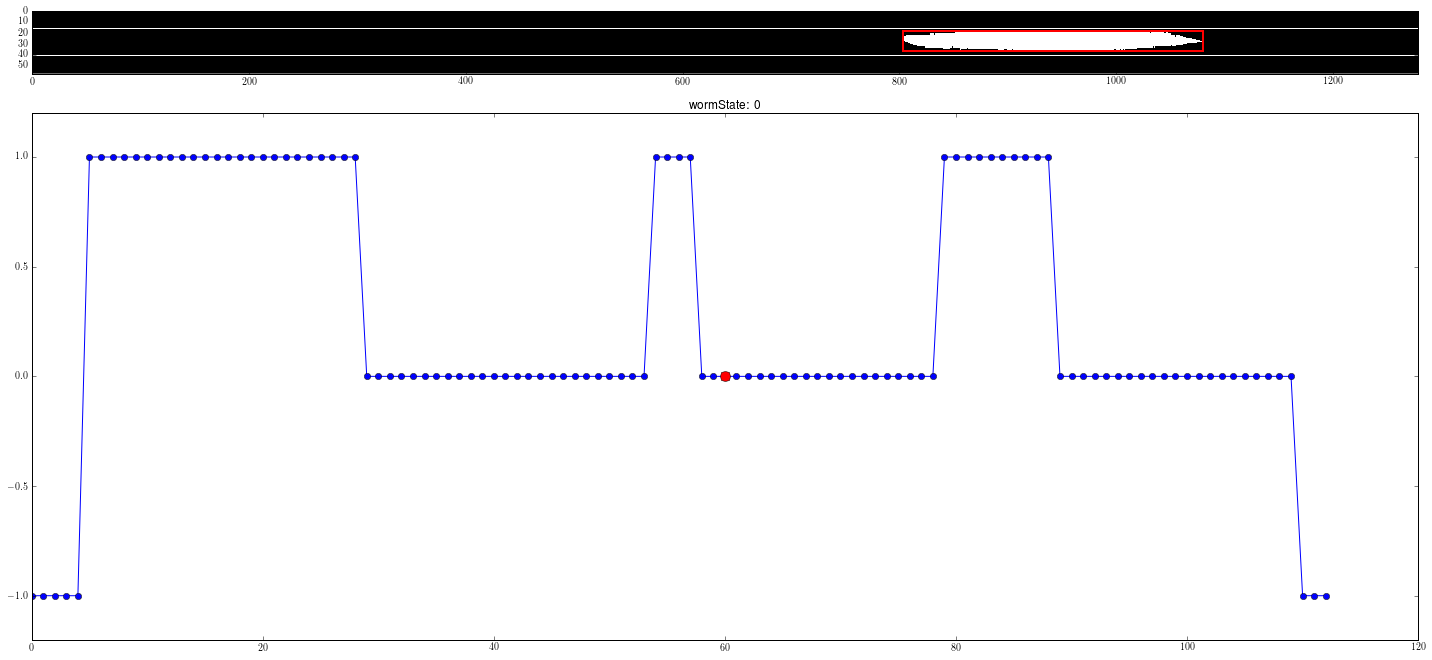

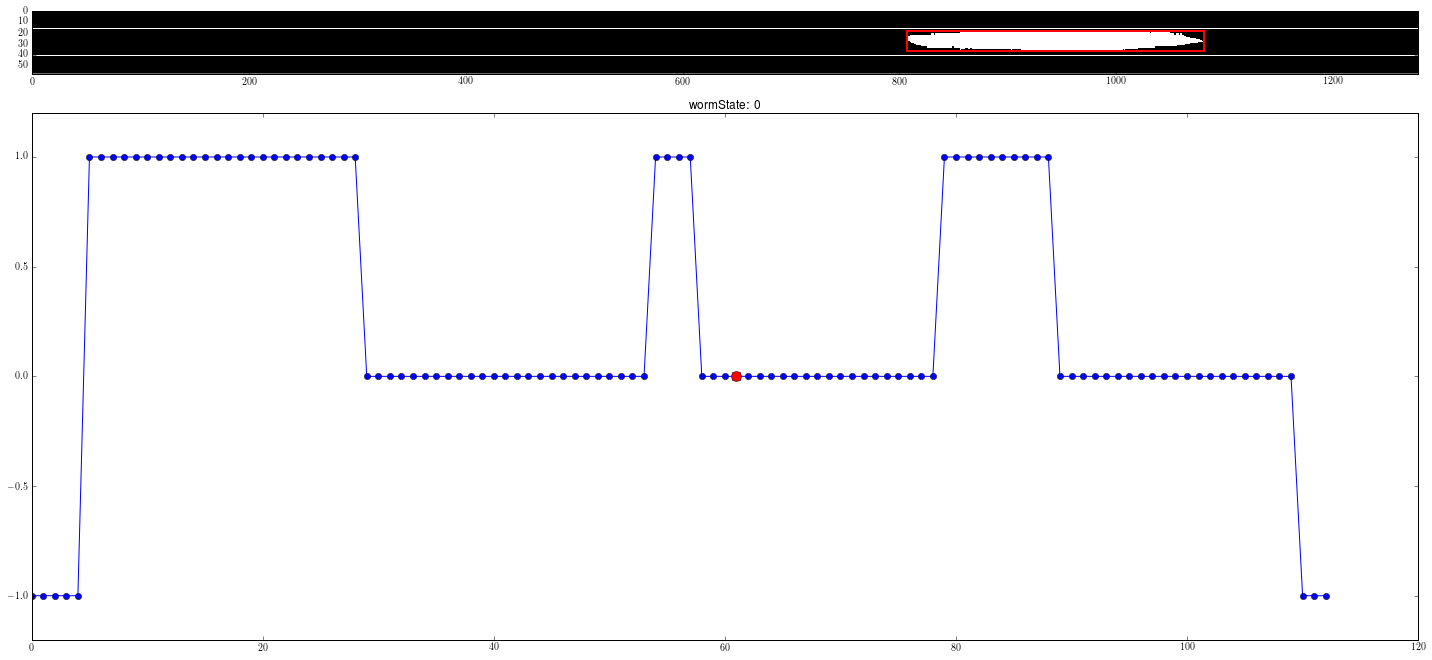

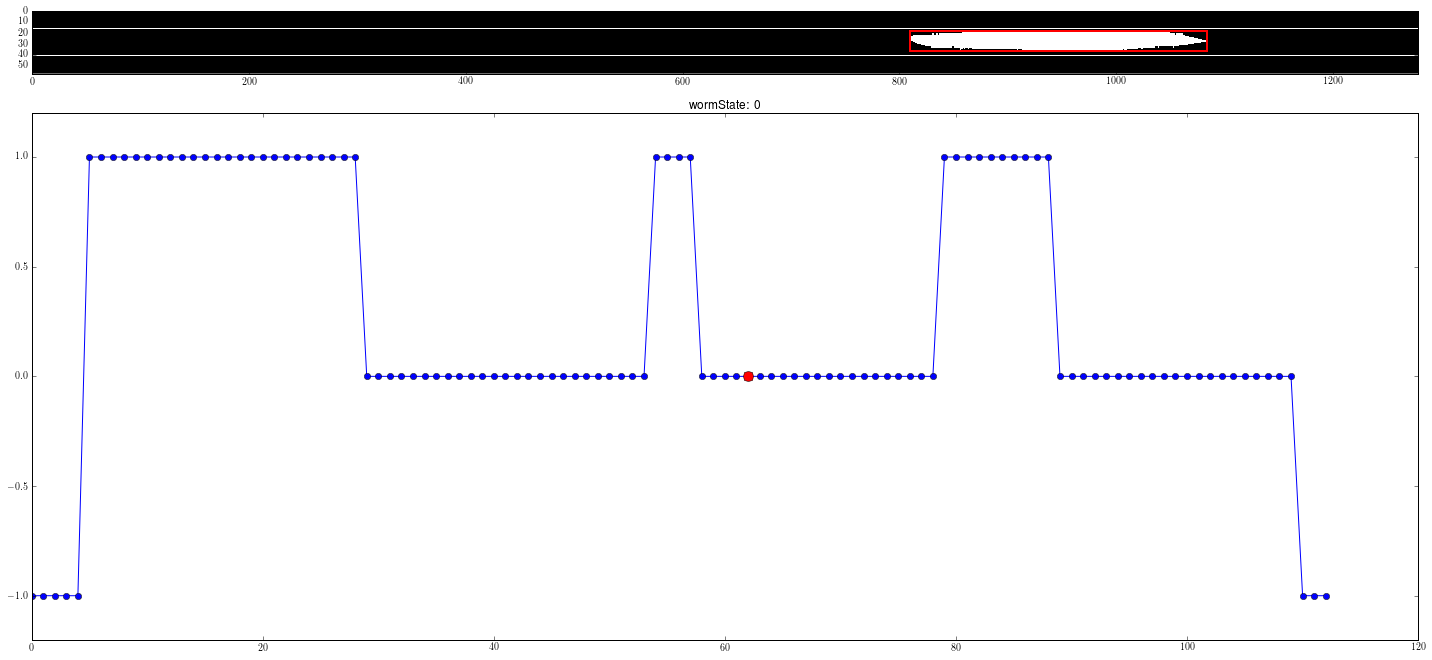

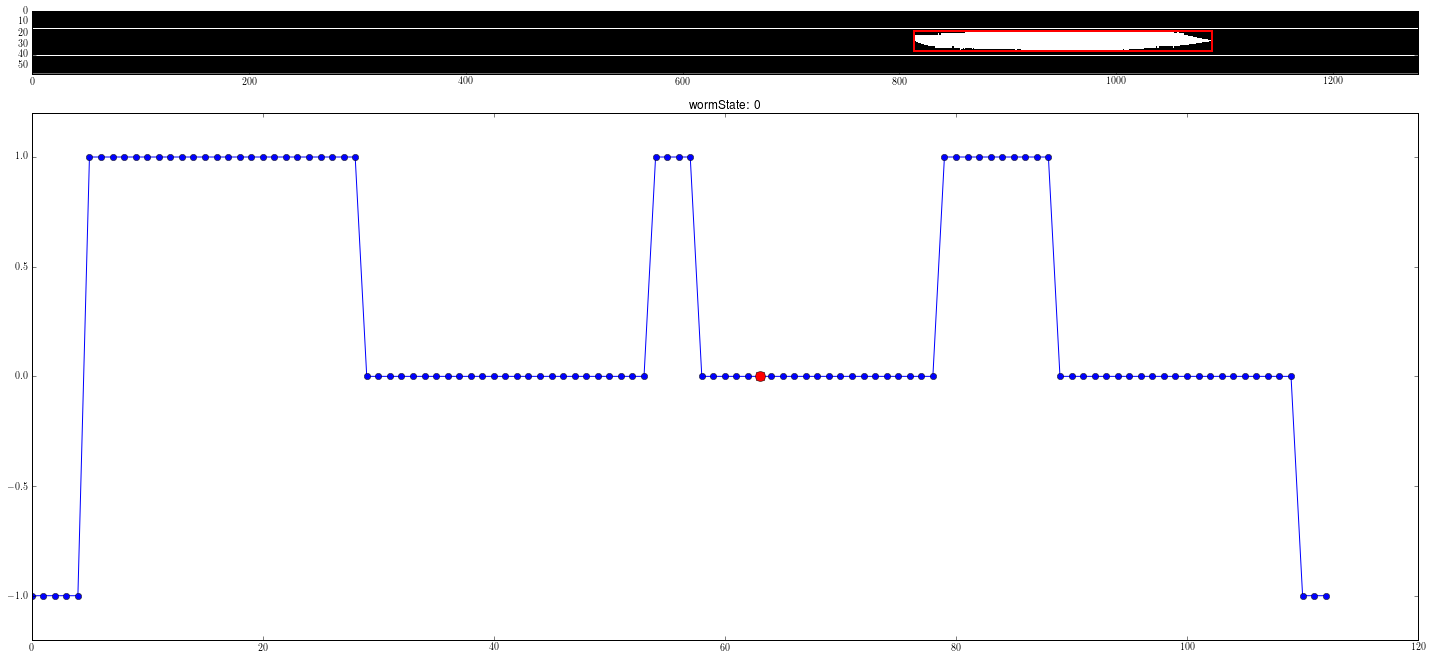

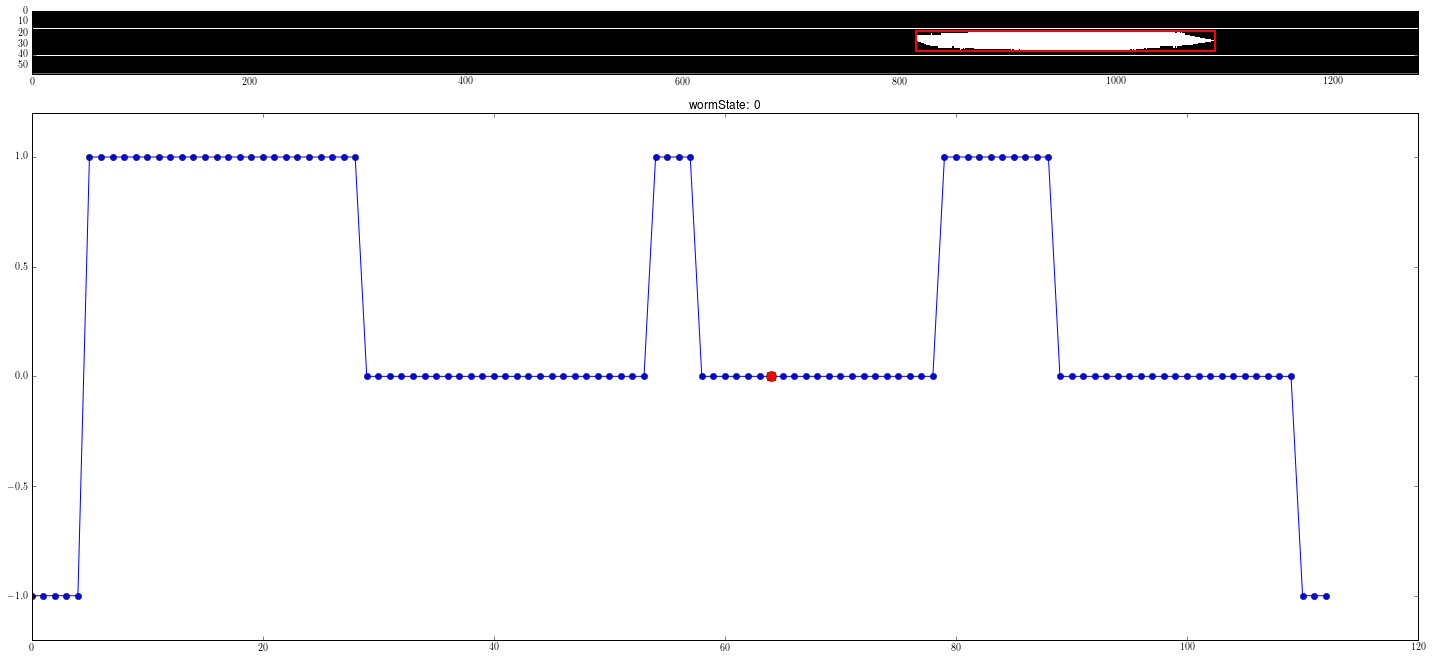

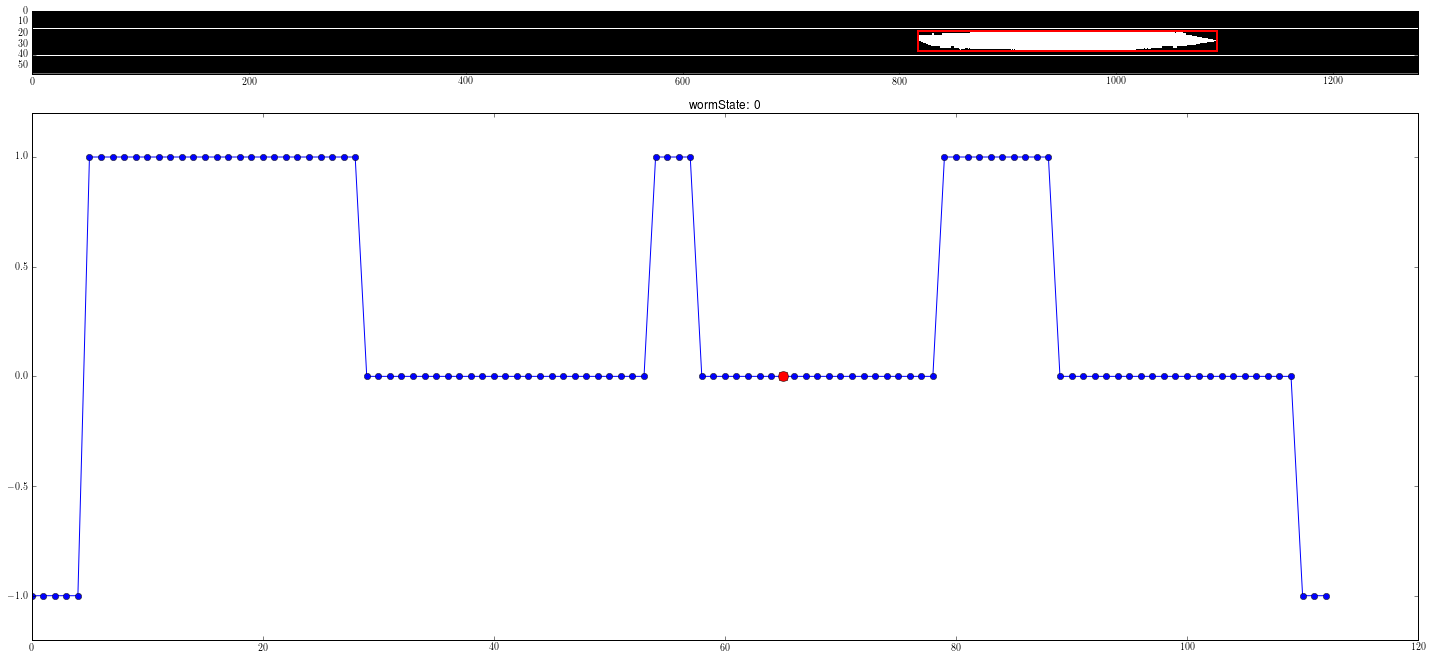

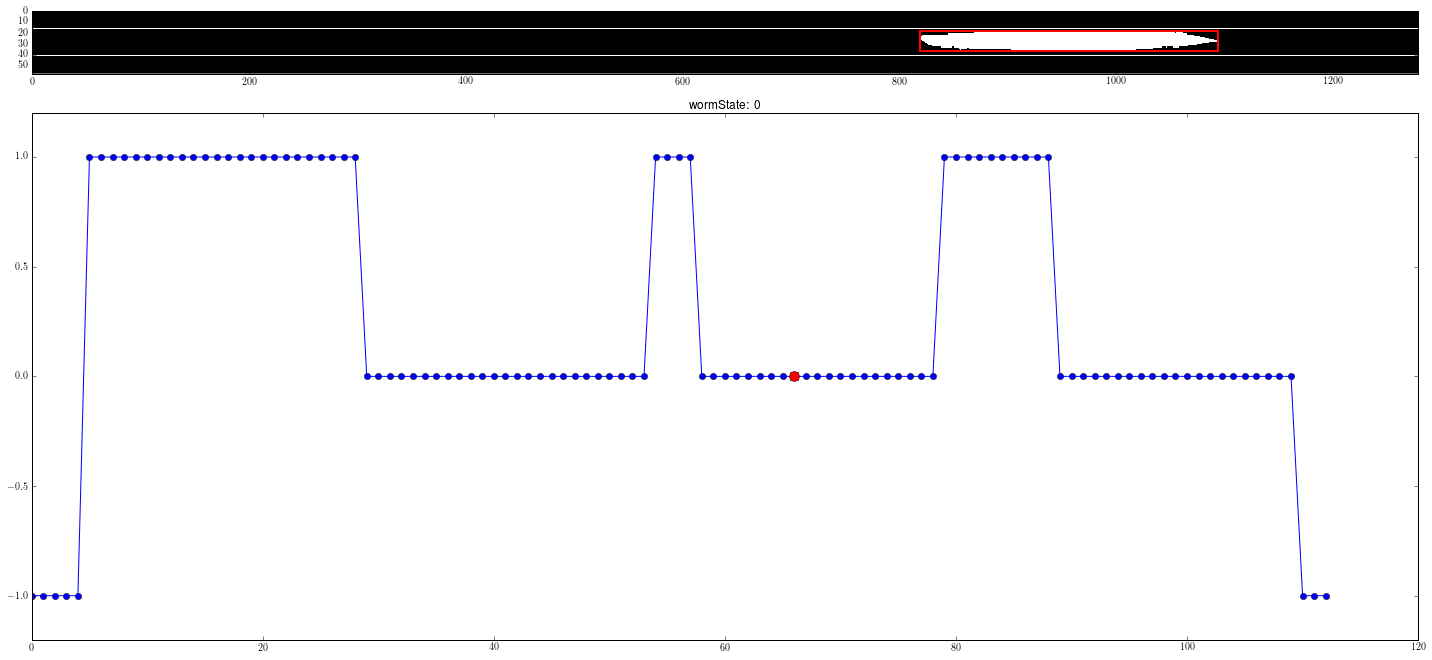

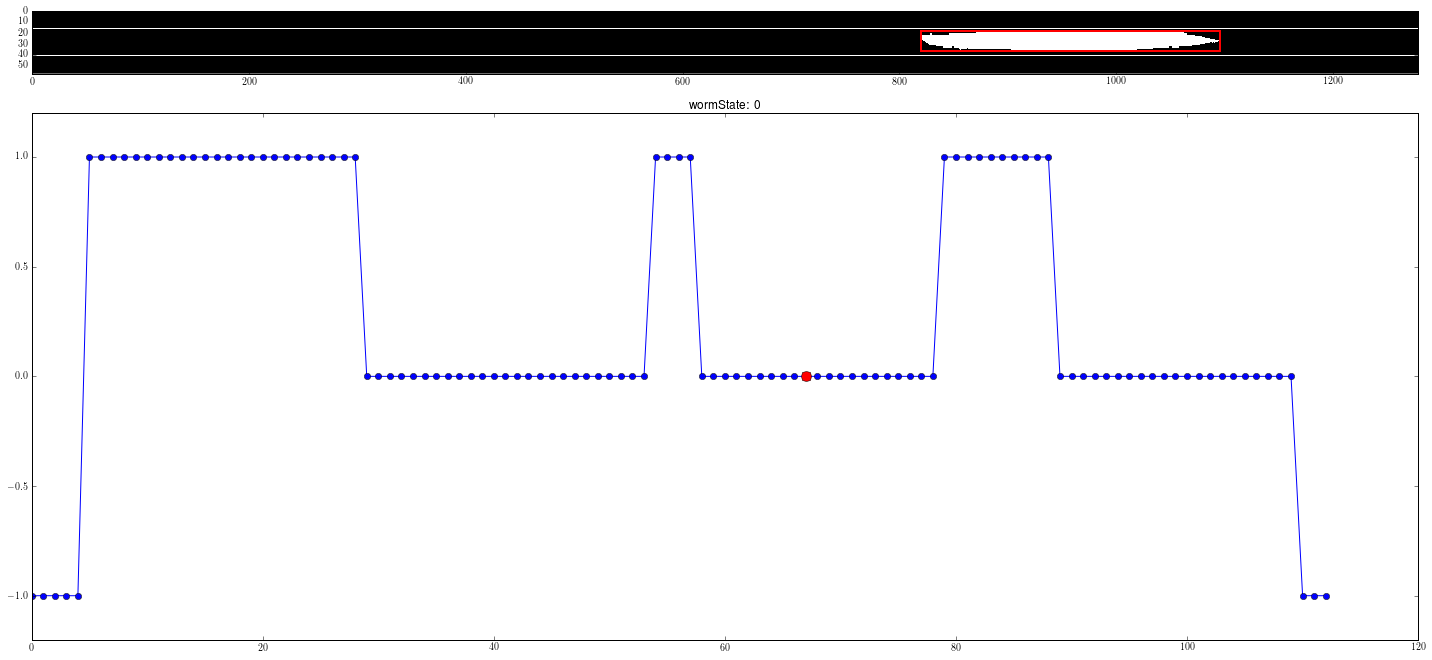

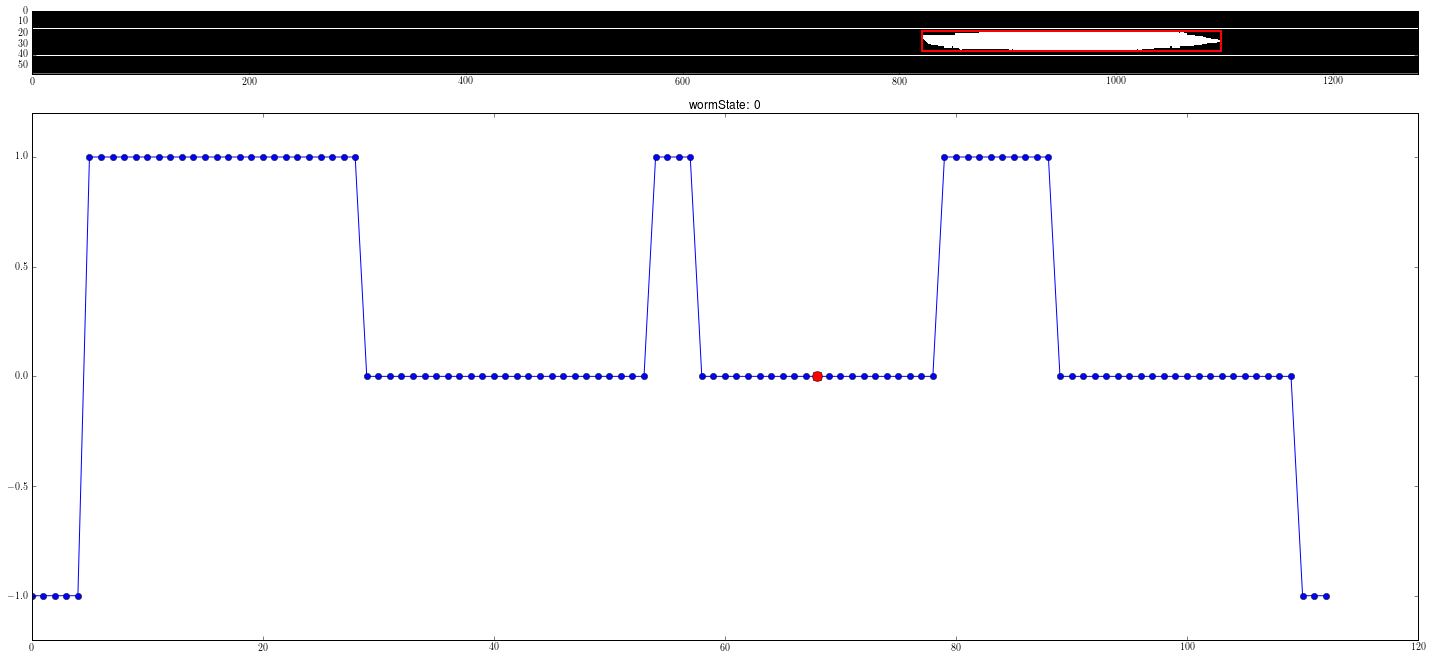

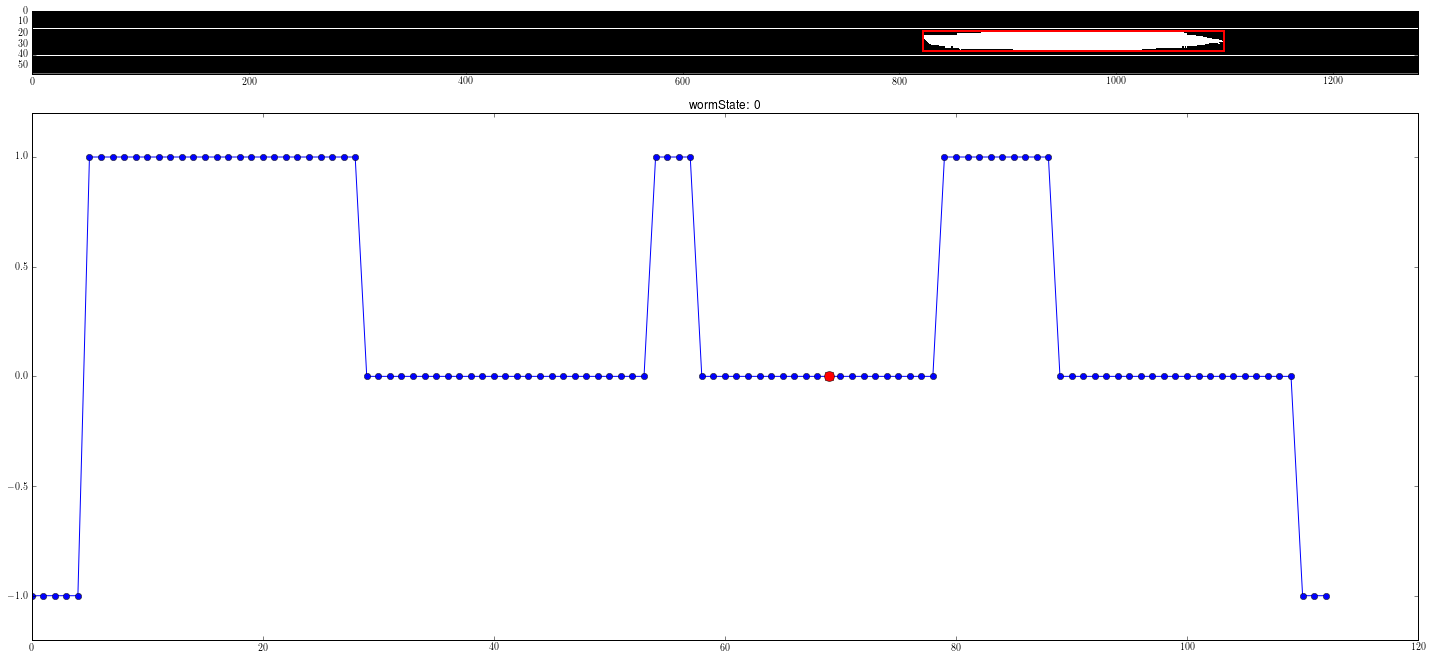

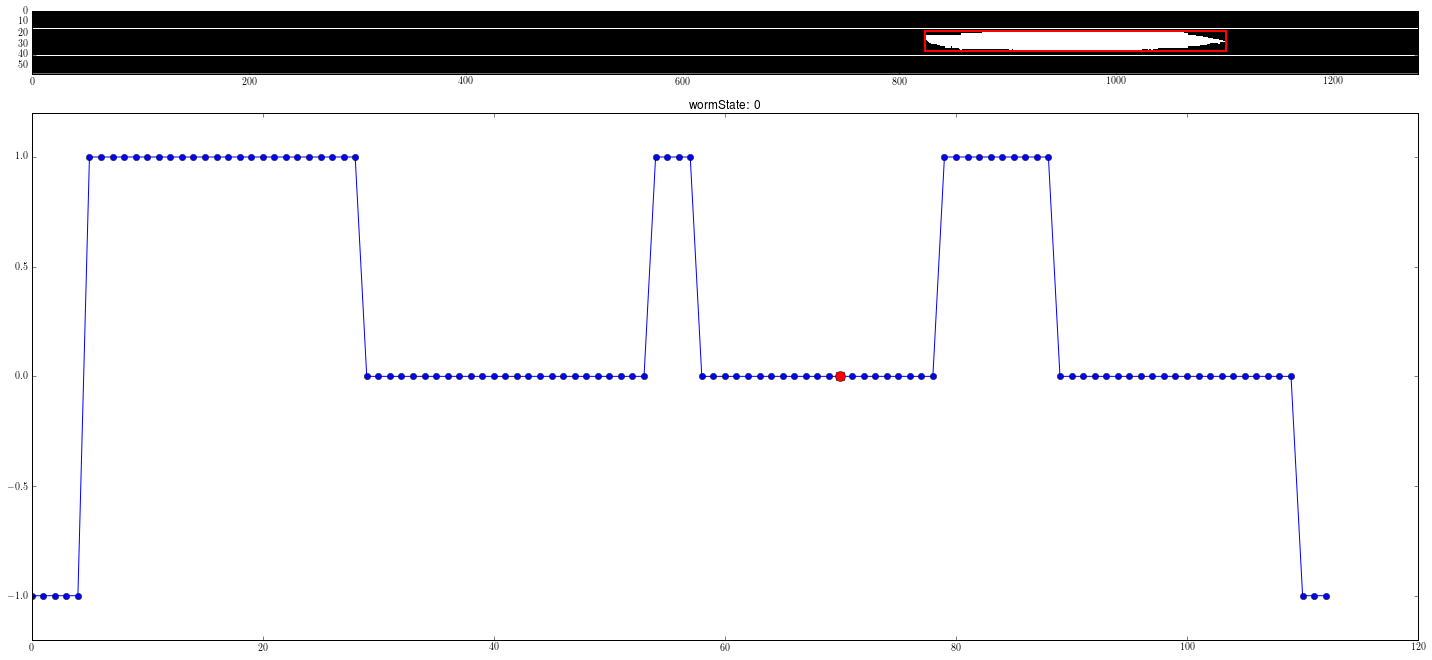

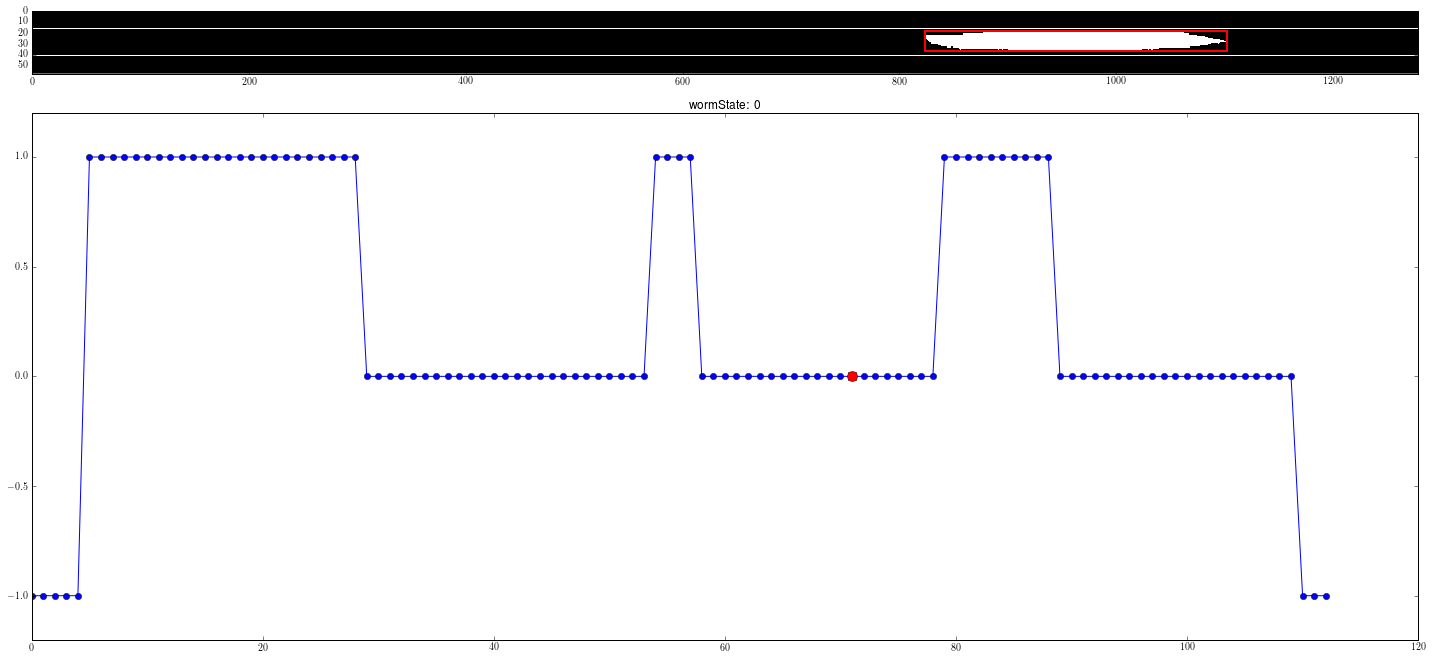

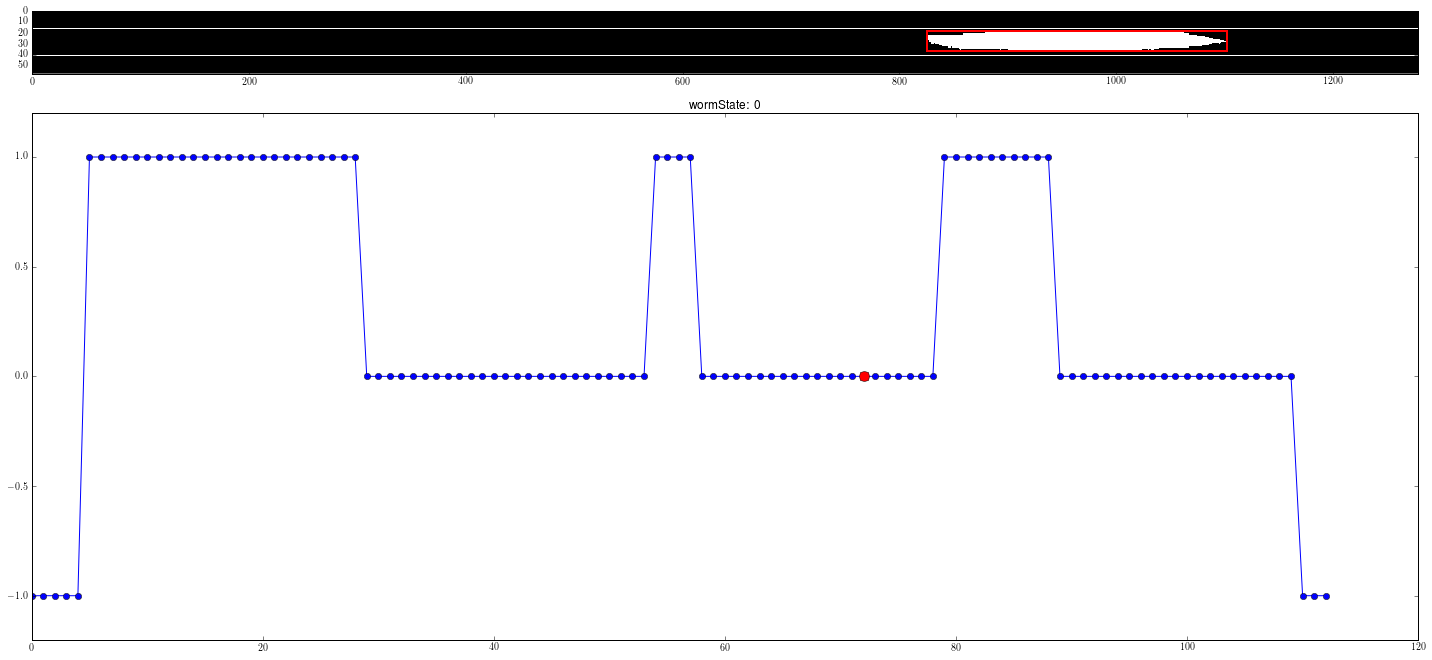

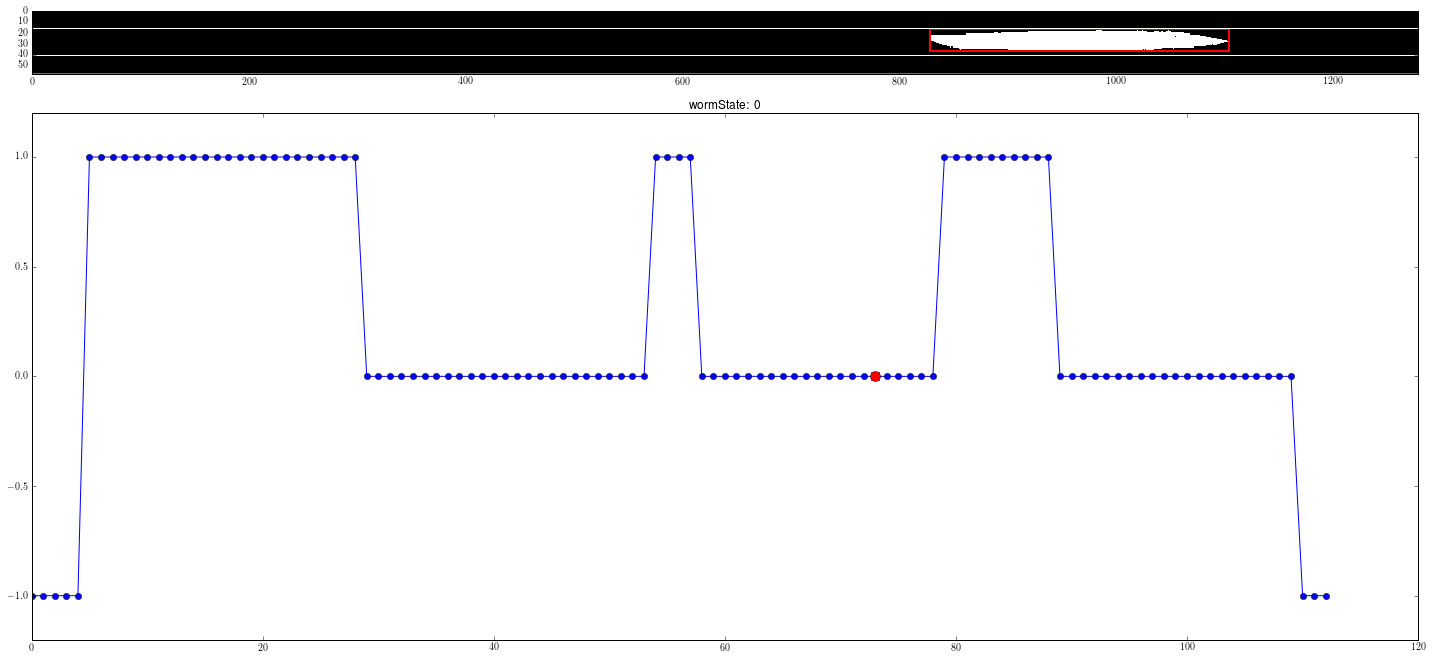

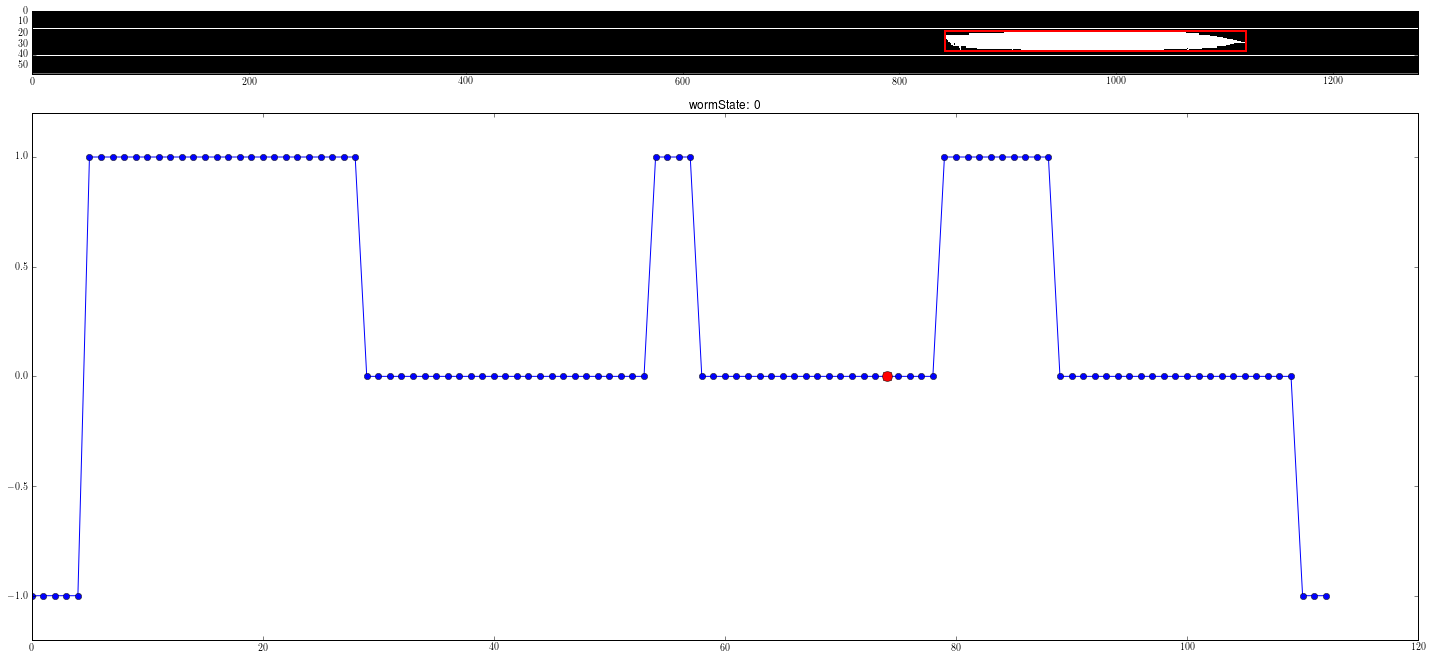

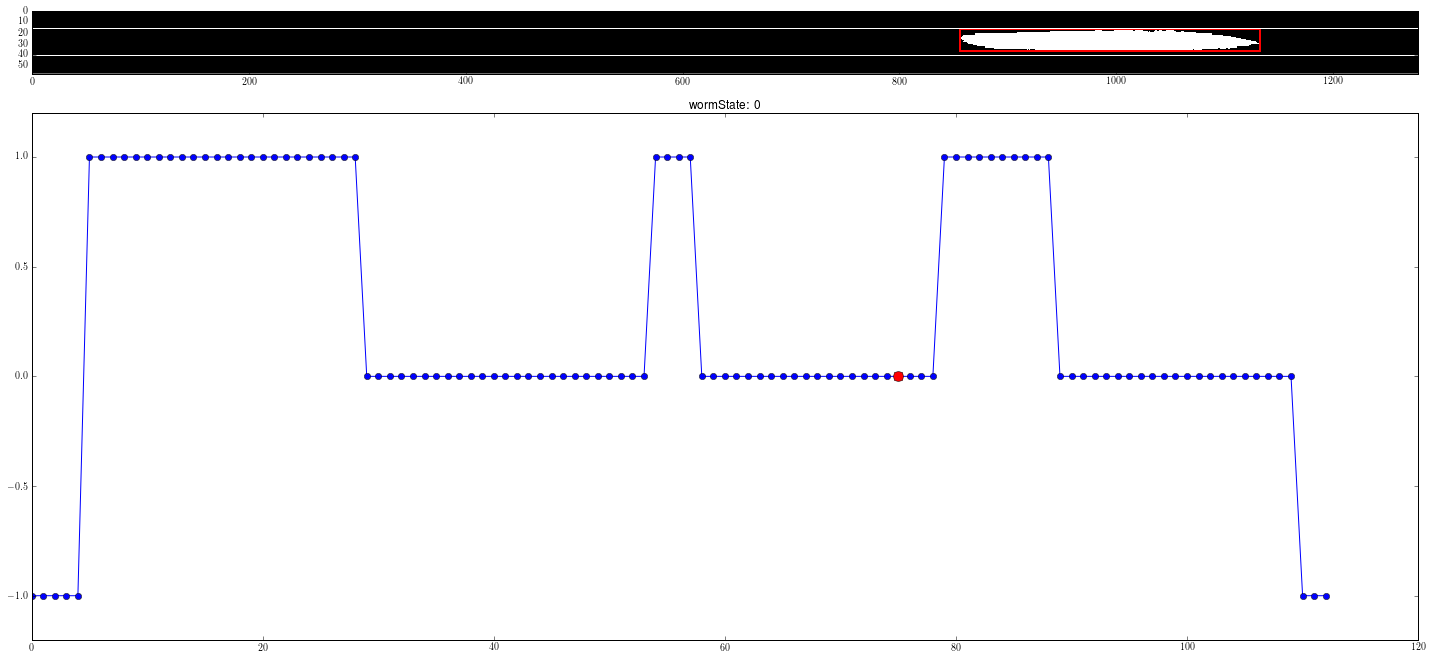

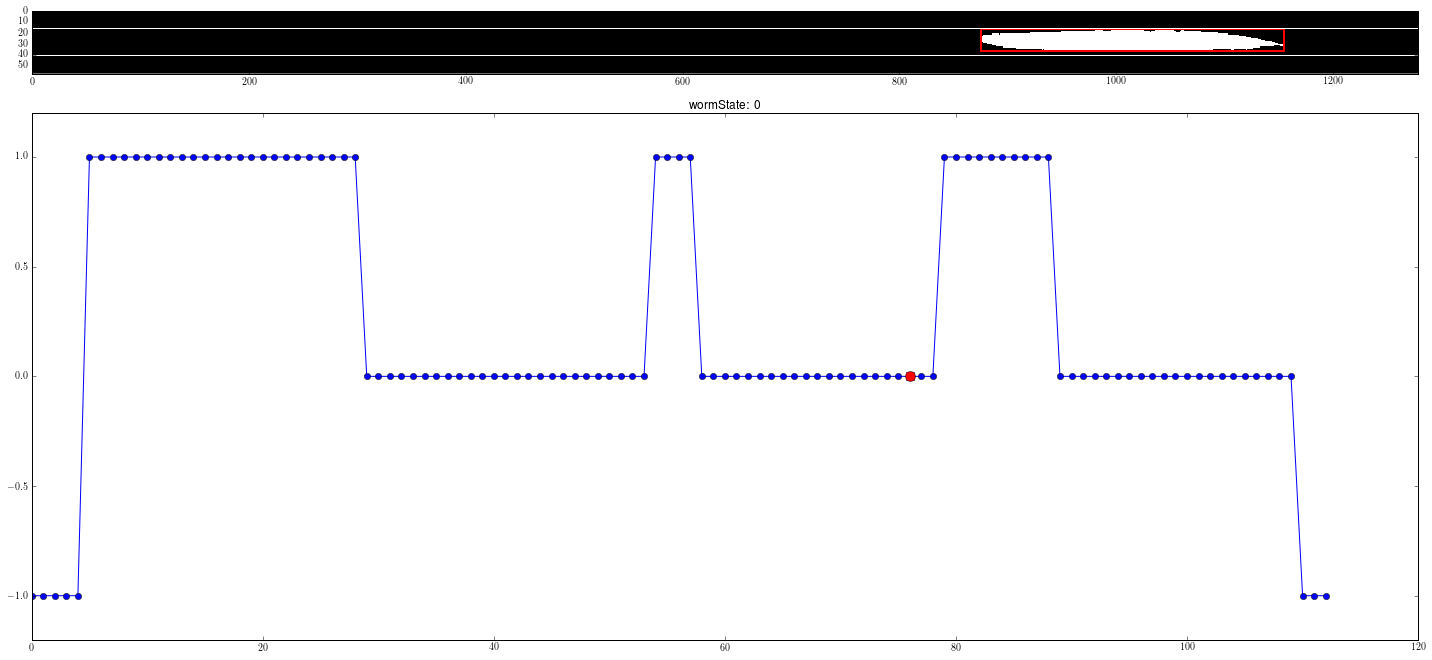

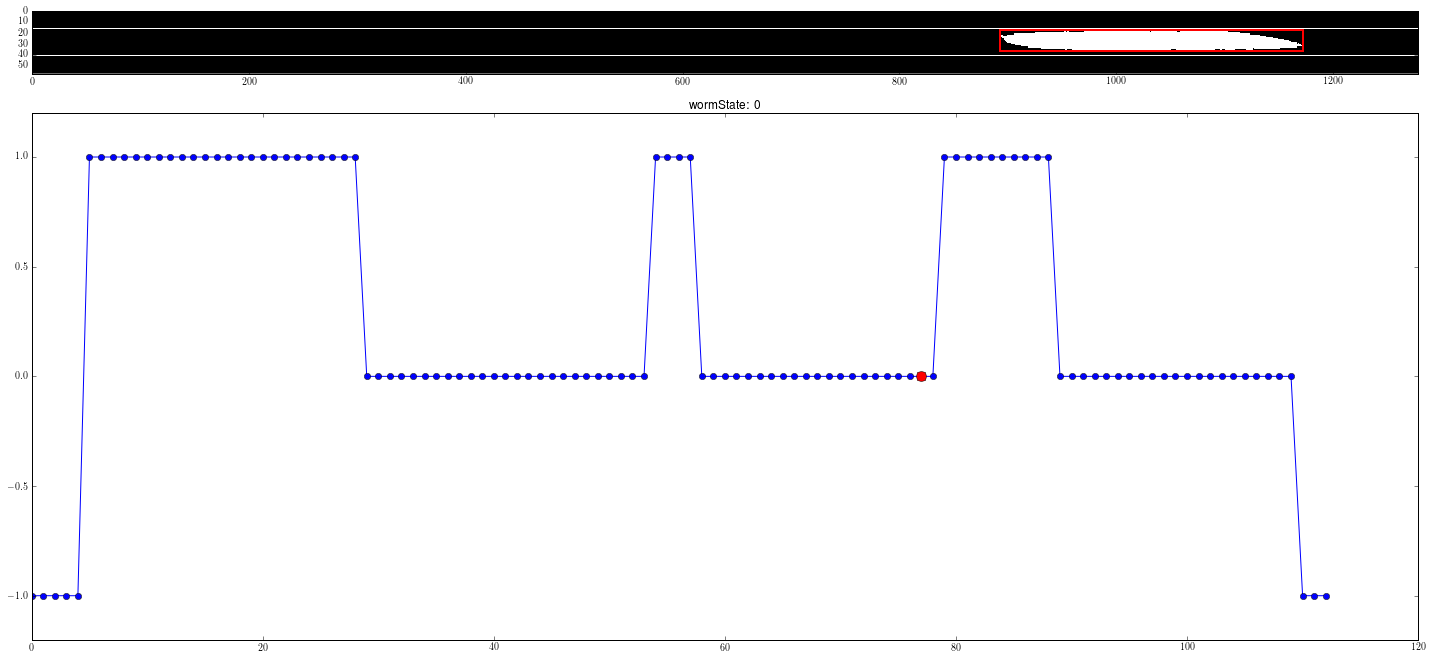

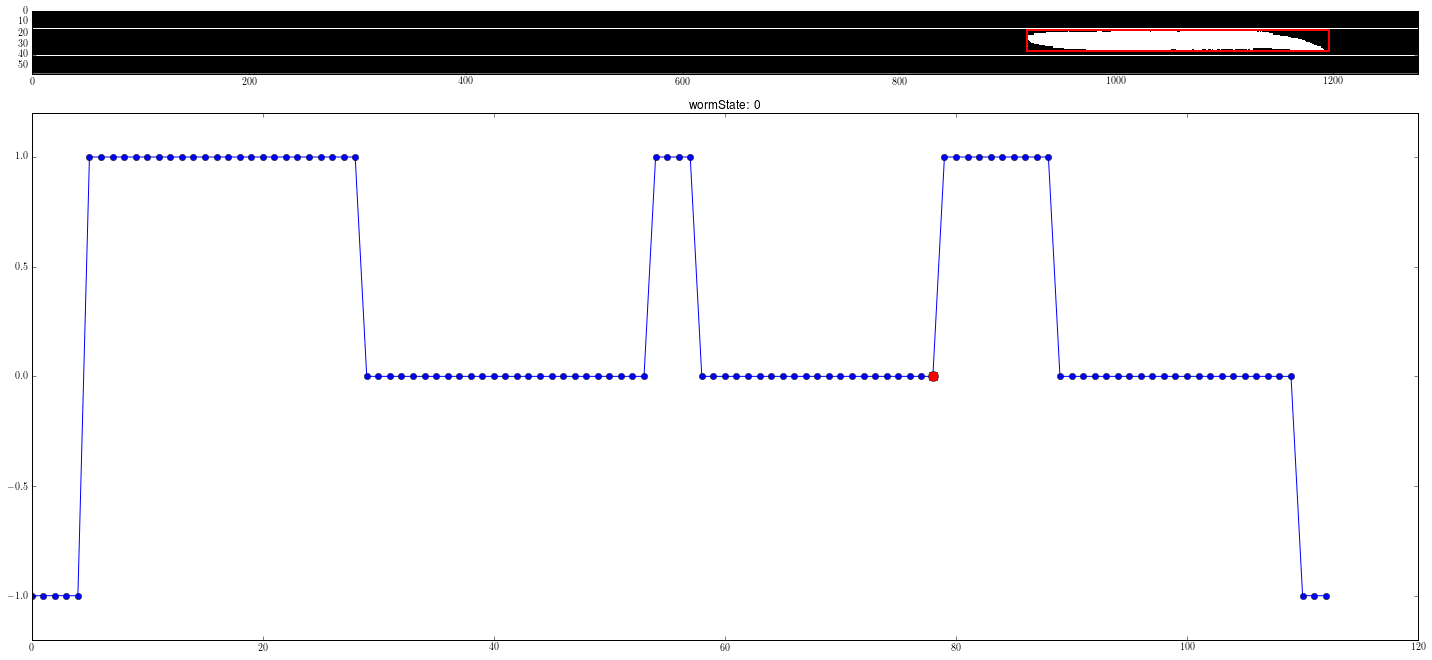

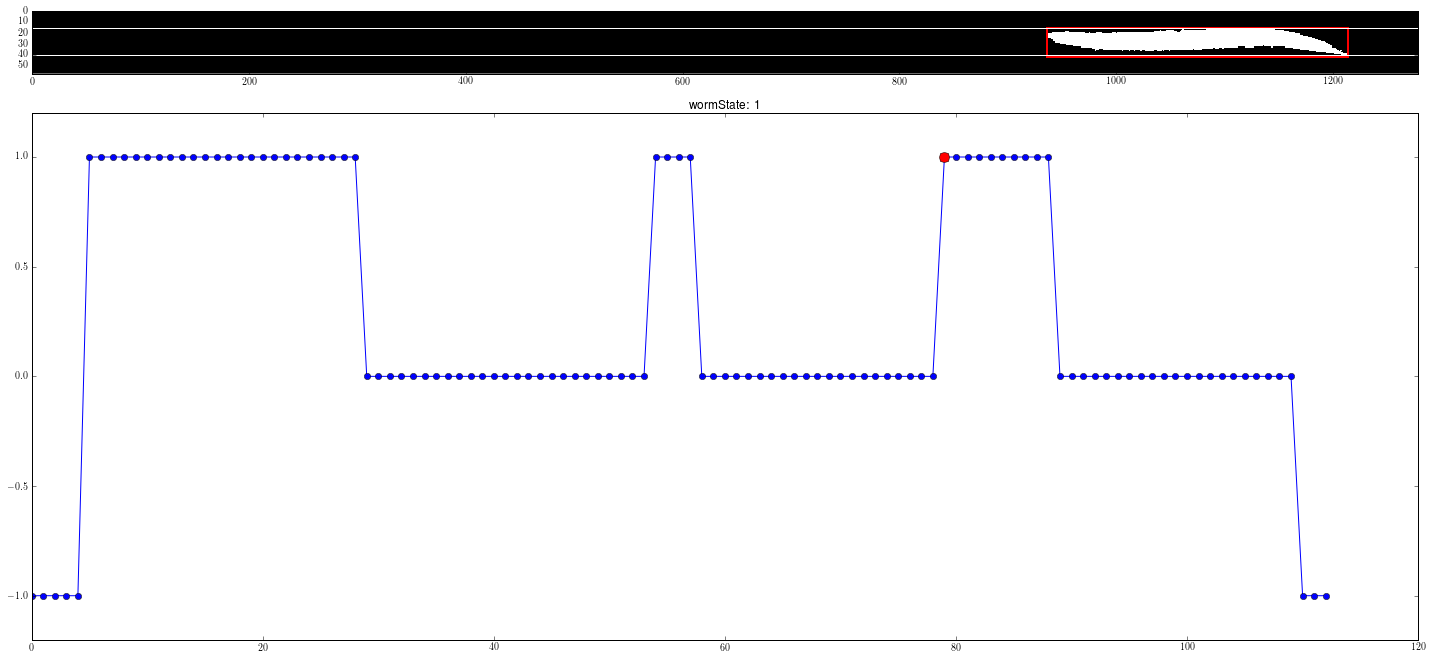

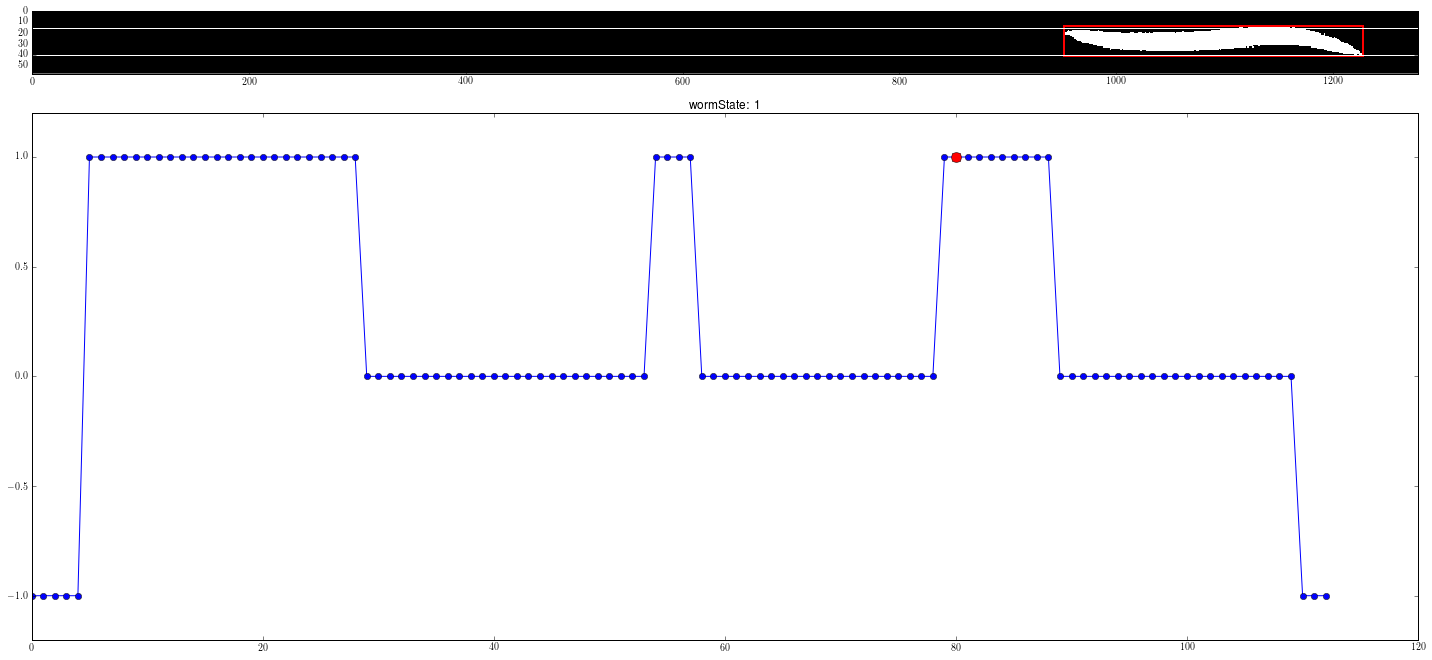

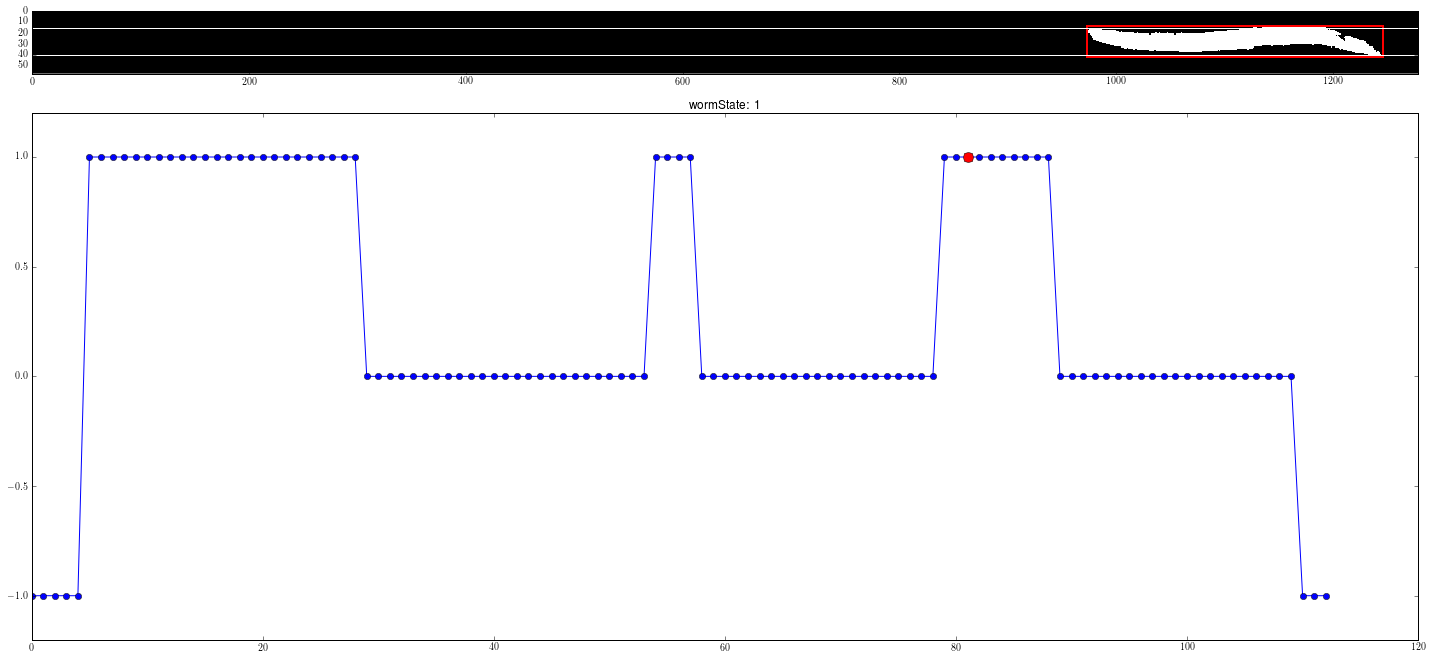

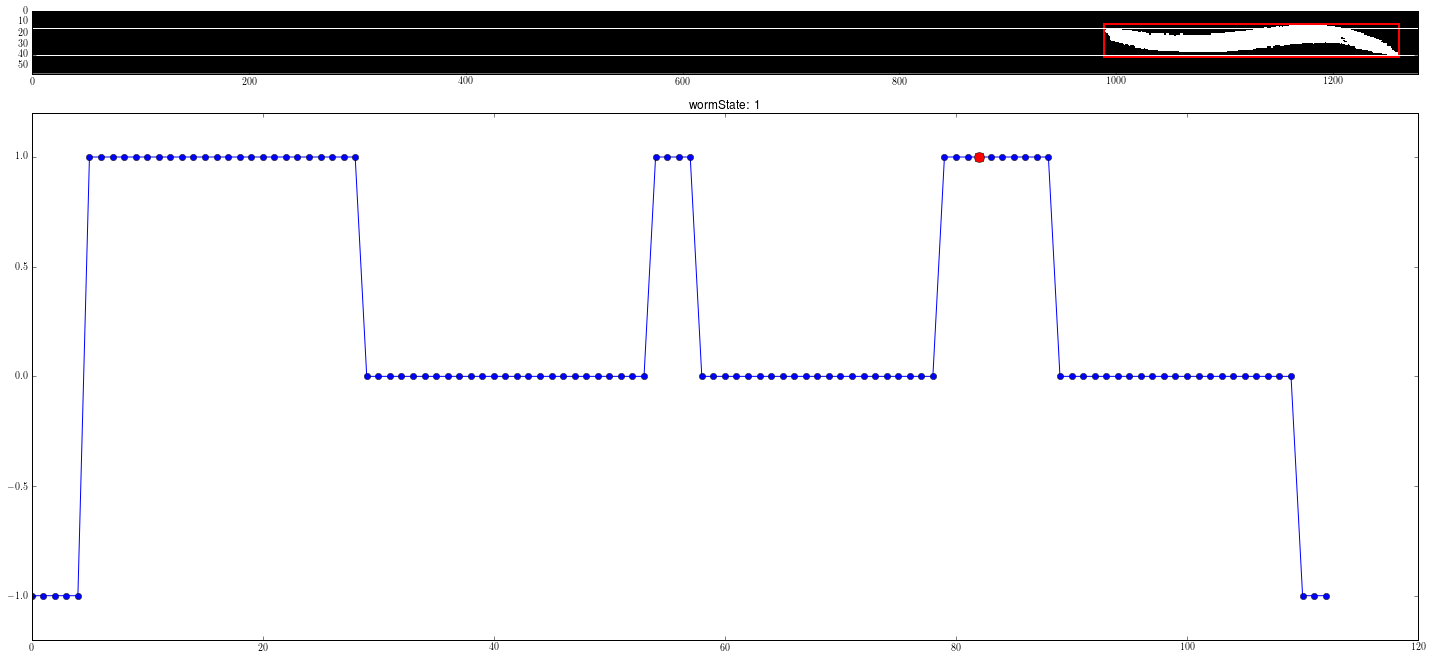

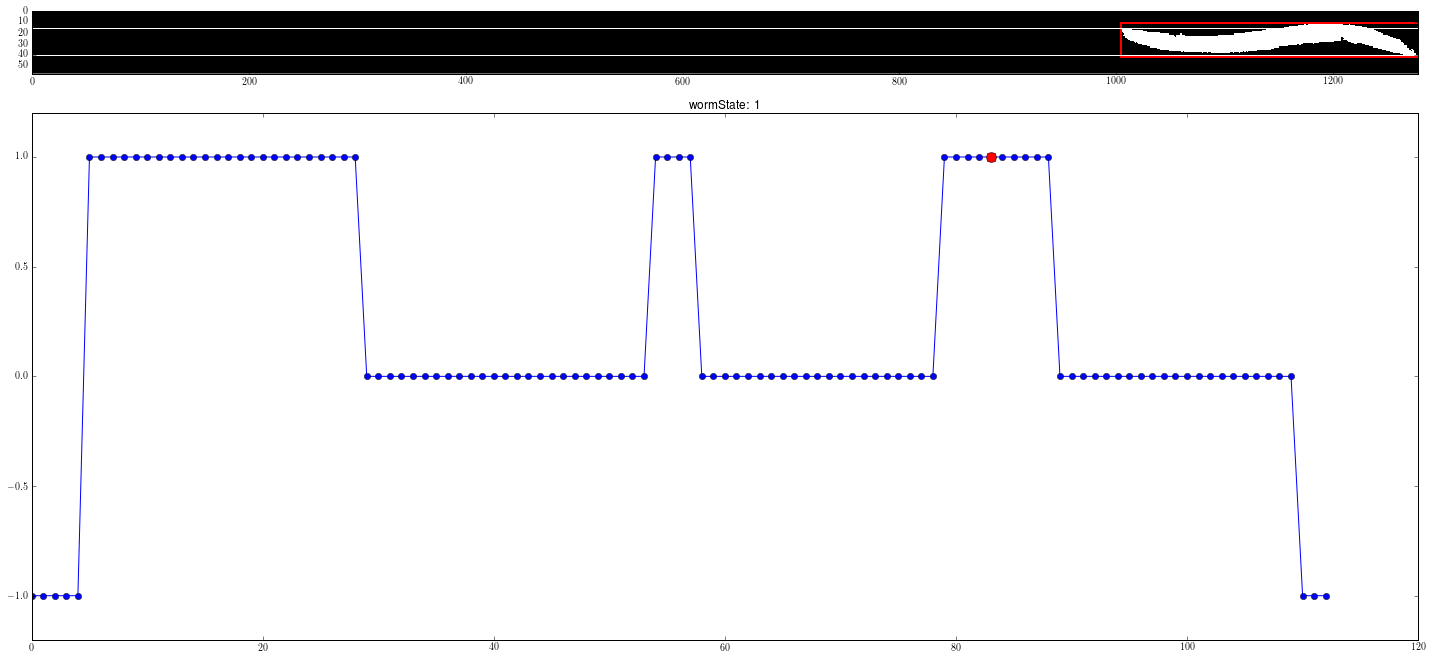

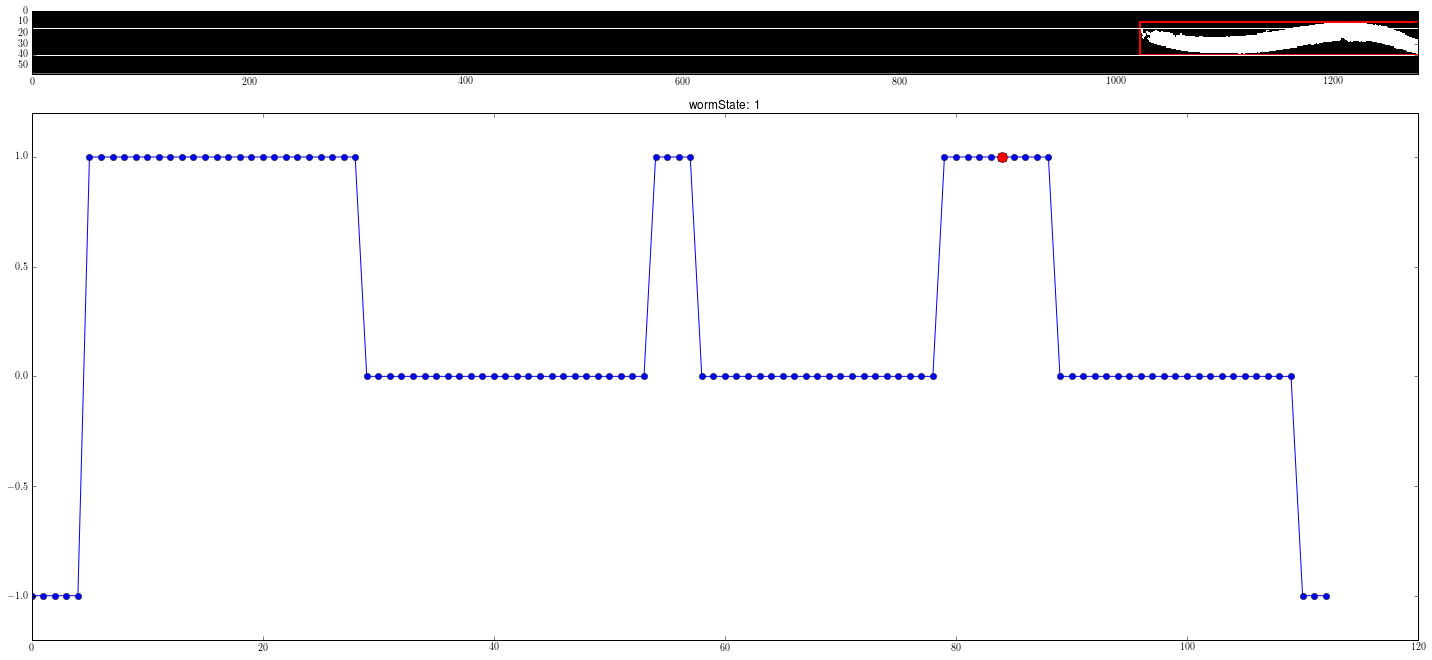

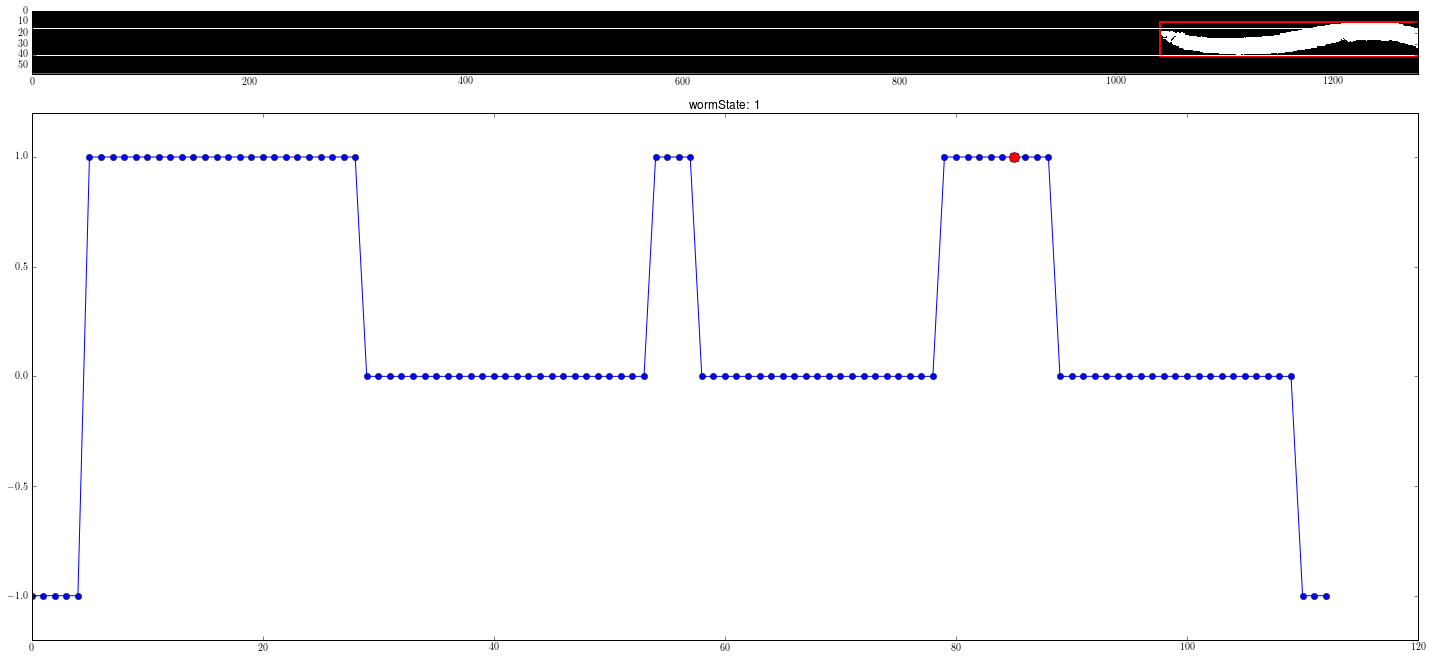

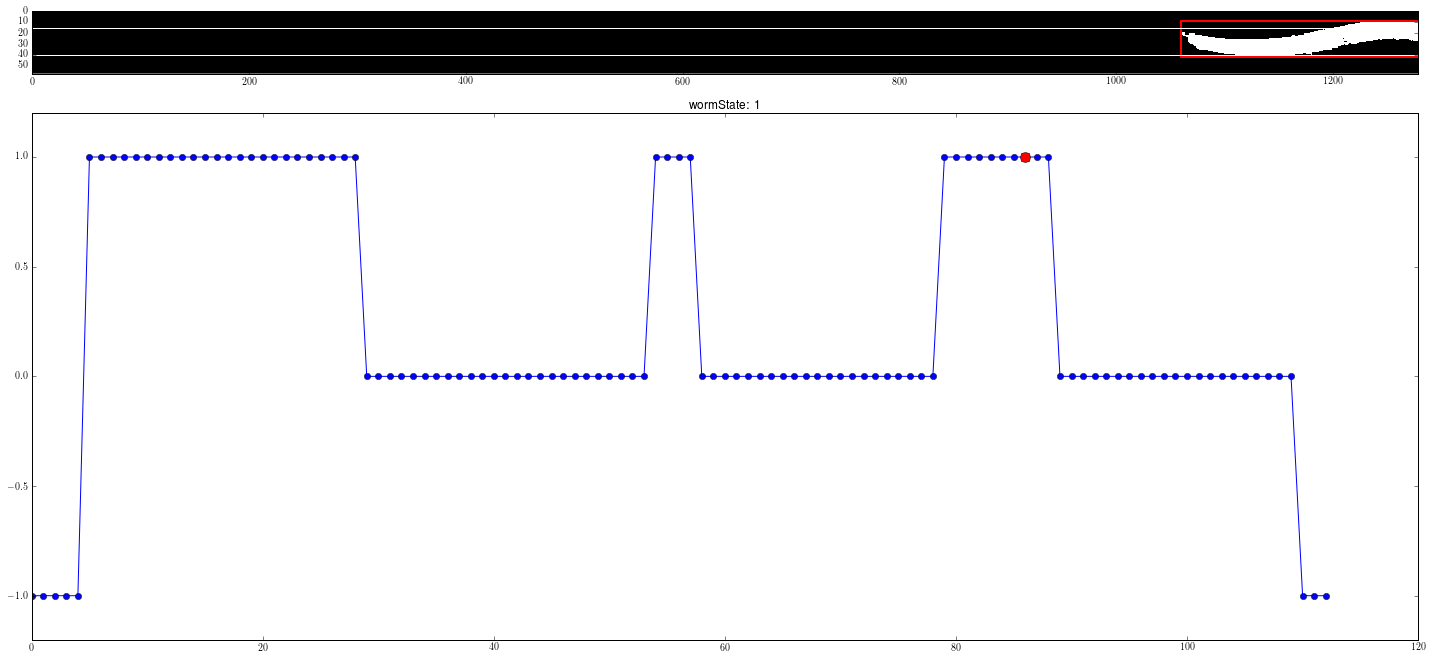

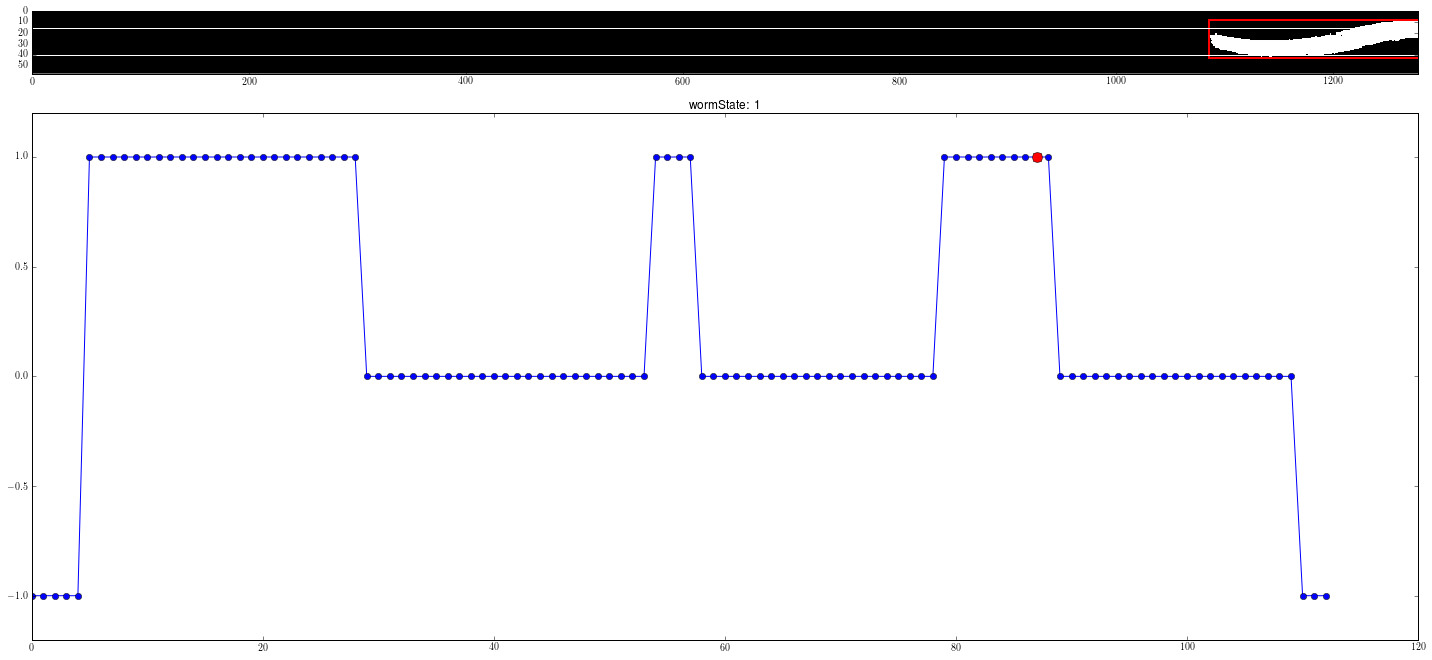

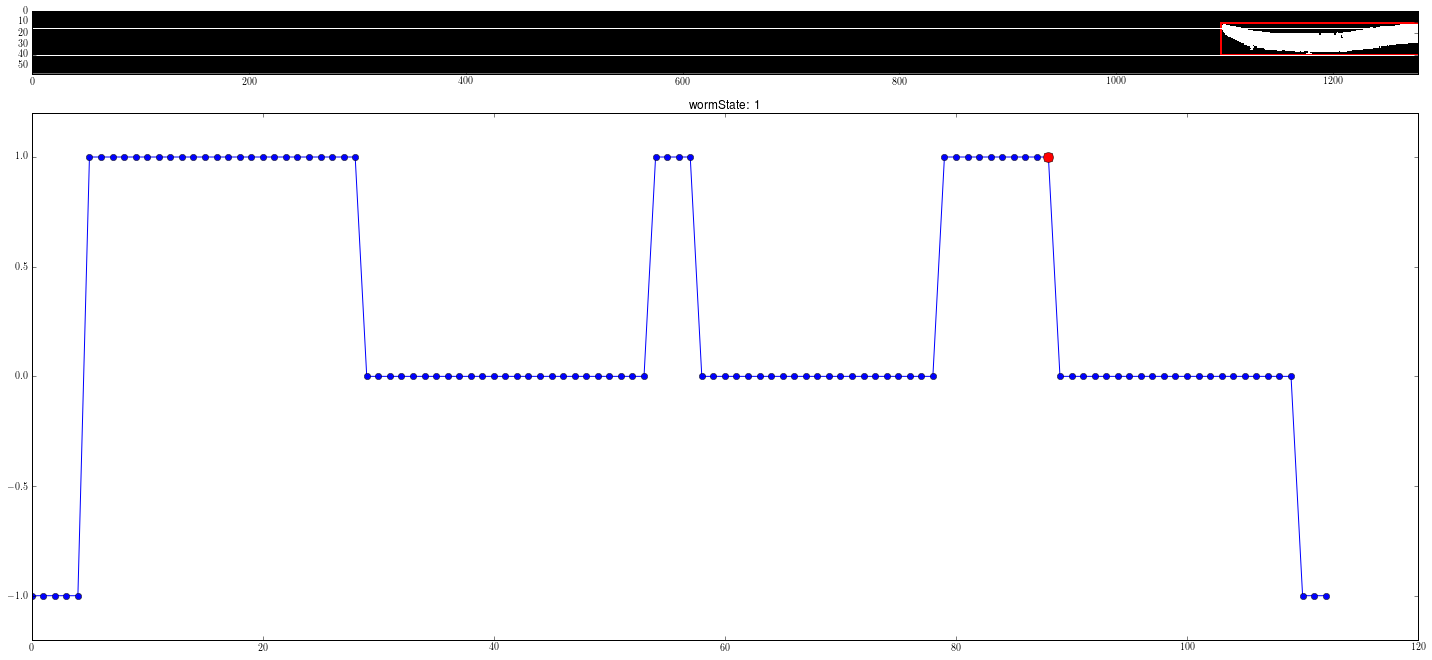

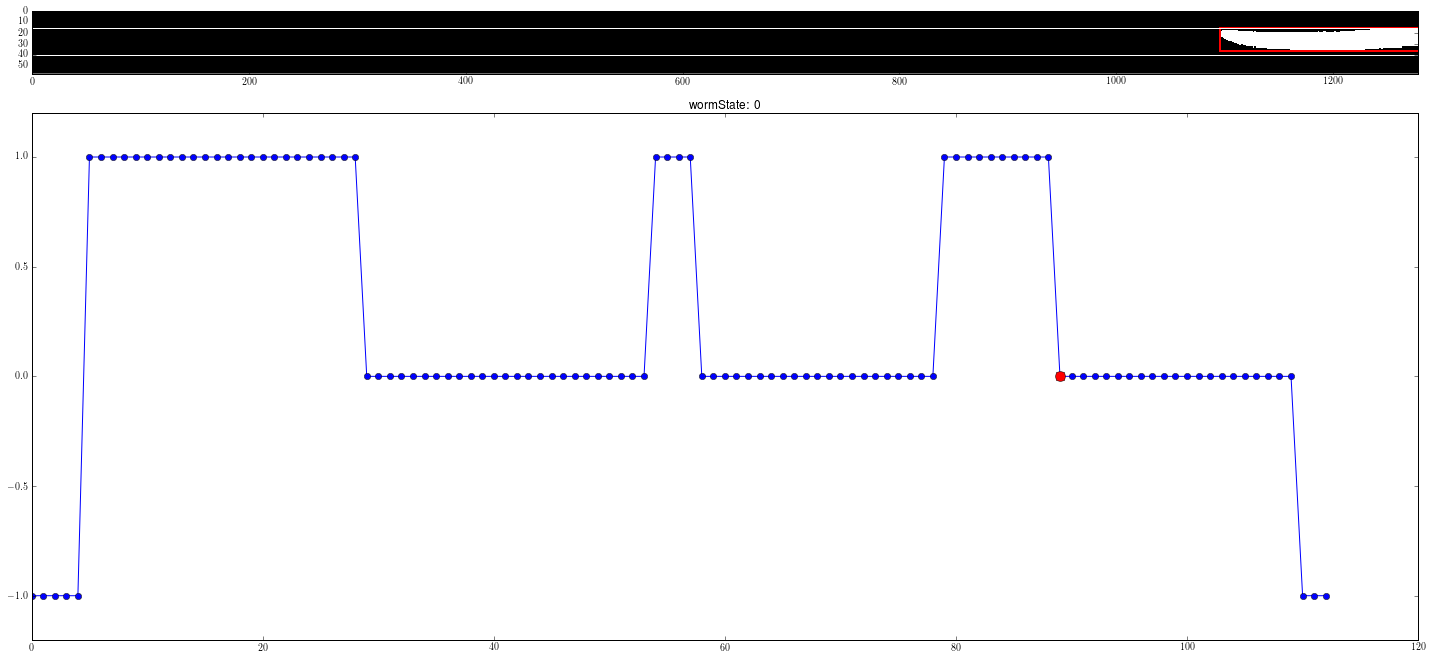

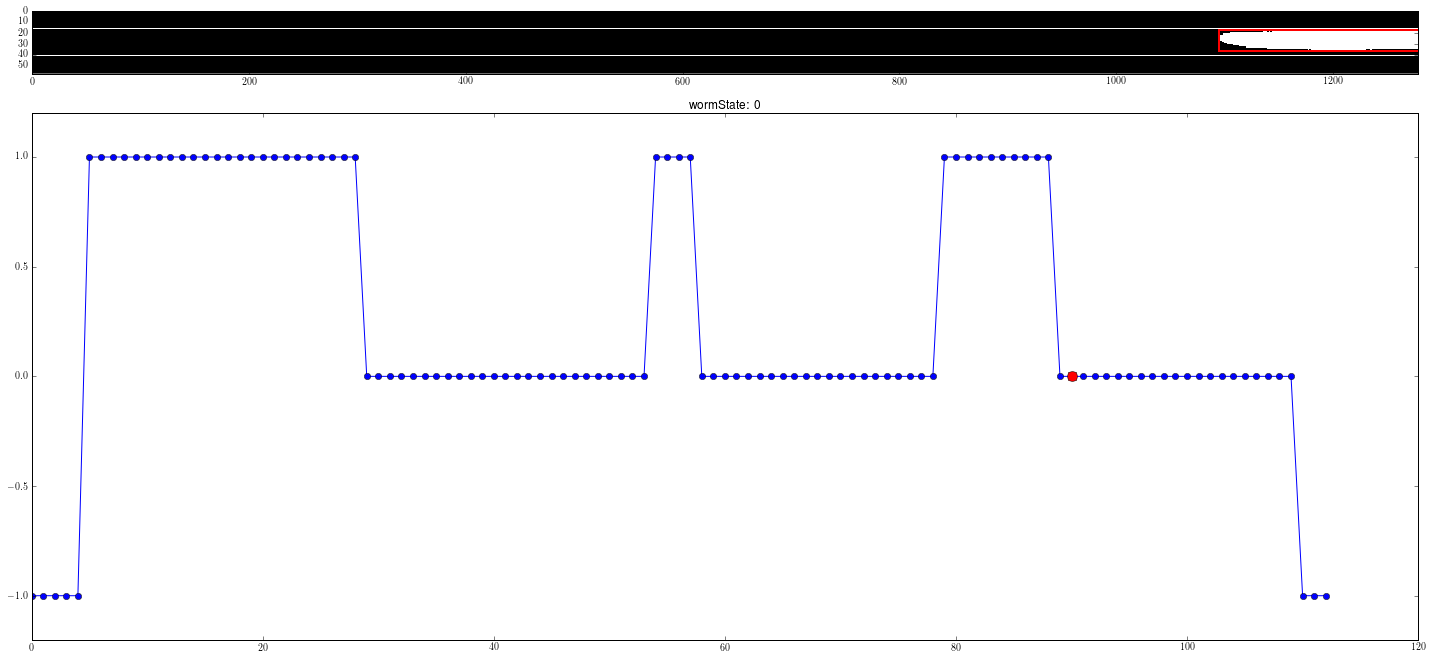

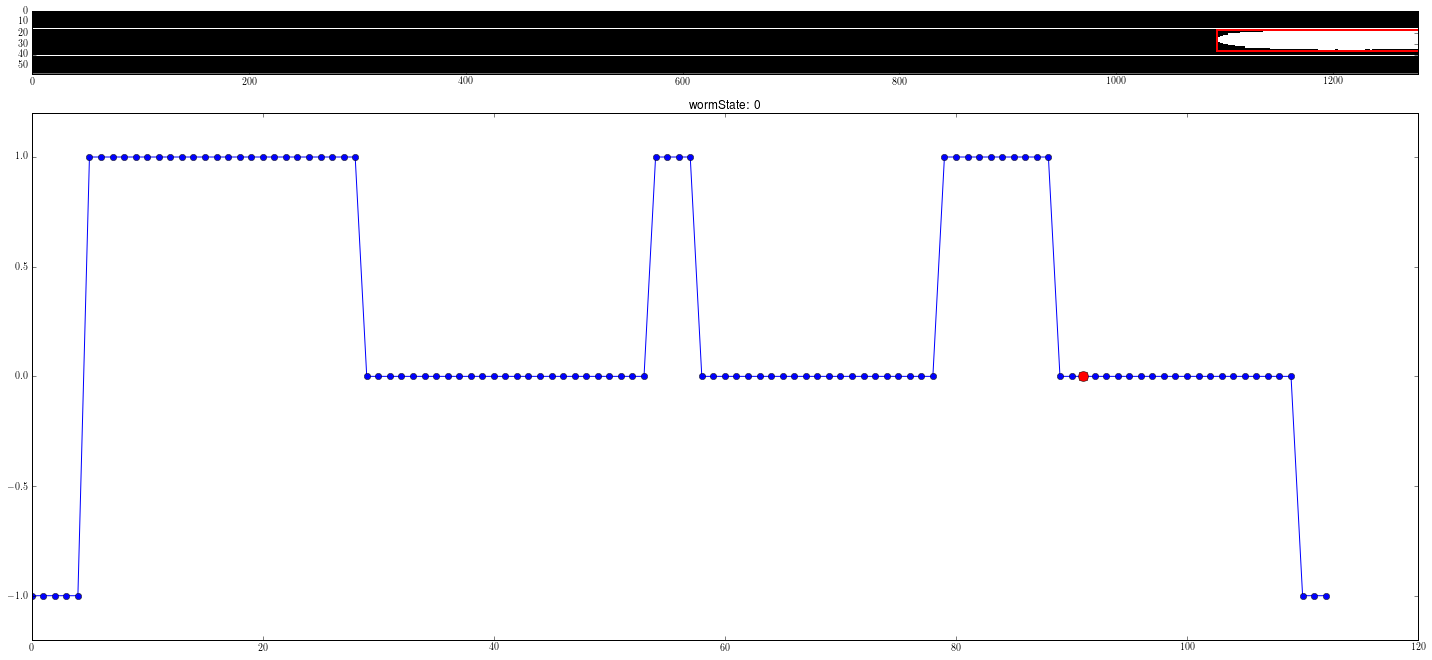

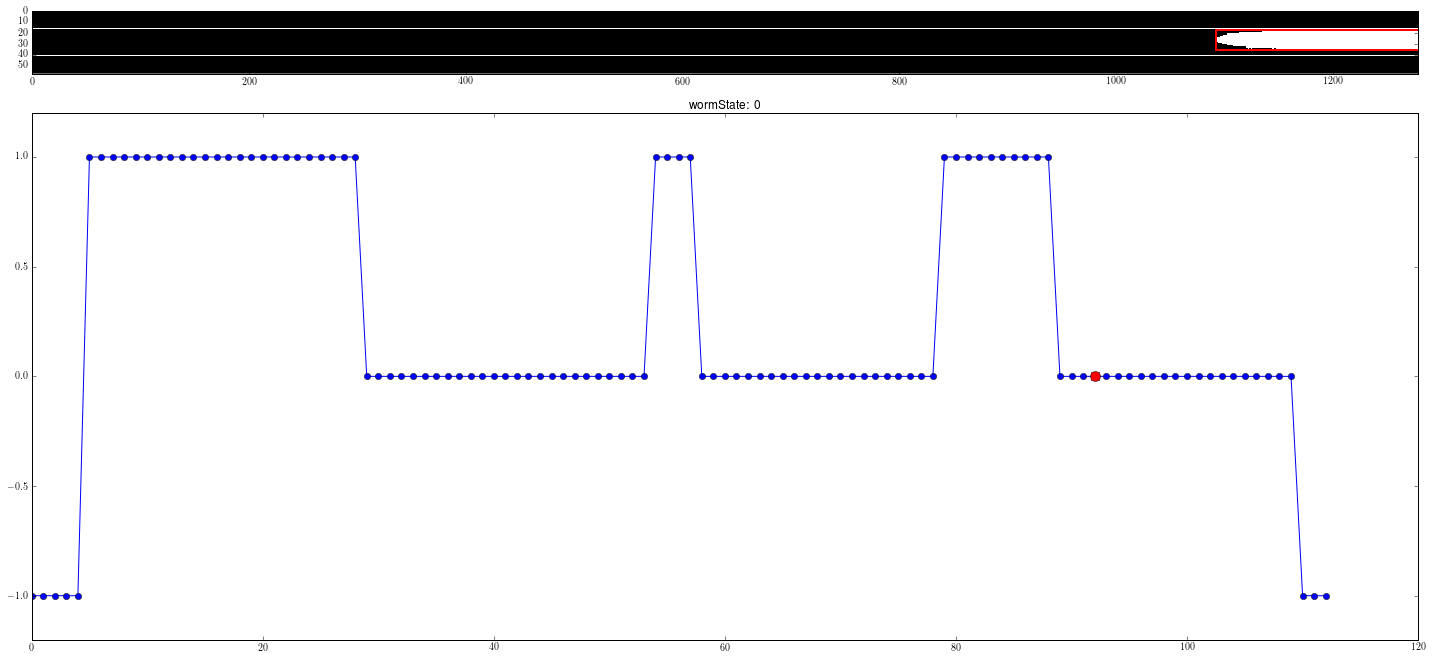

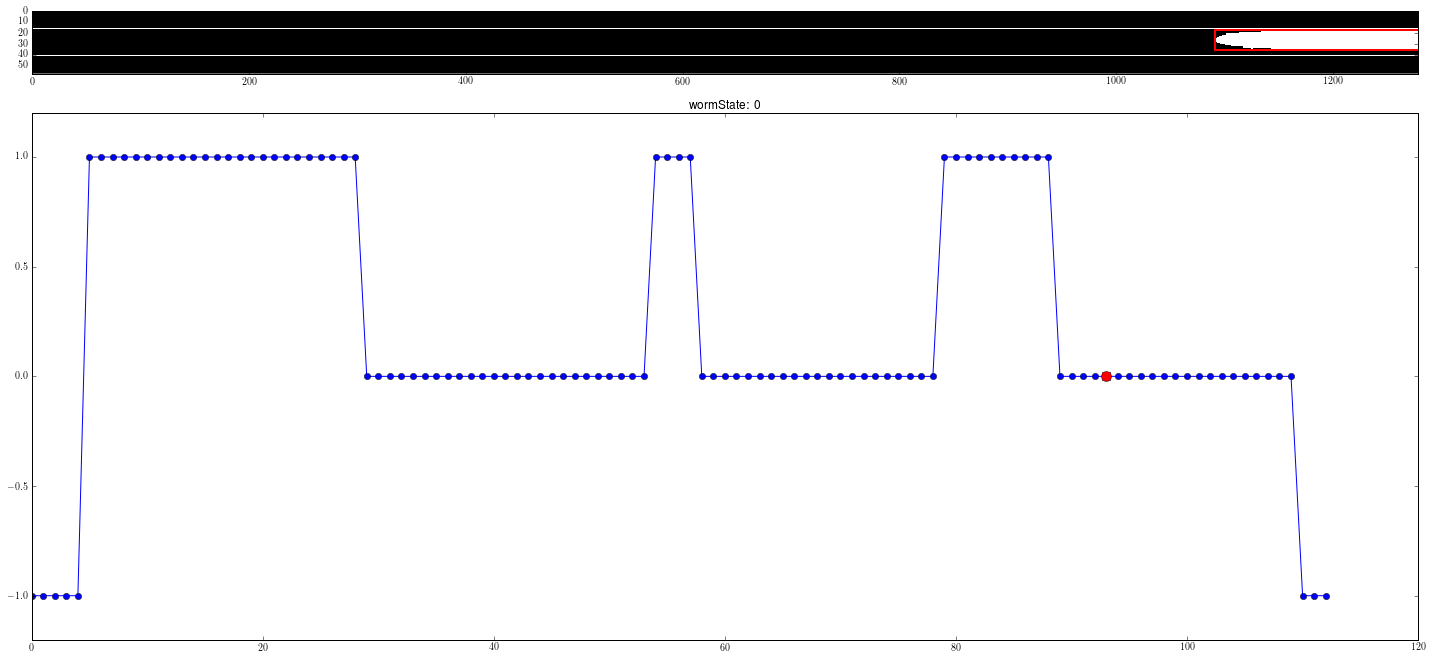

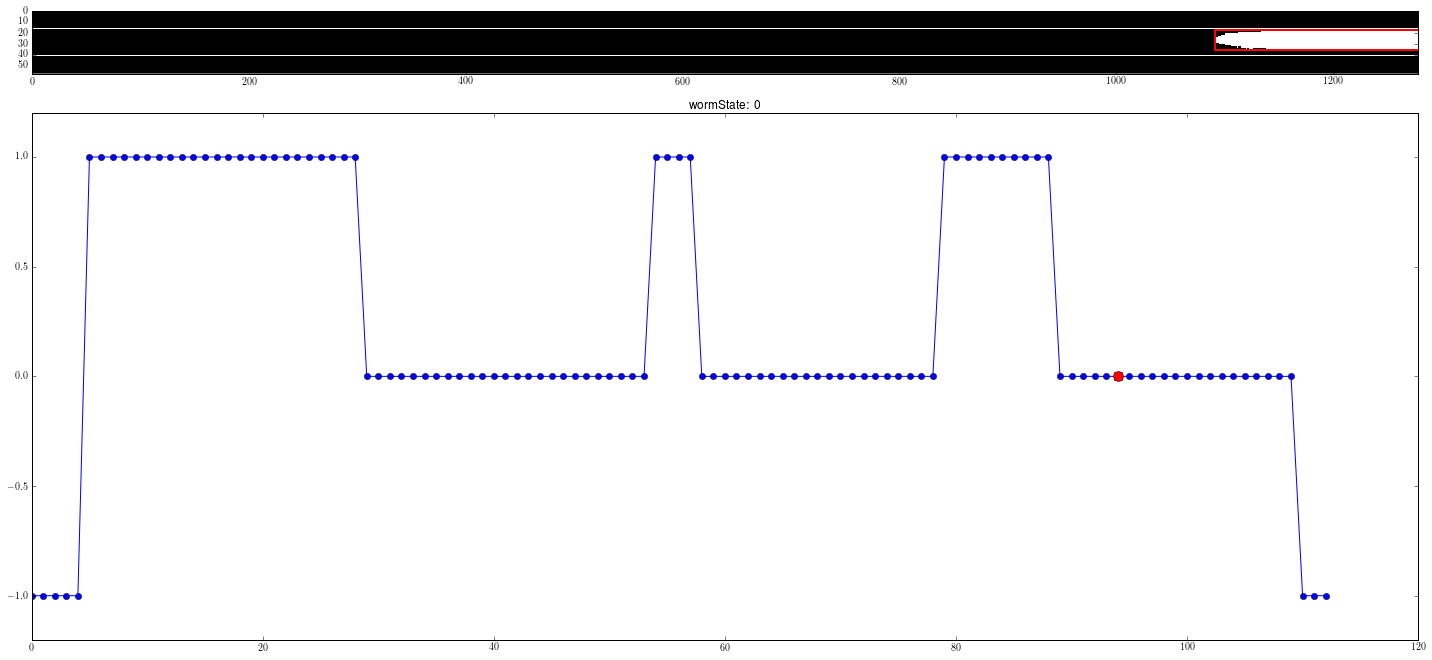

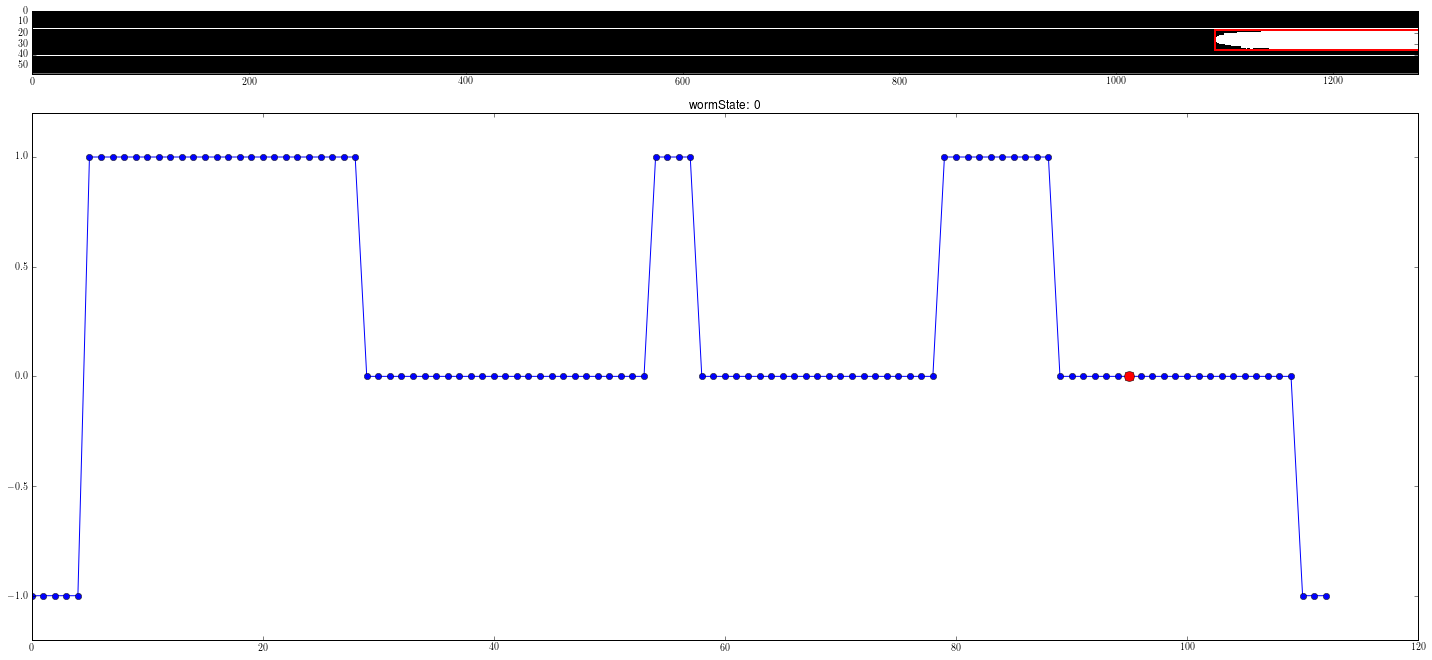

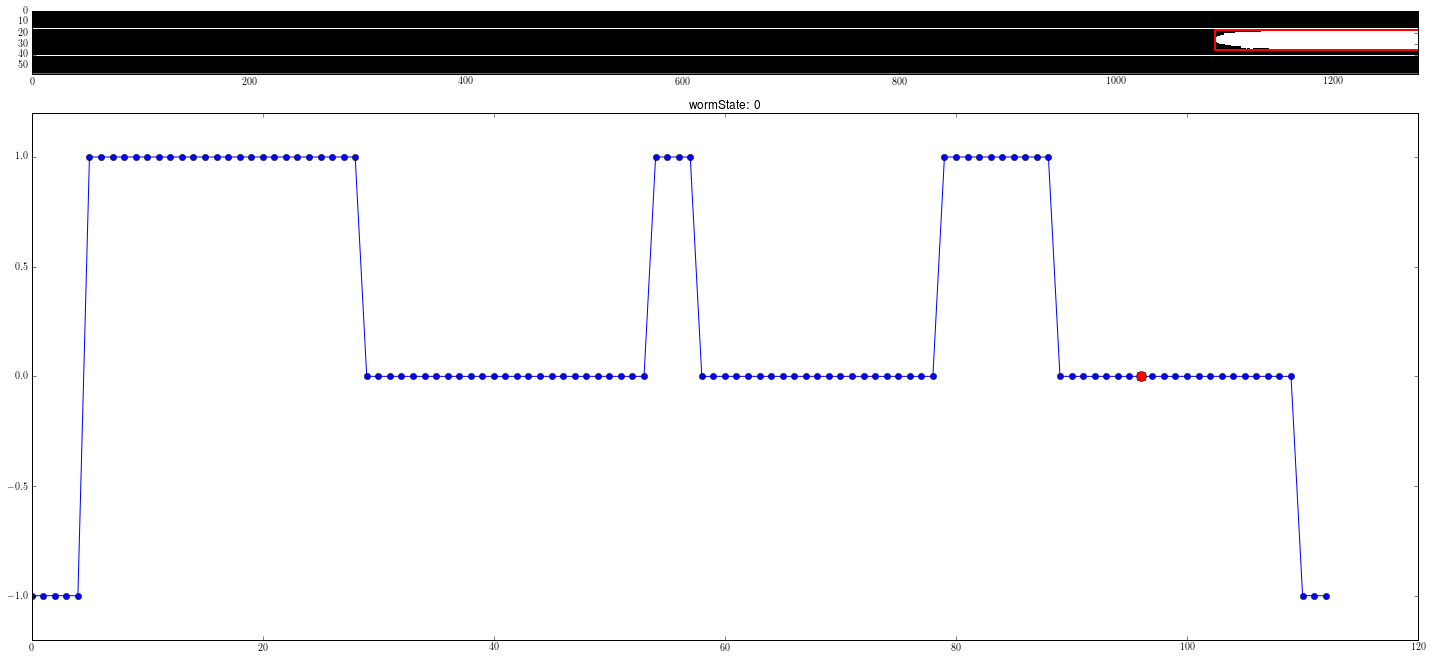

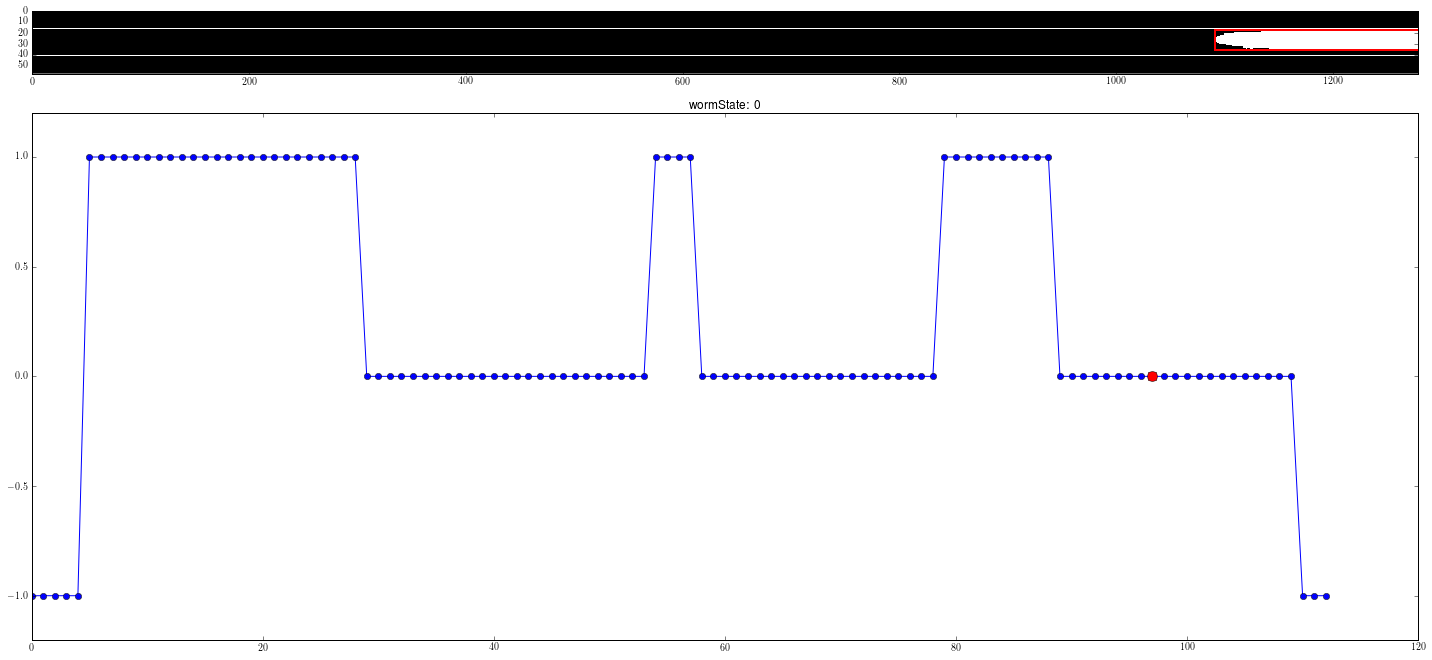

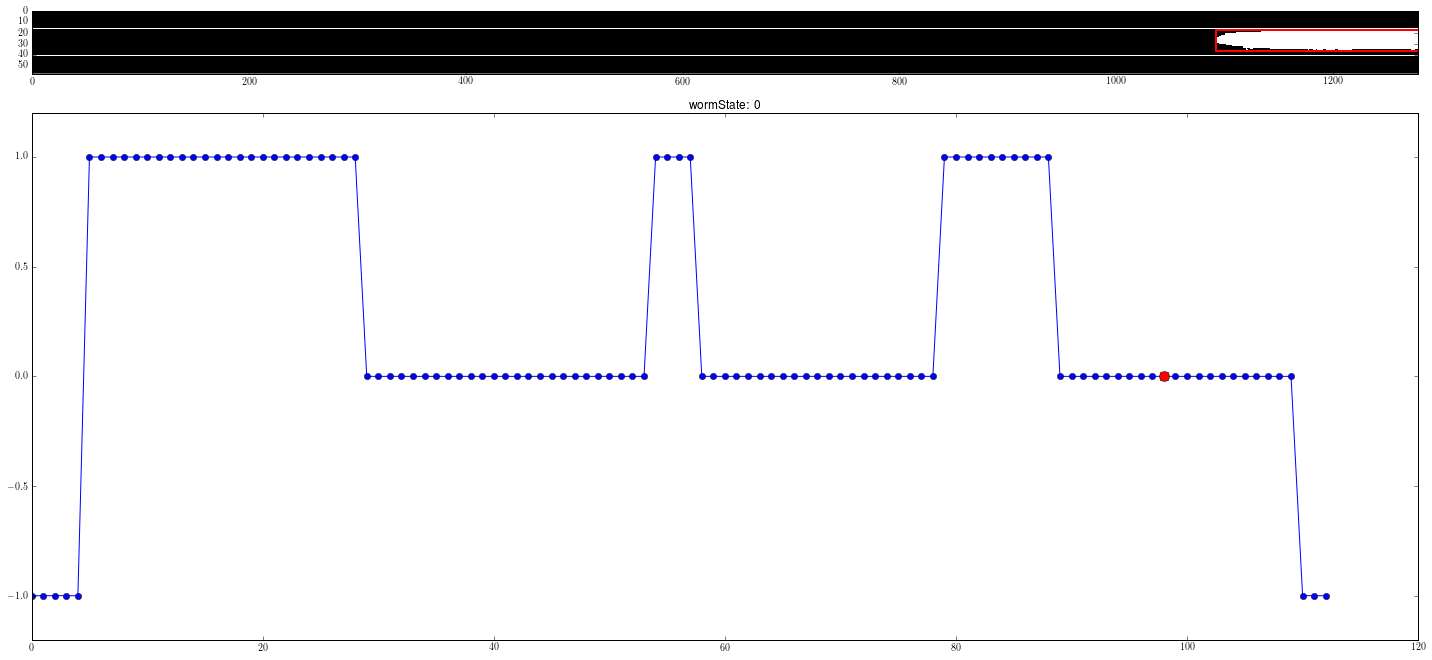

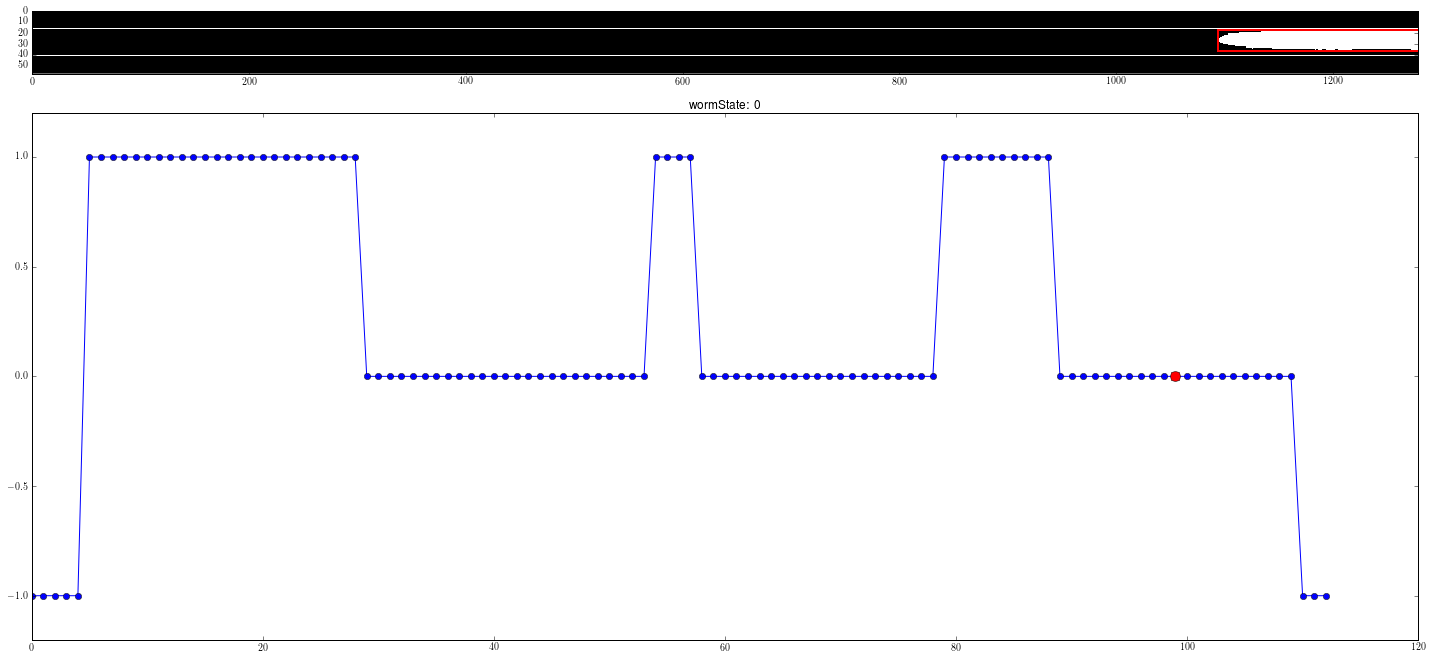

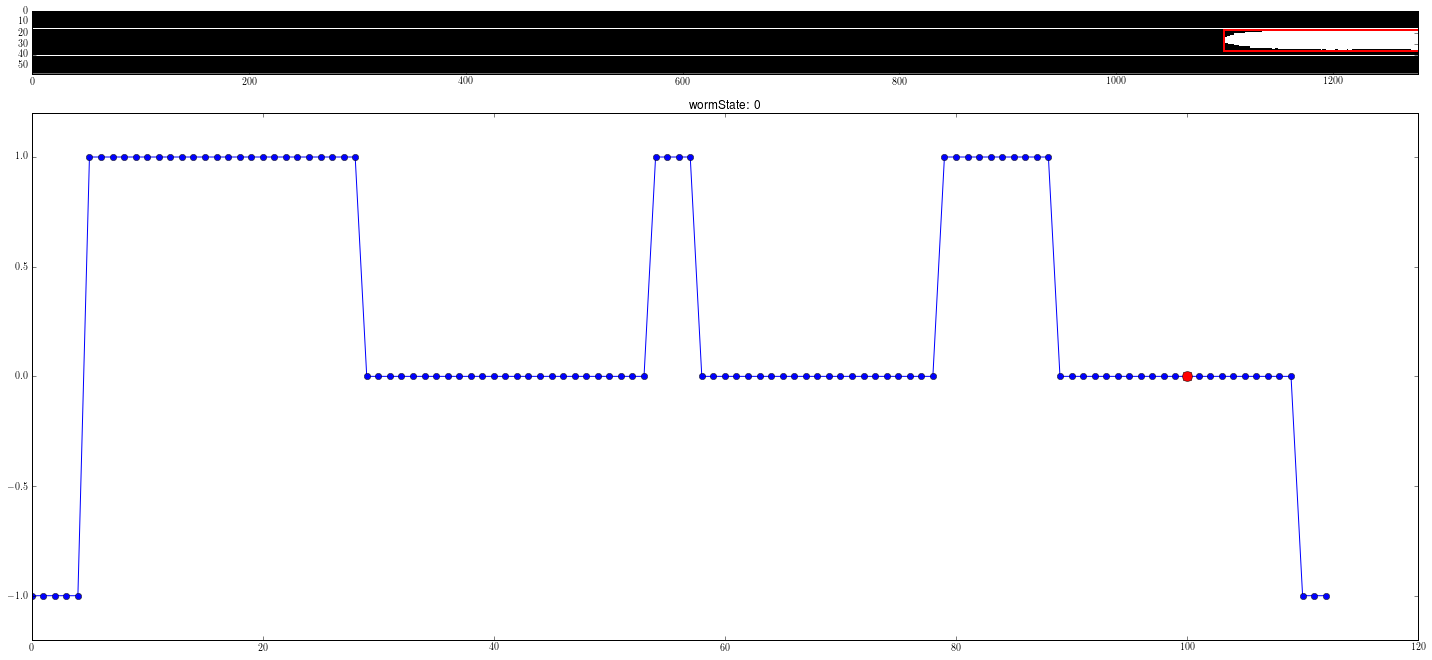

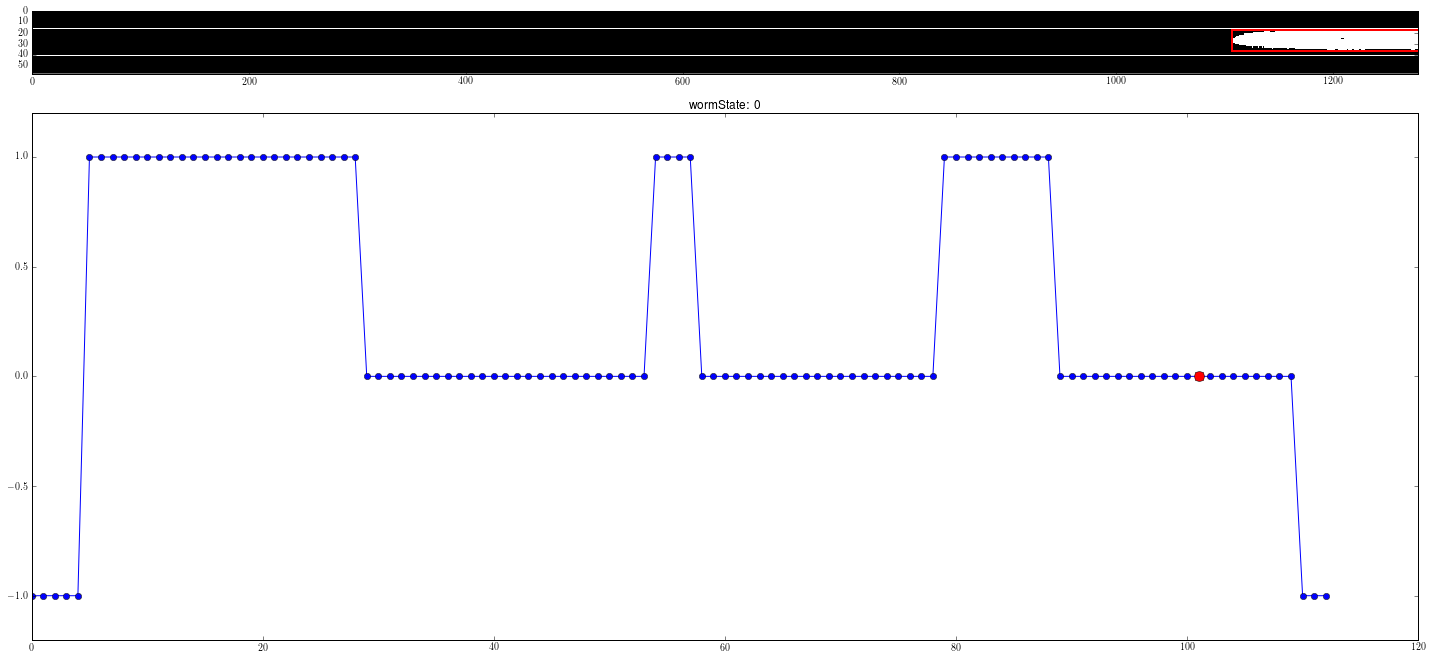

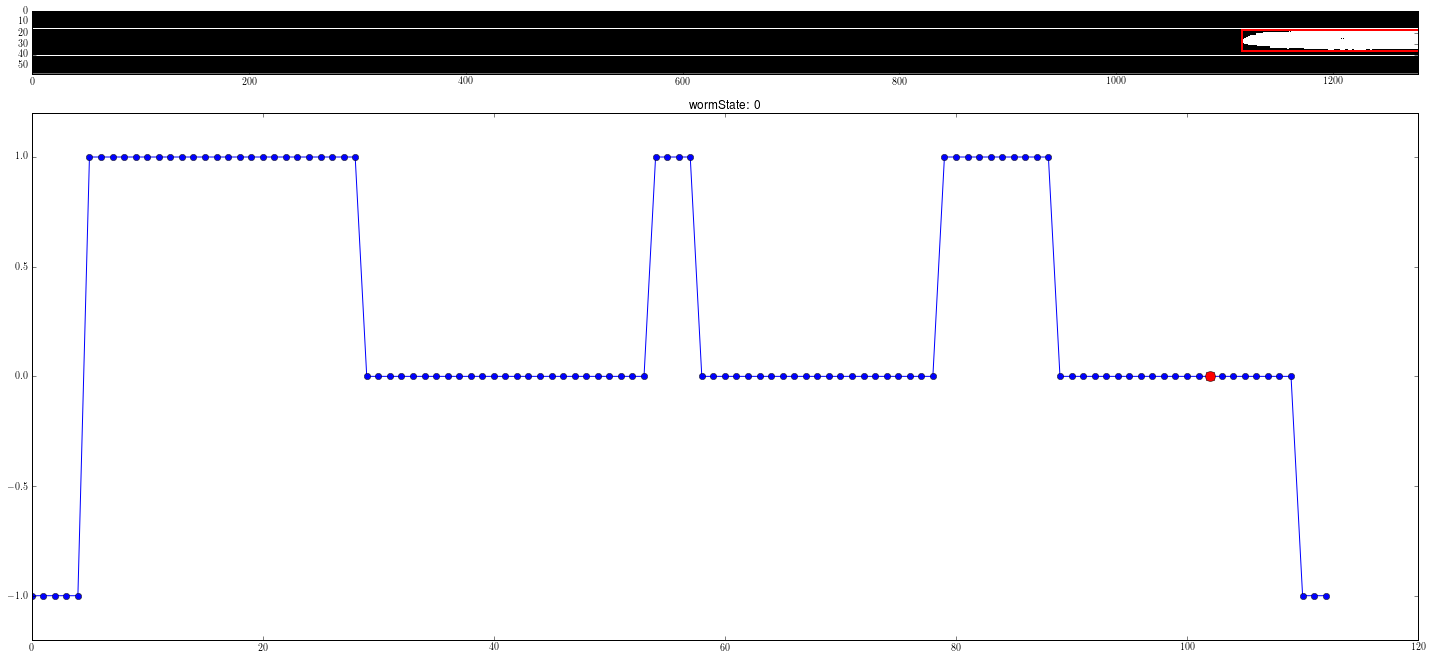

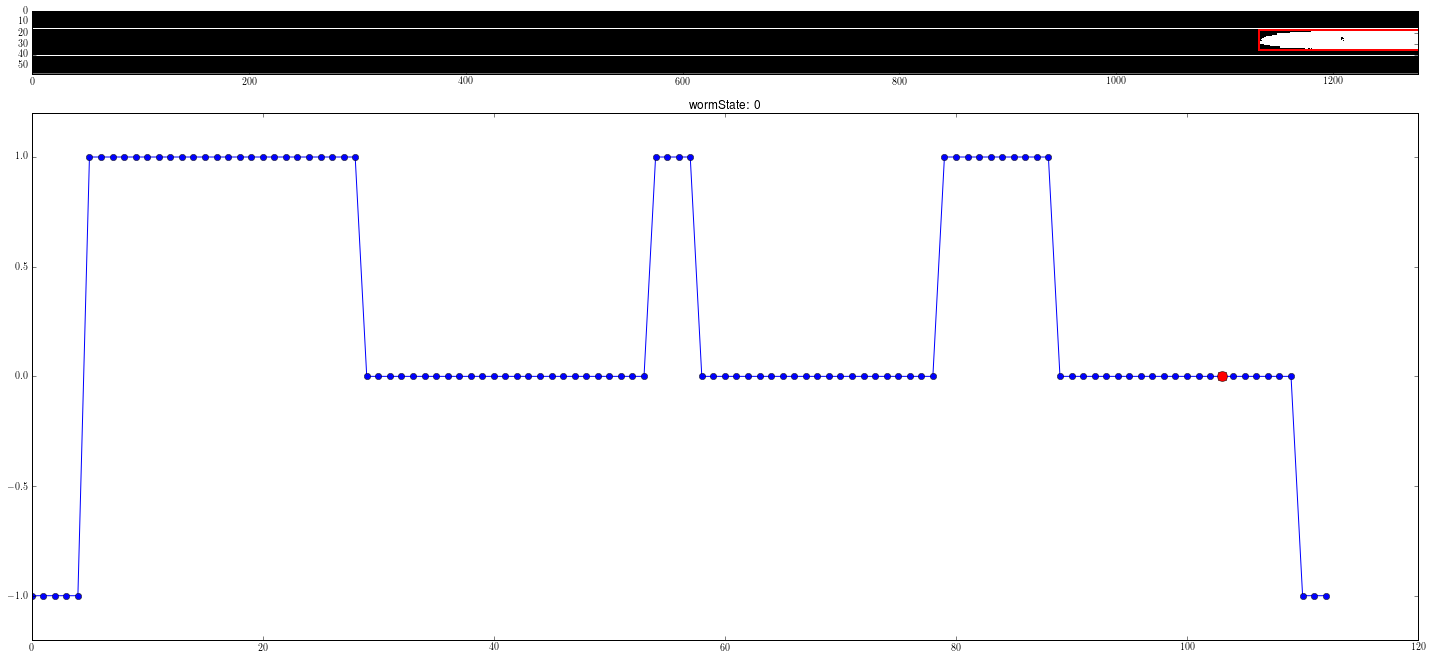

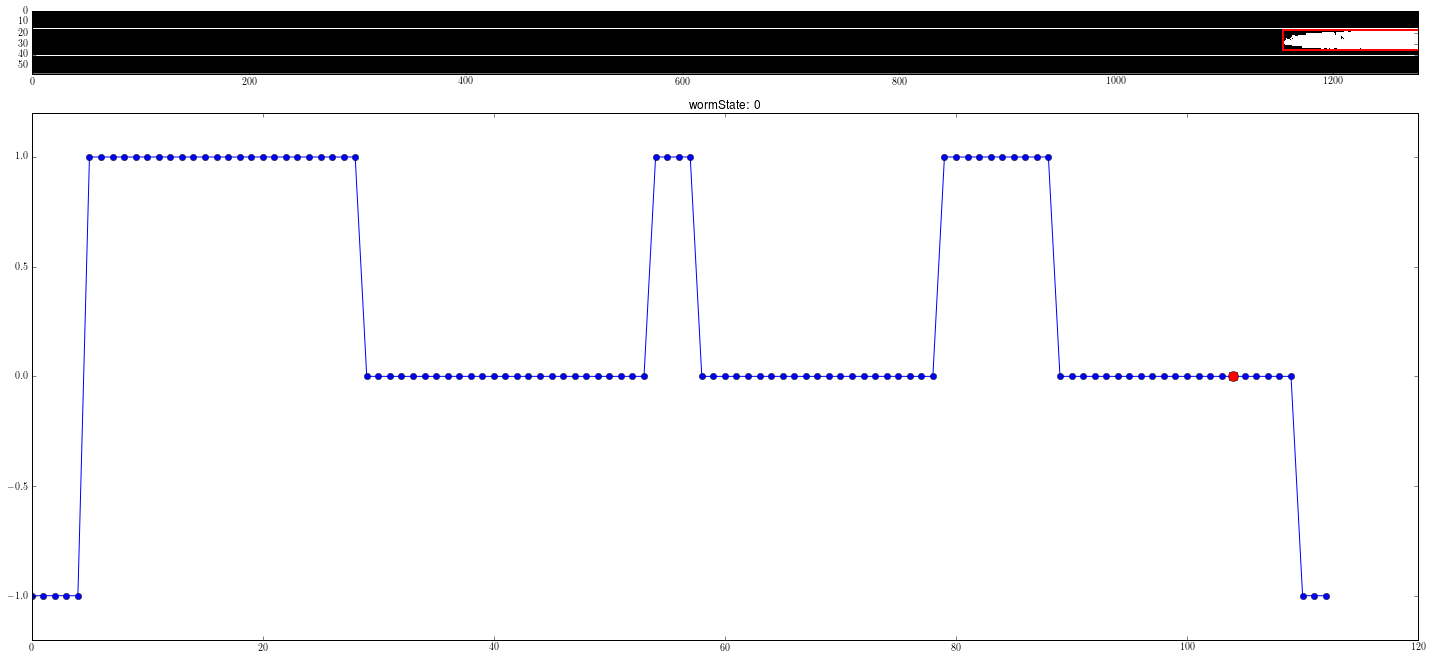

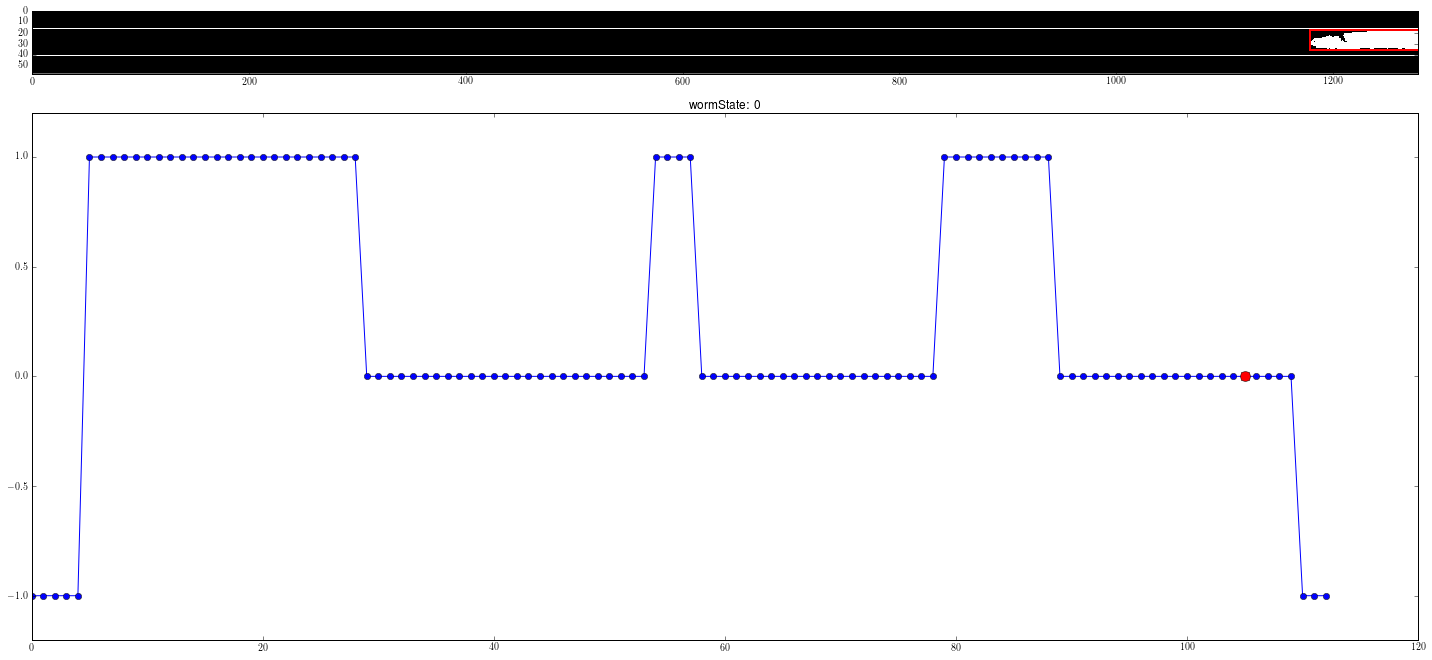

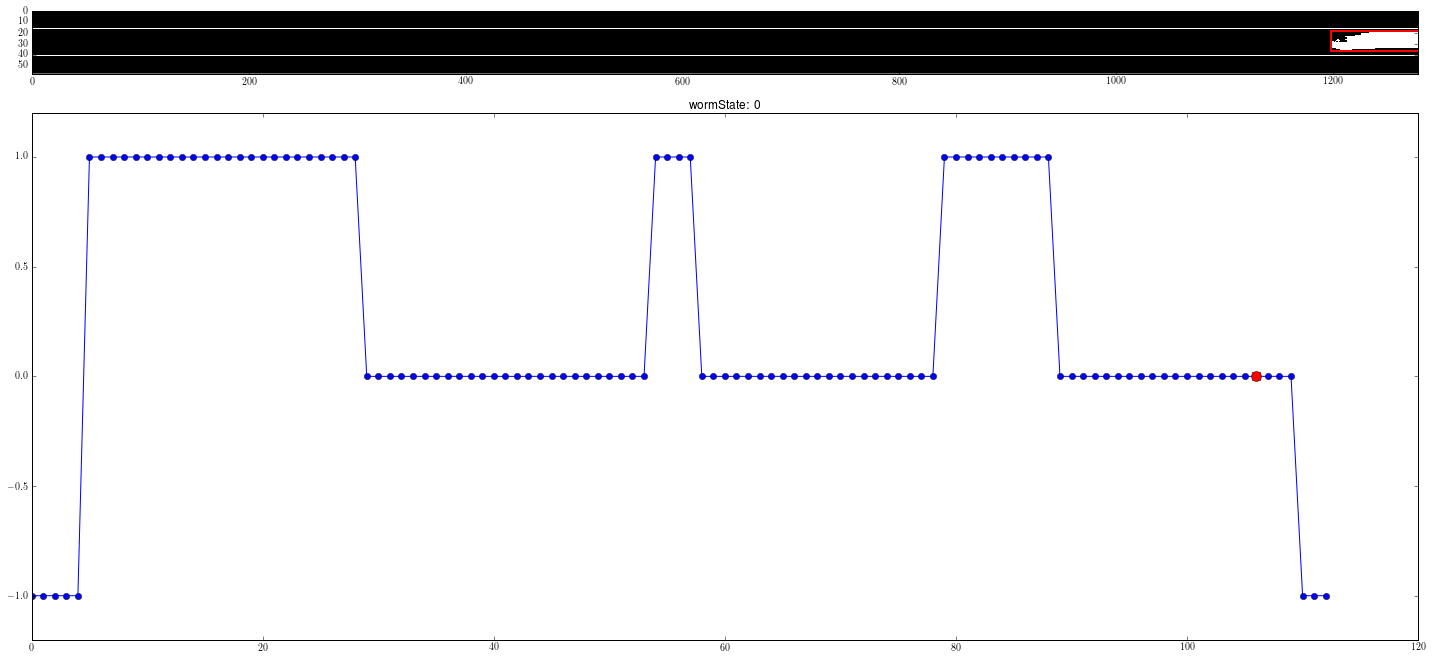

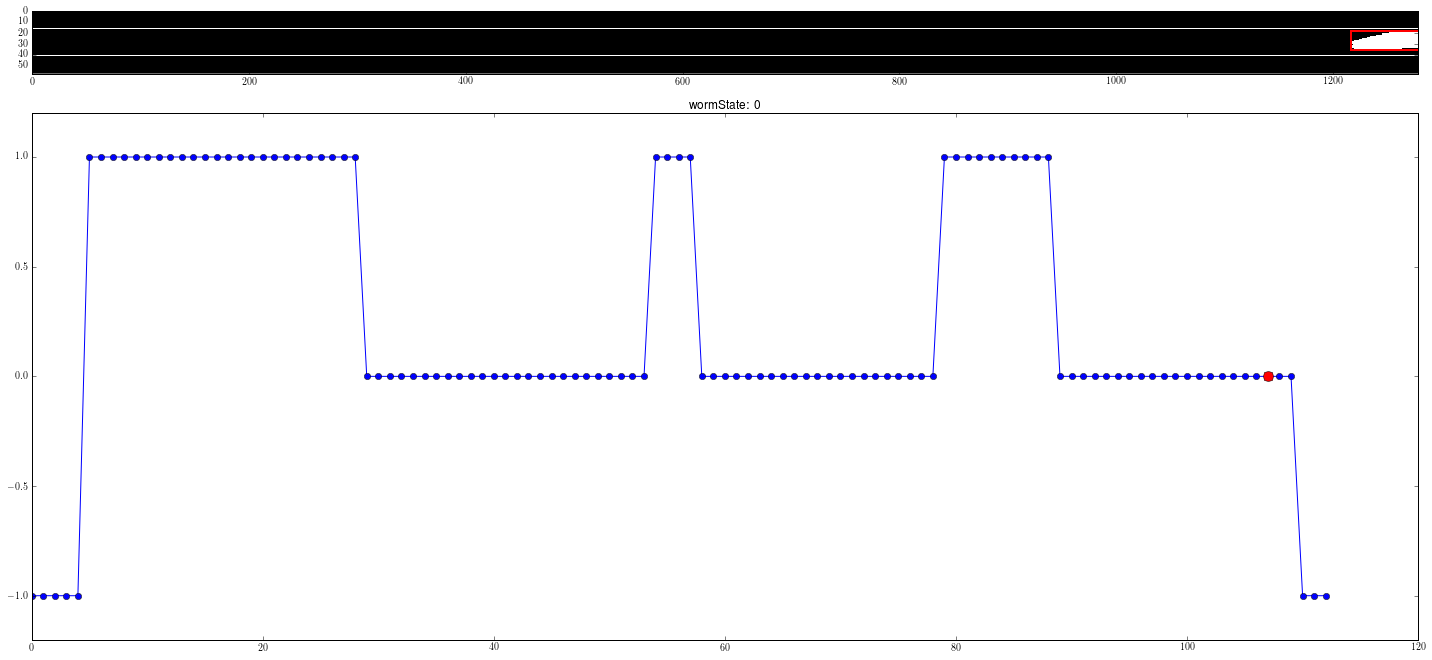

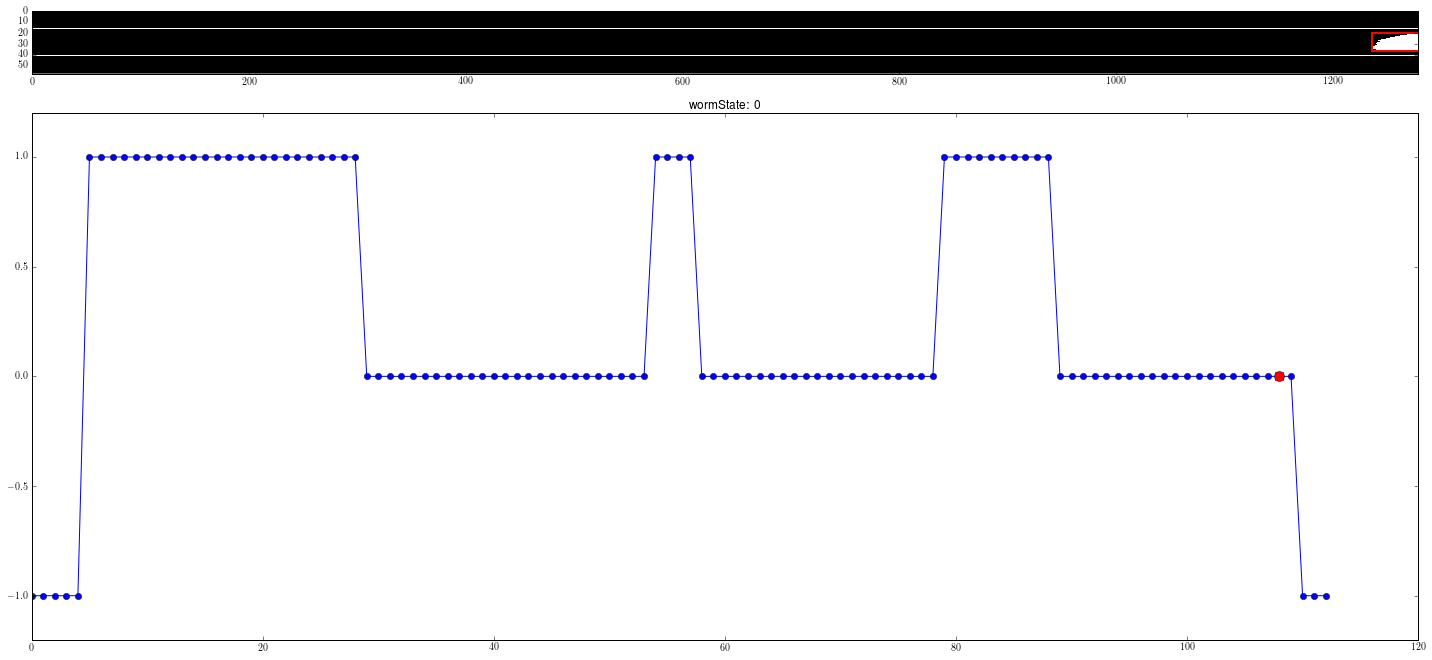

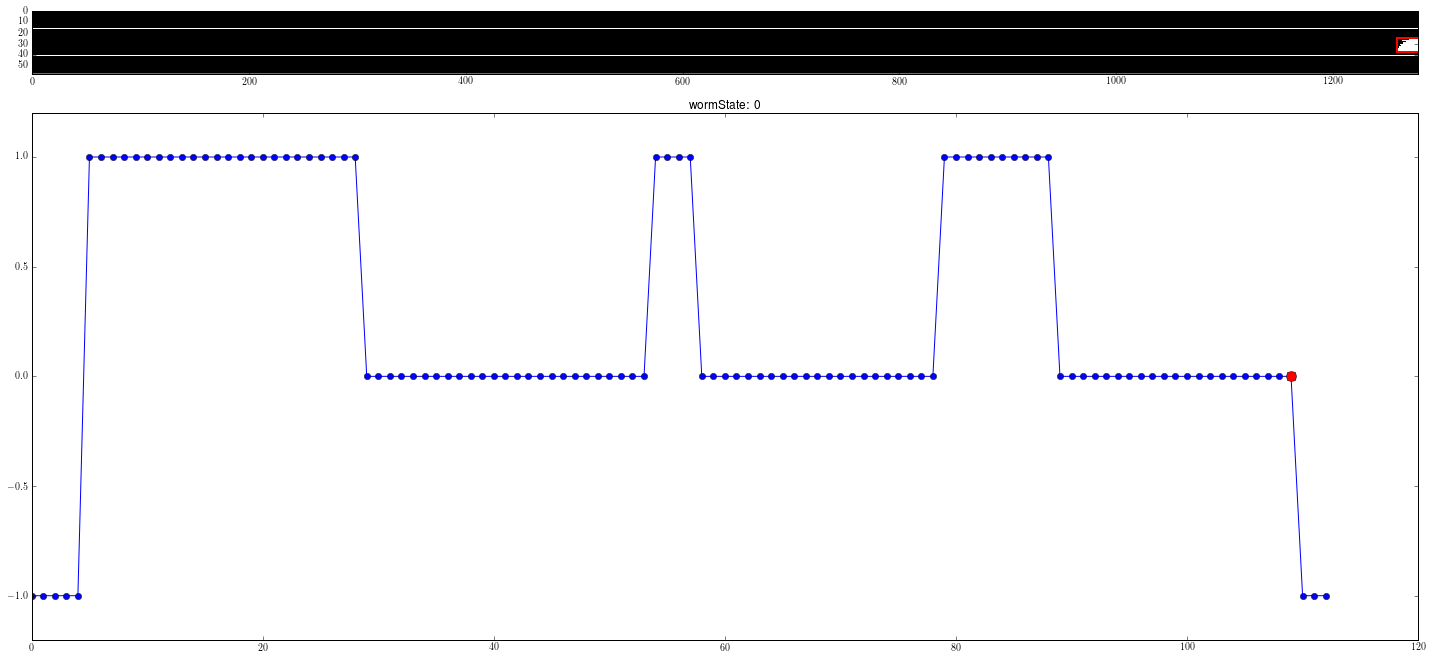

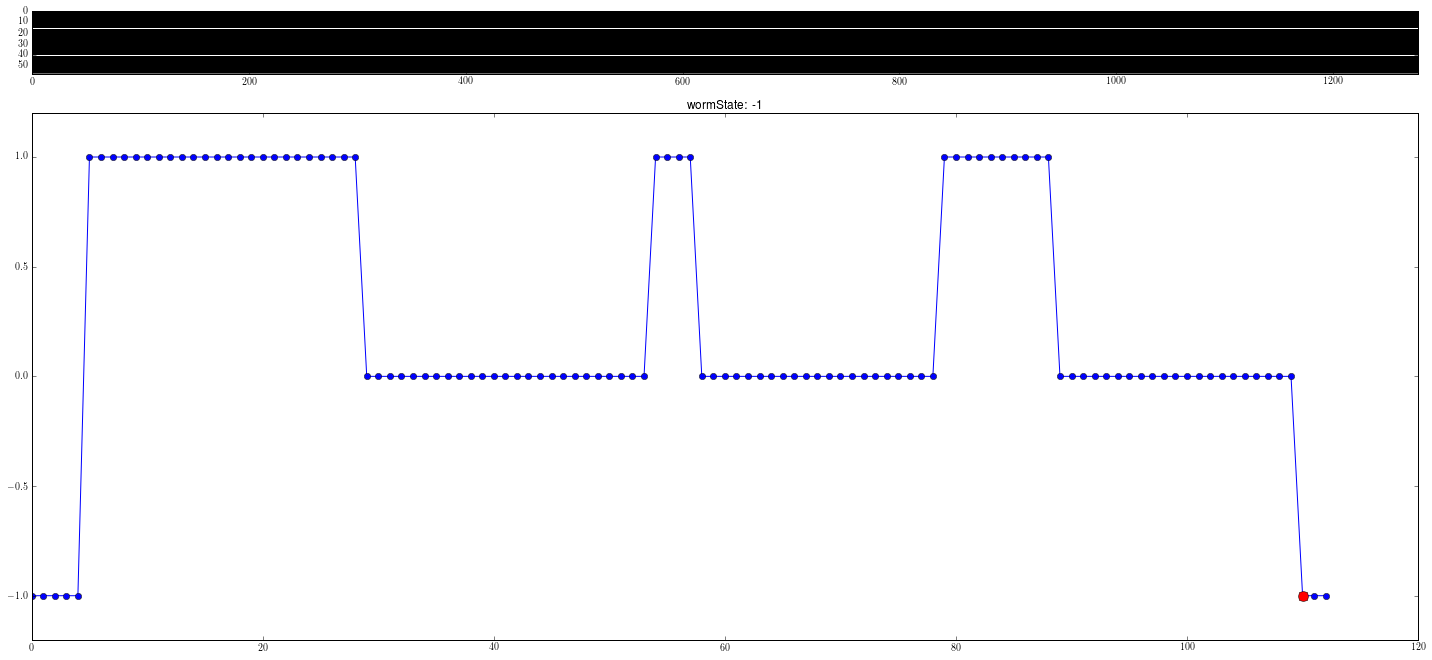

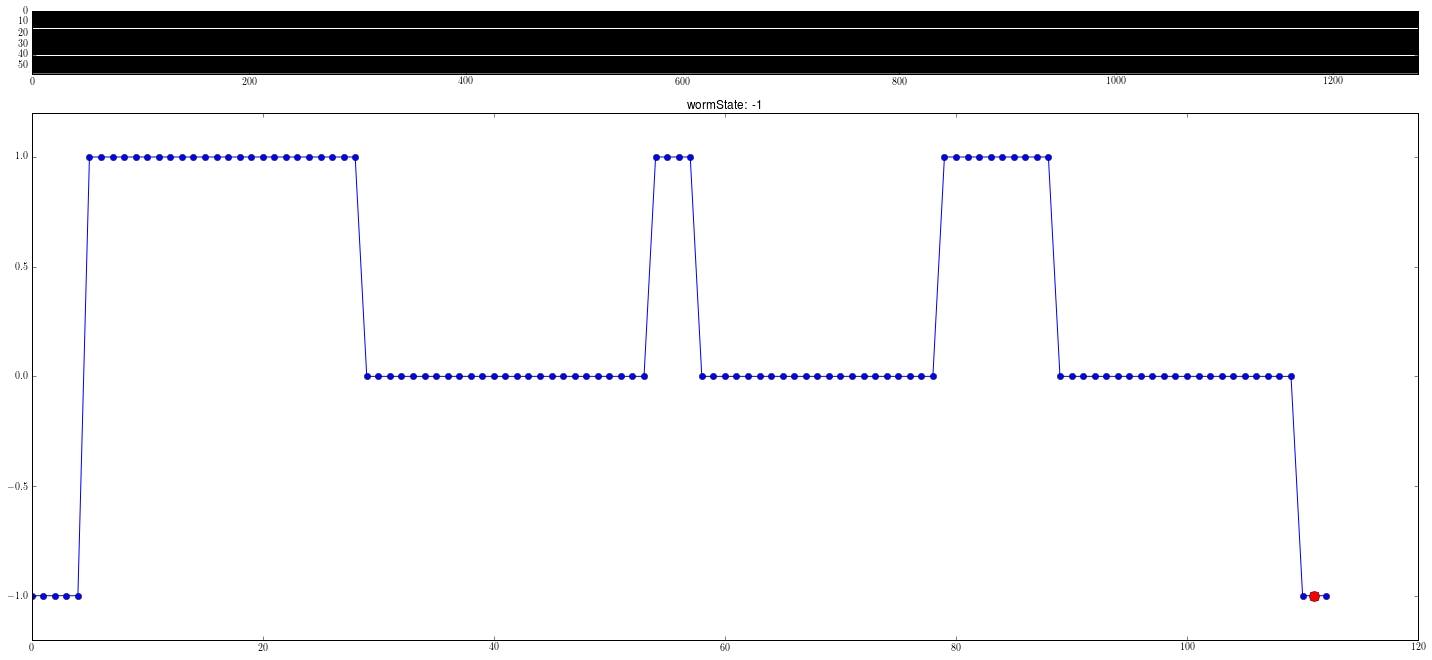

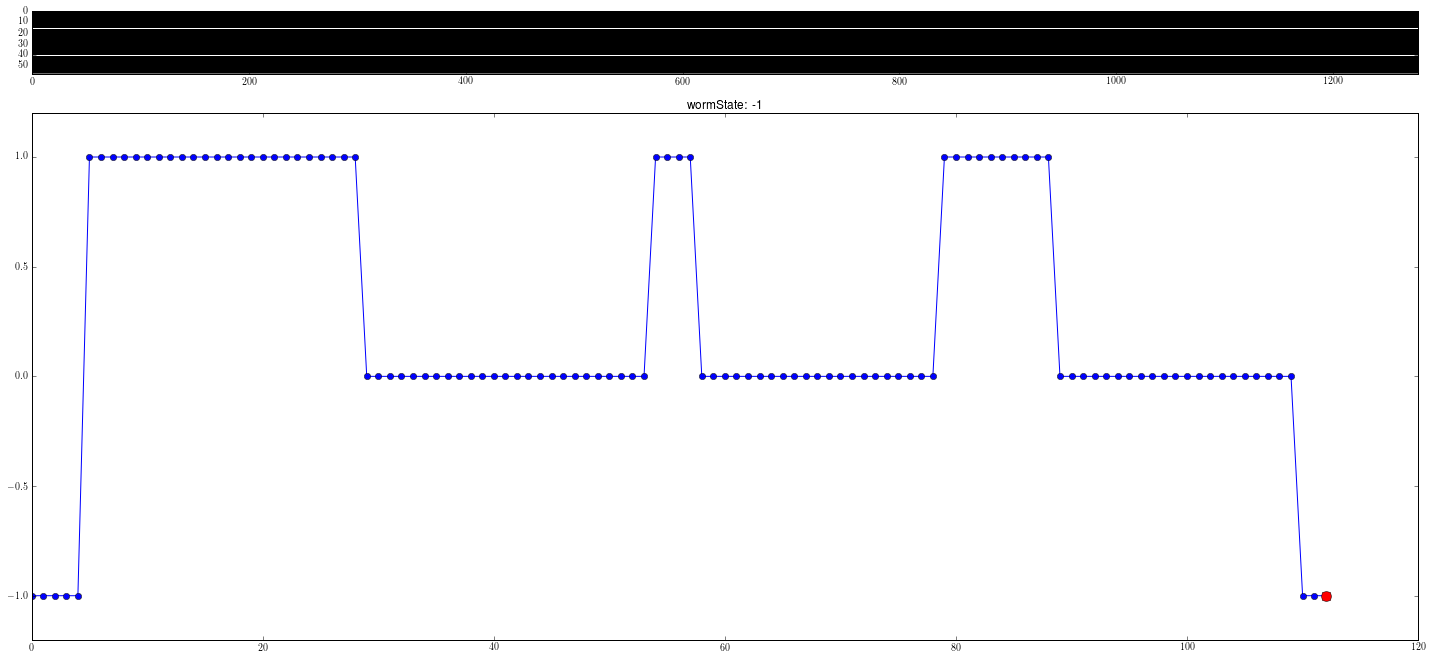

In [21]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

plt.ioff()

for i, im in enumerate(imgsBinary):

    fig = plt.figure(figsize=(20,10))
    
    gs = gridspec.GridSpec(2, 1,
                       width_ratios=[1],
                       height_ratios=[1,3]
                       )
    
    ax = fig.add_subplot(gs[0])
                      
    ax.imshow(im, cmap=cm.gray,interpolation='none')
    ax.axhline(y=regionOfInterest[0][0], xmin=0, xmax=imgBack.shape[1], c="w")
    ax.axhline(y=regionOfInterest[0][1], xmin=0, xmax=imgBack.shape[1], c="w")

    # add box
    box = boxes[i]
    if box is not None:
        minr, minc, maxr, maxc = box
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    
    ax = fig.add_subplot(gs[1])
    ax.plot(wormStates, 'o-')
    ax.plot([i],[wormStates[i]], 'ro', ms=10)
    ax.set_title("wormState: %i" % wormStates[i])
    ax.set_ylim([-1.2,1.2])
    fig.set_tight_layout(True)
    
    fig.savefig("wormState-f-%03i.jpg" % i)
#ax.axhline(x=regionOfInterest[0][1])